## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# Метрики
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
# Инструменты
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import warnings
import os
from time import time
# Графика
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')
sns.set_context("paper")

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])
if not data.index.is_monotonic:
    data.sort_index(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head(), data.tail()

(                     num_orders
 datetime                       
 2018-03-01 00:00:00           9
 2018-03-01 00:10:00          14
 2018-03-01 00:20:00          28
 2018-03-01 00:30:00          20
 2018-03-01 00:40:00          32,                      num_orders
 datetime                       
 2018-08-31 23:10:00          32
 2018-08-31 23:20:00          24
 2018-08-31 23:30:00          27
 2018-08-31 23:40:00          39
 2018-08-31 23:50:00          53)

Данные за полгода. 

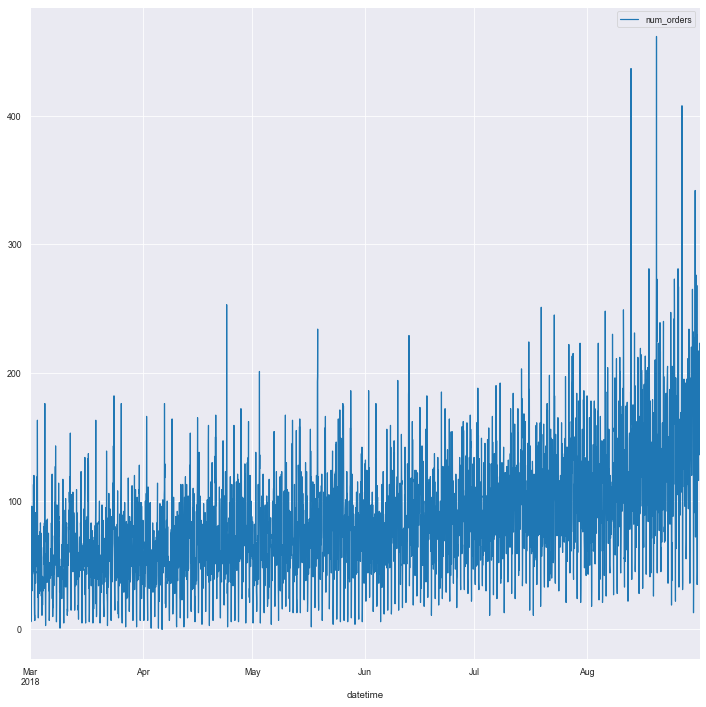

In [4]:
# Ресемлирования по одному часу
data = data.resample('1H').sum()
data.plot(figsize=(12, 12));

# 2. Анализ

In [5]:
# Посмотрим на данные в разрезе дня.
data_day = data.resample('1D').sum()
data_day.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


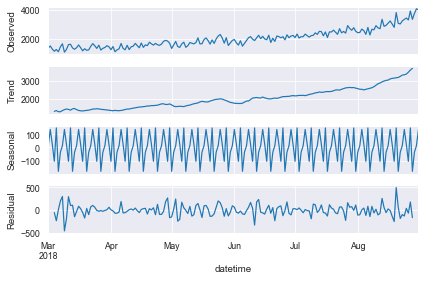

In [6]:
# Trend / Seasonality / Residuals:
decomposed = seasonal_decompose(data_day.num_orders)
decomposed.plot();

1. Растущий тренд;
2. Наличие сезонности;

Посмотрим на срез данных длиной в неделю.

In [7]:
data_week = data["2018-04-01" : "2018-04-08"]
data_week.head()

,num_orders
datetime,
2018-04-01 00:00:00,85
2018-04-01 01:00:00,42
2018-04-01 02:00:00,34
2018-04-01 03:00:00,24
2018-04-01 04:00:00,39


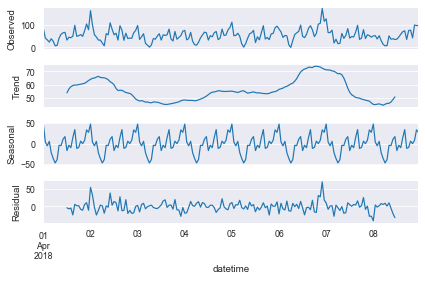

In [8]:
# Trend / Seasonality / Residuals:
decomposed = seasonal_decompose(data_week.num_orders)
decomposed.plot();

Наблюдаются та же сезонность, только еженедельная.
1. Пики от вечера пт до утра понедельника;
2. В течение дня больший спос по вечерам.

На основании этого выделяем следующие признаки:
1. Месяц;
2. День;
3. День недели;
4. Час.

In [9]:
def make_features(data, max_lag : int, rolling_window : int):
    data["month"] = data.index.month
    data["day"] = data.index.day
    data["dayofweek"] = data.index.dayofweek
    data["hour"] = data.index.hour
    # Lag
    for lag in range(1, max_lag + 1):
        data[f"lag_{lag}"] = data.num_orders.shift(lag)
    # Rolling_window
    data["rolling_mean"] = data.num_orders.shift().rolling(rolling_window).mean()

In [10]:
week = 7
make_features(data, 3 * week - 1, 3 * week)

In [11]:
data.sample(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-14 01:00:00,72,3,14,2,1,84.0,75.0,62.0,77.0,91.0,...,40.0,34.0,75.0,53.0,44.0,57.0,20.0,15.0,17.0,54.904762
2018-03-19 05:00:00,10,3,19,0,5,46.0,65.0,20.0,163.0,97.0,...,40.0,52.0,72.0,55.0,69.0,32.0,16.0,32.0,58.0,60.761905
2018-03-29 09:00:00,61,3,29,3,9,61.0,13.0,7.0,16.0,58.0,...,76.0,74.0,49.0,50.0,55.0,84.0,45.0,42.0,37.0,56.142857
2018-03-04 22:00:00,83,3,4,6,22,75.0,77.0,56.0,80.0,51.0,...,19.0,39.0,39.0,12.0,11.0,22.0,27.0,42.0,26.0,43.571429
2018-06-05 21:00:00,81,6,5,1,21,66.0,33.0,60.0,78.0,113.0,...,66.0,58.0,6.0,24.0,76.0,43.0,49.0,81.0,47.0,59.666667
2018-03-28 05:00:00,15,3,28,2,5,35.0,55.0,51.0,57.0,95.0,...,51.0,82.0,73.0,55.0,24.0,41.0,59.0,84.0,32.0,57.619048
2018-05-01 12:00:00,40,5,1,1,12,43.0,53.0,66.0,49.0,6.0,...,81.0,77.0,85.0,88.0,61.0,65.0,57.0,68.0,100.0,61.000000
2018-08-14 23:00:00,212,8,14,1,23,81.0,119.0,84.0,109.0,98.0,...,162.0,155.0,135.0,91.0,54.0,45.0,47.0,139.0,190.0,108.857143
2018-03-21 17:00:00,61,3,21,2,17,61.0,57.0,46.0,64.0,37.0,...,15.0,21.0,51.0,35.0,85.0,71.0,69.0,55.0,47.0,48.857143


# 3. Обучение

In [12]:
train, test = train_test_split(
    data, 
    test_size = .1, 
    shuffle = False,
    random_state = 2718
)
train, test = train.dropna(), test.dropna()
train.shape, test.shape

((3953, 26), (442, 26))

In [13]:
y_train, y_test = train.num_orders, test.num_orders
X_train, X_test = train.drop("num_orders", axis=1), test.drop("num_orders", axis=1)
X_train.head()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 21:00:00,3,1,3,21,61.0,45.0,73.0,44.0,43.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,53.666667
2018-03-01 22:00:00,3,1,3,22,66.0,61.0,45.0,73.0,44.0,43.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,50.904762
2018-03-01 23:00:00,3,1,3,23,113.0,66.0,61.0,45.0,73.0,44.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,52.238095
2018-03-02 00:00:00,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,51.619048
2018-03-02 01:00:00,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,52.761905


In [14]:
def rmse(y_true, y_pred): return np.sqrt(mse(y_true, y_pred))

In [15]:
scorer = make_scorer(rmse, greater_is_better=False)

In [16]:
def cross_validation(model, X, y, param_grid, scoring):

    model_cv = GridSearchCV(
        model(),
        param_grid = param_grid,
        cv = 4,
        scoring = scoring,
        return_train_score=True
    )
    # Подбор гиперпараметров
    model_cv = model_cv.fit(X, y)
    # Best etimator
    model_best = model_cv.best_estimator_
    cv_results = model_cv.cv_results_
    # Train
    start_time = time()
    model_best.fit(X, y)
    train_time = time() - start_time
    # Predict
    start_time = time()
    predictions = model_best.predict(X)
    predict_time = time() - start_time
    # RMSE
    rmse_metrics = rmse(y, predictions)
    # Result list
    rlt = [{
        "Model name" : type(model_best).__name__,
        "Train time" : round(train_time, 4),
        "Predict time" : round(predict_time, 4),
        "RMSE train_score" : -model_cv.best_score_.round(4),
        "RMSE predict_score" : round(rmse_metrics, 4),
        "Parameters" : model_cv.best_params_
    }]
    return model_best, model_cv.best_params_, rlt

In [17]:
# List for model results
results = []

### LinearRegression

In [18]:
lr_params = {}

In [19]:
%%time

lr, lr_params, lr_result = cross_validation(
    model=LinearRegression,
    X = X_train,
    y = y_train,
    param_grid = {},
    scoring = scorer
)
results += lr_result
results[-1]

Wall time: 36.9 ms


{'Model name': 'LinearRegression',
 'Train time': 0.004,
 'Predict time': 0.001,
 'RMSE train_score': 29.6961,
 'RMSE predict_score': 28.9446,
 'Parameters': {}}

### DecisionTreeRegressor

In [20]:
tree_params = {
    "max_depth" : range(1, 5),
    "min_samples_split" : range(2, 5),
    "min_samples_leaf" : range(1, 4),
    "random_state" : [2718]
}

In [21]:
%%time

tree, tree_params, tree_result = cross_validation(
    model=DecisionTreeRegressor,
    X = X_train,
    y = y_train,
    param_grid = tree_params,
    scoring = scorer
)
results += tree_result
results[-1]

Wall time: 1.77 s


{'Model name': 'DecisionTreeRegressor',
 'Train time': 0.017,
 'Predict time': 0.001,
 'RMSE train_score': 30.9604,
 'RMSE predict_score': 26.8529,
 'Parameters': {'max_depth': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'random_state': 2718}}

### RandomForestRegressor

In [22]:
rf_params = {
    "max_depth" : range(1, 5),
    "min_samples_split" : range(2, 5),
    "min_samples_leaf" : range(1, 4),
    "random_state" : [2718]
}

In [23]:
%%time

rf, rf_params, rf_result = cross_validation(
    model = RandomForestRegressor,
    X = X_train,
    y = y_train,
    param_grid = rf_params,
    scoring = scorer
)
results += rf_result
results[-1]

Wall time: 9.48 s


{'Model name': 'RandomForestRegressor',
 'Train time': 0.1117,
 'Predict time': 0.003,
 'RMSE train_score': 29.8135,
 'RMSE predict_score': 25.5533,
 'Parameters': {'max_depth': 4,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'random_state': 2718}}

### CatBoostRegressor

In [24]:
cbr_params = {
    "iterations" : range(400, 1000 + 1, 200),
    "learning_rate" : [0.05, 0.1, 0.15],
    "random_state" : [2718]
}

In [25]:
%%time

cbr, cbr_params, cbr_result = cross_validation(
    model = CatBoostRegressor,
    X = X_train,
    y = y_train,
    param_grid = cbr_params,
    scoring = scorer
)
results += cbr_result
results[-1]

0:	learn: 37.9207953	total: 151ms	remaining: 1m
1:	learn: 37.0733605	total: 161ms	remaining: 32s
2:	learn: 36.3756946	total: 164ms	remaining: 21.6s
3:	learn: 35.6206421	total: 167ms	remaining: 16.5s
4:	learn: 34.9598274	total: 170ms	remaining: 13.4s
5:	learn: 34.3854745	total: 173ms	remaining: 11.3s
6:	learn: 33.8534171	total: 175ms	remaining: 9.83s
7:	learn: 33.4053597	total: 178ms	remaining: 8.7s
8:	learn: 32.8540431	total: 180ms	remaining: 7.82s
9:	learn: 32.2851063	total: 183ms	remaining: 7.13s
10:	learn: 31.8811471	total: 188ms	remaining: 6.66s
11:	learn: 31.5547017	total: 192ms	remaining: 6.21s
12:	learn: 31.1183111	total: 195ms	remaining: 5.8s
13:	learn: 30.6743188	total: 199ms	remaining: 5.49s
14:	learn: 30.4001549	total: 202ms	remaining: 5.18s
15:	learn: 30.0092803	total: 205ms	remaining: 4.91s
16:	learn: 29.6887528	total: 208ms	remaining: 4.69s
17:	learn: 29.4137427	total: 212ms	remaining: 4.51s
18:	learn: 29.0948327	total: 216ms	remaining: 4.33s
19:	learn: 28.8488952	total: 

168:	learn: 20.3490951	total: 633ms	remaining: 865ms
169:	learn: 20.3153675	total: 635ms	remaining: 860ms
170:	learn: 20.3024645	total: 638ms	remaining: 854ms
171:	learn: 20.2746912	total: 640ms	remaining: 848ms
172:	learn: 20.2551404	total: 642ms	remaining: 843ms
173:	learn: 20.2284446	total: 645ms	remaining: 837ms
174:	learn: 20.2139062	total: 647ms	remaining: 832ms
175:	learn: 20.1774876	total: 649ms	remaining: 826ms
176:	learn: 20.1702129	total: 651ms	remaining: 821ms
177:	learn: 20.1364135	total: 654ms	remaining: 815ms
178:	learn: 20.1110879	total: 656ms	remaining: 810ms
179:	learn: 20.0988730	total: 659ms	remaining: 805ms
180:	learn: 20.0894223	total: 661ms	remaining: 800ms
181:	learn: 20.0682401	total: 664ms	remaining: 796ms
182:	learn: 20.0367002	total: 668ms	remaining: 792ms
183:	learn: 20.0127704	total: 670ms	remaining: 787ms
184:	learn: 20.0072497	total: 673ms	remaining: 782ms
185:	learn: 19.9938180	total: 676ms	remaining: 778ms
186:	learn: 19.9595280	total: 678ms	remaining:

341:	learn: 16.5168938	total: 1.12s	remaining: 189ms
342:	learn: 16.5069981	total: 1.12s	remaining: 186ms
343:	learn: 16.4798543	total: 1.12s	remaining: 182ms
344:	learn: 16.4526736	total: 1.12s	remaining: 179ms
345:	learn: 16.4255156	total: 1.13s	remaining: 176ms
346:	learn: 16.4085257	total: 1.13s	remaining: 172ms
347:	learn: 16.3833763	total: 1.13s	remaining: 169ms
348:	learn: 16.3639458	total: 1.14s	remaining: 166ms
349:	learn: 16.3458185	total: 1.14s	remaining: 163ms
350:	learn: 16.3336096	total: 1.14s	remaining: 160ms
351:	learn: 16.3201115	total: 1.15s	remaining: 156ms
352:	learn: 16.3009847	total: 1.15s	remaining: 153ms
353:	learn: 16.2736468	total: 1.15s	remaining: 150ms
354:	learn: 16.2638919	total: 1.15s	remaining: 146ms
355:	learn: 16.2384262	total: 1.16s	remaining: 143ms
356:	learn: 16.2138659	total: 1.16s	remaining: 140ms
357:	learn: 16.1950947	total: 1.16s	remaining: 136ms
358:	learn: 16.1709132	total: 1.17s	remaining: 133ms
359:	learn: 16.1518456	total: 1.17s	remaining:

109:	learn: 21.7429303	total: 323ms	remaining: 853ms
110:	learn: 21.7001550	total: 326ms	remaining: 848ms
111:	learn: 21.6947569	total: 328ms	remaining: 843ms
112:	learn: 21.6799269	total: 330ms	remaining: 839ms
113:	learn: 21.6746462	total: 333ms	remaining: 836ms
114:	learn: 21.6300941	total: 336ms	remaining: 832ms
115:	learn: 21.6241274	total: 341ms	remaining: 836ms
116:	learn: 21.6204441	total: 344ms	remaining: 833ms
117:	learn: 21.5952848	total: 347ms	remaining: 829ms
118:	learn: 21.5870852	total: 350ms	remaining: 826ms
119:	learn: 21.5677771	total: 352ms	remaining: 821ms
120:	learn: 21.5232299	total: 354ms	remaining: 817ms
121:	learn: 21.4891725	total: 357ms	remaining: 813ms
122:	learn: 21.4542780	total: 359ms	remaining: 809ms
123:	learn: 21.4198927	total: 362ms	remaining: 806ms
124:	learn: 21.3902567	total: 364ms	remaining: 801ms
125:	learn: 21.3463868	total: 366ms	remaining: 797ms
126:	learn: 21.3104506	total: 368ms	remaining: 792ms
127:	learn: 21.2958973	total: 371ms	remaining:

325:	learn: 17.2003786	total: 827ms	remaining: 188ms
326:	learn: 17.1749242	total: 829ms	remaining: 185ms
327:	learn: 17.1730961	total: 833ms	remaining: 183ms
328:	learn: 17.1685946	total: 837ms	remaining: 181ms
329:	learn: 17.1522194	total: 840ms	remaining: 178ms
330:	learn: 17.1509284	total: 842ms	remaining: 176ms
331:	learn: 17.1262566	total: 845ms	remaining: 173ms
332:	learn: 17.1252863	total: 847ms	remaining: 170ms
333:	learn: 17.1108067	total: 851ms	remaining: 168ms
334:	learn: 17.0943057	total: 854ms	remaining: 166ms
335:	learn: 17.0922739	total: 856ms	remaining: 163ms
336:	learn: 17.0790908	total: 858ms	remaining: 160ms
337:	learn: 17.0608468	total: 861ms	remaining: 158ms
338:	learn: 17.0367519	total: 867ms	remaining: 156ms
339:	learn: 17.0192550	total: 871ms	remaining: 154ms
340:	learn: 16.9981821	total: 874ms	remaining: 151ms
341:	learn: 16.9684939	total: 877ms	remaining: 149ms
342:	learn: 16.9451600	total: 882ms	remaining: 147ms
343:	learn: 16.9175452	total: 885ms	remaining:

150:	learn: 20.1890740	total: 392ms	remaining: 647ms
151:	learn: 20.1757676	total: 395ms	remaining: 644ms
152:	learn: 20.1326088	total: 397ms	remaining: 641ms
153:	learn: 20.1140875	total: 399ms	remaining: 638ms
154:	learn: 20.0855804	total: 401ms	remaining: 635ms
155:	learn: 20.0487140	total: 404ms	remaining: 631ms
156:	learn: 20.0064630	total: 406ms	remaining: 628ms
157:	learn: 19.9735509	total: 408ms	remaining: 625ms
158:	learn: 19.9596597	total: 411ms	remaining: 622ms
159:	learn: 19.9557881	total: 413ms	remaining: 619ms
160:	learn: 19.9230930	total: 415ms	remaining: 616ms
161:	learn: 19.8889280	total: 417ms	remaining: 613ms
162:	learn: 19.8602819	total: 419ms	remaining: 610ms
163:	learn: 19.8524571	total: 421ms	remaining: 606ms
164:	learn: 19.8329954	total: 423ms	remaining: 603ms
165:	learn: 19.7959700	total: 426ms	remaining: 600ms
166:	learn: 19.7654199	total: 428ms	remaining: 597ms
167:	learn: 19.7389742	total: 430ms	remaining: 594ms
168:	learn: 19.7120987	total: 433ms	remaining:

353:	learn: 16.1403014	total: 888ms	remaining: 115ms
354:	learn: 16.1195205	total: 891ms	remaining: 113ms
355:	learn: 16.1082857	total: 893ms	remaining: 110ms
356:	learn: 16.0909553	total: 895ms	remaining: 108ms
357:	learn: 16.0648211	total: 897ms	remaining: 105ms
358:	learn: 16.0540189	total: 900ms	remaining: 103ms
359:	learn: 16.0530179	total: 902ms	remaining: 100ms
360:	learn: 16.0519988	total: 904ms	remaining: 97.7ms
361:	learn: 16.0302505	total: 907ms	remaining: 95.2ms
362:	learn: 16.0293991	total: 909ms	remaining: 92.7ms
363:	learn: 16.0095505	total: 912ms	remaining: 90.2ms
364:	learn: 15.9952702	total: 915ms	remaining: 87.7ms
365:	learn: 15.9821255	total: 917ms	remaining: 85.2ms
366:	learn: 15.9580400	total: 920ms	remaining: 82.7ms
367:	learn: 15.9246727	total: 923ms	remaining: 80.2ms
368:	learn: 15.9132886	total: 925ms	remaining: 77.7ms
369:	learn: 15.8988712	total: 927ms	remaining: 75.2ms
370:	learn: 15.8980367	total: 929ms	remaining: 72.6ms
371:	learn: 15.8830195	total: 932ms

163:	learn: 17.8027780	total: 353ms	remaining: 508ms
164:	learn: 17.7691779	total: 355ms	remaining: 506ms
165:	learn: 17.7372967	total: 358ms	remaining: 504ms
166:	learn: 17.7159525	total: 360ms	remaining: 502ms
167:	learn: 17.6997748	total: 362ms	remaining: 501ms
168:	learn: 17.6880117	total: 365ms	remaining: 499ms
169:	learn: 17.6664435	total: 368ms	remaining: 498ms
170:	learn: 17.6493648	total: 370ms	remaining: 495ms
171:	learn: 17.6252930	total: 372ms	remaining: 494ms
172:	learn: 17.6033021	total: 375ms	remaining: 492ms
173:	learn: 17.5954061	total: 377ms	remaining: 489ms
174:	learn: 17.5899108	total: 379ms	remaining: 487ms
175:	learn: 17.5776928	total: 381ms	remaining: 485ms
176:	learn: 17.5597451	total: 383ms	remaining: 482ms
177:	learn: 17.5441935	total: 385ms	remaining: 480ms
178:	learn: 17.5140282	total: 387ms	remaining: 478ms
179:	learn: 17.4855042	total: 389ms	remaining: 475ms
180:	learn: 17.4546273	total: 391ms	remaining: 473ms
181:	learn: 17.4374983	total: 393ms	remaining:

322:	learn: 14.9815570	total: 688ms	remaining: 164ms
323:	learn: 14.9757894	total: 690ms	remaining: 162ms
324:	learn: 14.9748678	total: 693ms	remaining: 160ms
325:	learn: 14.9658209	total: 695ms	remaining: 158ms
326:	learn: 14.9432430	total: 697ms	remaining: 156ms
327:	learn: 14.9240988	total: 699ms	remaining: 154ms
328:	learn: 14.9045112	total: 702ms	remaining: 151ms
329:	learn: 14.8866863	total: 704ms	remaining: 149ms
330:	learn: 14.8858559	total: 706ms	remaining: 147ms
331:	learn: 14.8688530	total: 708ms	remaining: 145ms
332:	learn: 14.8562149	total: 710ms	remaining: 143ms
333:	learn: 14.8427162	total: 712ms	remaining: 141ms
334:	learn: 14.8253676	total: 714ms	remaining: 139ms
335:	learn: 14.8245945	total: 716ms	remaining: 136ms
336:	learn: 14.8119785	total: 718ms	remaining: 134ms
337:	learn: 14.7976035	total: 720ms	remaining: 132ms
338:	learn: 14.7880839	total: 722ms	remaining: 130ms
339:	learn: 14.7711209	total: 724ms	remaining: 128ms
340:	learn: 14.7510146	total: 726ms	remaining:

147:	learn: 17.4783365	total: 337ms	remaining: 573ms
148:	learn: 17.4649975	total: 339ms	remaining: 571ms
149:	learn: 17.4250902	total: 341ms	remaining: 569ms
150:	learn: 17.3884939	total: 344ms	remaining: 567ms
151:	learn: 17.3546613	total: 346ms	remaining: 565ms
152:	learn: 17.3273551	total: 349ms	remaining: 563ms
153:	learn: 17.2847806	total: 351ms	remaining: 560ms
154:	learn: 17.2423528	total: 354ms	remaining: 559ms
155:	learn: 17.2048120	total: 357ms	remaining: 558ms
156:	learn: 17.1689500	total: 359ms	remaining: 556ms
157:	learn: 17.1454685	total: 361ms	remaining: 554ms
158:	learn: 17.1047829	total: 364ms	remaining: 551ms
159:	learn: 17.0950839	total: 366ms	remaining: 549ms
160:	learn: 17.0408980	total: 368ms	remaining: 547ms
161:	learn: 16.9927496	total: 371ms	remaining: 545ms
162:	learn: 16.9678695	total: 373ms	remaining: 542ms
163:	learn: 16.9432221	total: 375ms	remaining: 540ms
164:	learn: 16.8935601	total: 378ms	remaining: 538ms
165:	learn: 16.8440065	total: 380ms	remaining:

333:	learn: 12.7283344	total: 830ms	remaining: 164ms
334:	learn: 12.7119110	total: 833ms	remaining: 162ms
335:	learn: 12.6800946	total: 835ms	remaining: 159ms
336:	learn: 12.6780444	total: 838ms	remaining: 157ms
337:	learn: 12.6475848	total: 840ms	remaining: 154ms
338:	learn: 12.6249124	total: 843ms	remaining: 152ms
339:	learn: 12.6134771	total: 845ms	remaining: 149ms
340:	learn: 12.6106245	total: 847ms	remaining: 147ms
341:	learn: 12.5960088	total: 850ms	remaining: 144ms
342:	learn: 12.5777285	total: 852ms	remaining: 142ms
343:	learn: 12.5637928	total: 856ms	remaining: 139ms
344:	learn: 12.5317959	total: 858ms	remaining: 137ms
345:	learn: 12.5064076	total: 861ms	remaining: 134ms
346:	learn: 12.4965443	total: 864ms	remaining: 132ms
347:	learn: 12.4731768	total: 866ms	remaining: 129ms
348:	learn: 12.4522597	total: 869ms	remaining: 127ms
349:	learn: 12.4352842	total: 871ms	remaining: 124ms
350:	learn: 12.4192841	total: 874ms	remaining: 122ms
351:	learn: 12.3964585	total: 876ms	remaining:

104:	learn: 19.4188582	total: 277ms	remaining: 778ms
105:	learn: 19.3688806	total: 279ms	remaining: 775ms
106:	learn: 19.3178403	total: 282ms	remaining: 771ms
107:	learn: 19.2682402	total: 284ms	remaining: 768ms
108:	learn: 19.1970834	total: 286ms	remaining: 764ms
109:	learn: 19.1364374	total: 288ms	remaining: 760ms
110:	learn: 19.0952318	total: 291ms	remaining: 757ms
111:	learn: 19.0554907	total: 294ms	remaining: 755ms
112:	learn: 19.0511893	total: 296ms	remaining: 751ms
113:	learn: 19.0465998	total: 298ms	remaining: 748ms
114:	learn: 18.9937682	total: 301ms	remaining: 745ms
115:	learn: 18.9419985	total: 303ms	remaining: 742ms
116:	learn: 18.9117071	total: 305ms	remaining: 738ms
117:	learn: 18.8821358	total: 307ms	remaining: 735ms
118:	learn: 18.8220080	total: 309ms	remaining: 731ms
119:	learn: 18.7685596	total: 312ms	remaining: 727ms
120:	learn: 18.7279872	total: 315ms	remaining: 725ms
121:	learn: 18.6792076	total: 317ms	remaining: 722ms
122:	learn: 18.6501177	total: 319ms	remaining:

327:	learn: 12.7432546	total: 778ms	remaining: 171ms
328:	learn: 12.7266184	total: 780ms	remaining: 168ms
329:	learn: 12.7052693	total: 782ms	remaining: 166ms
330:	learn: 12.6837427	total: 785ms	remaining: 164ms
331:	learn: 12.6743346	total: 787ms	remaining: 161ms
332:	learn: 12.6715698	total: 789ms	remaining: 159ms
333:	learn: 12.6508540	total: 792ms	remaining: 156ms
334:	learn: 12.6353333	total: 794ms	remaining: 154ms
335:	learn: 12.6148933	total: 797ms	remaining: 152ms
336:	learn: 12.5855012	total: 799ms	remaining: 149ms
337:	learn: 12.5637445	total: 802ms	remaining: 147ms
338:	learn: 12.5570684	total: 804ms	remaining: 145ms
339:	learn: 12.5431374	total: 807ms	remaining: 142ms
340:	learn: 12.5188051	total: 809ms	remaining: 140ms
341:	learn: 12.5092974	total: 812ms	remaining: 138ms
342:	learn: 12.4977272	total: 814ms	remaining: 135ms
343:	learn: 12.4859976	total: 816ms	remaining: 133ms
344:	learn: 12.4526723	total: 818ms	remaining: 130ms
345:	learn: 12.4398538	total: 821ms	remaining:

106:	learn: 18.7909045	total: 247ms	remaining: 677ms
107:	learn: 18.7229962	total: 249ms	remaining: 674ms
108:	learn: 18.6749279	total: 252ms	remaining: 672ms
109:	learn: 18.6208089	total: 254ms	remaining: 669ms
110:	learn: 18.5768558	total: 256ms	remaining: 667ms
111:	learn: 18.5394143	total: 258ms	remaining: 664ms
112:	learn: 18.5343325	total: 260ms	remaining: 661ms
113:	learn: 18.4880499	total: 263ms	remaining: 660ms
114:	learn: 18.4302656	total: 266ms	remaining: 658ms
115:	learn: 18.3893531	total: 268ms	remaining: 656ms
116:	learn: 18.3416708	total: 271ms	remaining: 655ms
117:	learn: 18.2899768	total: 273ms	remaining: 653ms
118:	learn: 18.2530621	total: 276ms	remaining: 651ms
119:	learn: 18.2078090	total: 278ms	remaining: 649ms
120:	learn: 18.2033420	total: 280ms	remaining: 647ms
121:	learn: 18.1689902	total: 283ms	remaining: 644ms
122:	learn: 18.1196234	total: 285ms	remaining: 641ms
123:	learn: 18.0889855	total: 287ms	remaining: 638ms
124:	learn: 18.0373312	total: 289ms	remaining:

310:	learn: 12.7529741	total: 745ms	remaining: 213ms
311:	learn: 12.7520010	total: 747ms	remaining: 211ms
312:	learn: 12.7383607	total: 750ms	remaining: 208ms
313:	learn: 12.7204000	total: 752ms	remaining: 206ms
314:	learn: 12.6965907	total: 754ms	remaining: 204ms
315:	learn: 12.6601722	total: 757ms	remaining: 201ms
316:	learn: 12.6279331	total: 759ms	remaining: 199ms
317:	learn: 12.5876420	total: 761ms	remaining: 196ms
318:	learn: 12.5680746	total: 764ms	remaining: 194ms
319:	learn: 12.5545901	total: 766ms	remaining: 191ms
320:	learn: 12.5234079	total: 769ms	remaining: 189ms
321:	learn: 12.5008754	total: 772ms	remaining: 187ms
322:	learn: 12.4736773	total: 774ms	remaining: 185ms
323:	learn: 12.4722207	total: 777ms	remaining: 182ms
324:	learn: 12.4578232	total: 779ms	remaining: 180ms
325:	learn: 12.4368988	total: 782ms	remaining: 178ms
326:	learn: 12.4132538	total: 785ms	remaining: 175ms
327:	learn: 12.4010191	total: 787ms	remaining: 173ms
328:	learn: 12.3825480	total: 789ms	remaining:

107:	learn: 16.6055100	total: 252ms	remaining: 682ms
108:	learn: 16.5688547	total: 254ms	remaining: 679ms
109:	learn: 16.5428051	total: 257ms	remaining: 676ms
110:	learn: 16.5008188	total: 259ms	remaining: 673ms
111:	learn: 16.4553357	total: 261ms	remaining: 671ms
112:	learn: 16.4268911	total: 263ms	remaining: 669ms
113:	learn: 16.3721123	total: 266ms	remaining: 668ms
114:	learn: 16.3341204	total: 269ms	remaining: 666ms
115:	learn: 16.2915713	total: 271ms	remaining: 664ms
116:	learn: 16.2426001	total: 273ms	remaining: 662ms
117:	learn: 16.1971602	total: 276ms	remaining: 659ms
118:	learn: 16.1762636	total: 278ms	remaining: 657ms
119:	learn: 16.1500442	total: 281ms	remaining: 655ms
120:	learn: 16.1174937	total: 283ms	remaining: 653ms
121:	learn: 16.0837752	total: 286ms	remaining: 652ms
122:	learn: 16.0619203	total: 289ms	remaining: 650ms
123:	learn: 16.0406991	total: 291ms	remaining: 648ms
124:	learn: 16.0058404	total: 293ms	remaining: 646ms
125:	learn: 15.9753691	total: 296ms	remaining:

294:	learn: 11.8987574	total: 749ms	remaining: 267ms
295:	learn: 11.8977728	total: 752ms	remaining: 264ms
296:	learn: 11.8794458	total: 754ms	remaining: 261ms
297:	learn: 11.8662455	total: 759ms	remaining: 260ms
298:	learn: 11.8552327	total: 761ms	remaining: 257ms
299:	learn: 11.8384011	total: 763ms	remaining: 254ms
300:	learn: 11.8133599	total: 766ms	remaining: 252ms
301:	learn: 11.8019350	total: 768ms	remaining: 249ms
302:	learn: 11.7788189	total: 772ms	remaining: 247ms
303:	learn: 11.7675731	total: 774ms	remaining: 244ms
304:	learn: 11.7529151	total: 776ms	remaining: 242ms
305:	learn: 11.7362255	total: 778ms	remaining: 239ms
306:	learn: 11.7154103	total: 780ms	remaining: 236ms
307:	learn: 11.6956673	total: 783ms	remaining: 234ms
308:	learn: 11.6779661	total: 787ms	remaining: 232ms
309:	learn: 11.6720593	total: 789ms	remaining: 229ms
310:	learn: 11.6711400	total: 791ms	remaining: 226ms
311:	learn: 11.6521891	total: 793ms	remaining: 224ms
312:	learn: 11.6365873	total: 795ms	remaining:

75:	learn: 18.8085216	total: 189ms	remaining: 805ms
76:	learn: 18.7967408	total: 191ms	remaining: 802ms
77:	learn: 18.7115911	total: 194ms	remaining: 799ms
78:	learn: 18.6567567	total: 196ms	remaining: 796ms
79:	learn: 18.5792345	total: 198ms	remaining: 794ms
80:	learn: 18.5146513	total: 201ms	remaining: 791ms
81:	learn: 18.4430731	total: 203ms	remaining: 788ms
82:	learn: 18.3670361	total: 206ms	remaining: 785ms
83:	learn: 18.2758527	total: 208ms	remaining: 783ms
84:	learn: 18.2003500	total: 211ms	remaining: 780ms
85:	learn: 18.1451385	total: 213ms	remaining: 777ms
86:	learn: 18.0659646	total: 215ms	remaining: 774ms
87:	learn: 18.0239942	total: 217ms	remaining: 771ms
88:	learn: 17.9431727	total: 220ms	remaining: 768ms
89:	learn: 17.8972549	total: 222ms	remaining: 766ms
90:	learn: 17.8297890	total: 225ms	remaining: 763ms
91:	learn: 17.7742256	total: 227ms	remaining: 760ms
92:	learn: 17.7242294	total: 229ms	remaining: 757ms
93:	learn: 17.6548533	total: 232ms	remaining: 754ms
94:	learn: 1

272:	learn: 11.3850225	total: 836ms	remaining: 389ms
273:	learn: 11.3566995	total: 840ms	remaining: 386ms
274:	learn: 11.3332469	total: 843ms	remaining: 383ms
275:	learn: 11.3006841	total: 846ms	remaining: 380ms
276:	learn: 11.2814282	total: 848ms	remaining: 377ms
277:	learn: 11.2615215	total: 853ms	remaining: 374ms
278:	learn: 11.2432494	total: 856ms	remaining: 371ms
279:	learn: 11.2321189	total: 858ms	remaining: 368ms
280:	learn: 11.2066525	total: 861ms	remaining: 365ms
281:	learn: 11.1860702	total: 865ms	remaining: 362ms
282:	learn: 11.1706337	total: 868ms	remaining: 359ms
283:	learn: 11.1492781	total: 871ms	remaining: 356ms
284:	learn: 11.1332729	total: 873ms	remaining: 352ms
285:	learn: 11.0977818	total: 876ms	remaining: 349ms
286:	learn: 11.0698708	total: 881ms	remaining: 347ms
287:	learn: 11.0556196	total: 884ms	remaining: 344ms
288:	learn: 11.0211187	total: 886ms	remaining: 340ms
289:	learn: 11.0057116	total: 889ms	remaining: 337ms
290:	learn: 10.9853664	total: 891ms	remaining:

80:	learn: 18.7586212	total: 219ms	remaining: 863ms
81:	learn: 18.7390631	total: 222ms	remaining: 860ms
82:	learn: 18.7170761	total: 224ms	remaining: 856ms
83:	learn: 18.6833402	total: 227ms	remaining: 853ms
84:	learn: 18.6413745	total: 229ms	remaining: 850ms
85:	learn: 18.5811201	total: 232ms	remaining: 847ms
86:	learn: 18.5747038	total: 234ms	remaining: 843ms
87:	learn: 18.4865392	total: 237ms	remaining: 839ms
88:	learn: 18.4202054	total: 239ms	remaining: 835ms
89:	learn: 18.3182286	total: 242ms	remaining: 832ms
90:	learn: 18.2569148	total: 244ms	remaining: 829ms
91:	learn: 18.2192311	total: 247ms	remaining: 825ms
92:	learn: 18.1848458	total: 249ms	remaining: 823ms
93:	learn: 18.1543157	total: 252ms	remaining: 820ms
94:	learn: 18.0782439	total: 256ms	remaining: 821ms
95:	learn: 18.0670029	total: 261ms	remaining: 826ms
96:	learn: 17.9872284	total: 265ms	remaining: 827ms
97:	learn: 17.9065017	total: 269ms	remaining: 828ms
98:	learn: 17.8419693	total: 271ms	remaining: 824ms
99:	learn: 1

250:	learn: 12.0152043	total: 708ms	remaining: 420ms
251:	learn: 11.9777625	total: 712ms	remaining: 418ms
252:	learn: 11.9379186	total: 715ms	remaining: 416ms
253:	learn: 11.9086403	total: 718ms	remaining: 413ms
254:	learn: 11.8844545	total: 721ms	remaining: 410ms
255:	learn: 11.8438978	total: 723ms	remaining: 407ms
256:	learn: 11.8180882	total: 728ms	remaining: 405ms
257:	learn: 11.7995323	total: 732ms	remaining: 403ms
258:	learn: 11.7789500	total: 735ms	remaining: 400ms
259:	learn: 11.7421723	total: 738ms	remaining: 397ms
260:	learn: 11.7174569	total: 742ms	remaining: 395ms
261:	learn: 11.6929626	total: 747ms	remaining: 393ms
262:	learn: 11.6754890	total: 749ms	remaining: 390ms
263:	learn: 11.6488518	total: 751ms	remaining: 387ms
264:	learn: 11.6343808	total: 755ms	remaining: 385ms
265:	learn: 11.6085937	total: 757ms	remaining: 382ms
266:	learn: 11.5847218	total: 760ms	remaining: 378ms
267:	learn: 11.5606381	total: 762ms	remaining: 375ms
268:	learn: 11.5326611	total: 765ms	remaining:

27:	learn: 22.0599751	total: 81.9ms	remaining: 1.09s
28:	learn: 22.0310855	total: 84ms	remaining: 1.07s
29:	learn: 21.8698334	total: 86.1ms	remaining: 1.06s
30:	learn: 21.7464314	total: 88.3ms	remaining: 1.05s
31:	learn: 21.6428818	total: 90.3ms	remaining: 1.04s
32:	learn: 21.4929092	total: 92.4ms	remaining: 1.03s
33:	learn: 21.4700350	total: 94.5ms	remaining: 1.02s
34:	learn: 21.3211426	total: 96.8ms	remaining: 1.01s
35:	learn: 21.2986427	total: 99ms	remaining: 1s
36:	learn: 21.1734707	total: 101ms	remaining: 993ms
37:	learn: 21.1328213	total: 104ms	remaining: 993ms
38:	learn: 21.0042115	total: 107ms	remaining: 989ms
39:	learn: 20.9044877	total: 109ms	remaining: 985ms
40:	learn: 20.8138429	total: 112ms	remaining: 980ms
41:	learn: 20.7329058	total: 115ms	remaining: 979ms
42:	learn: 20.6774854	total: 117ms	remaining: 975ms
43:	learn: 20.6144139	total: 122ms	remaining: 989ms
44:	learn: 20.5787546	total: 125ms	remaining: 984ms
45:	learn: 20.4083233	total: 127ms	remaining: 979ms
46:	learn:

230:	learn: 12.0708075	total: 736ms	remaining: 539ms
231:	learn: 12.0342844	total: 740ms	remaining: 536ms
232:	learn: 11.9883275	total: 746ms	remaining: 534ms
233:	learn: 11.9588437	total: 749ms	remaining: 531ms
234:	learn: 11.9223770	total: 751ms	remaining: 527ms
235:	learn: 11.9211029	total: 754ms	remaining: 524ms
236:	learn: 11.8961911	total: 759ms	remaining: 522ms
237:	learn: 11.8796617	total: 761ms	remaining: 518ms
238:	learn: 11.8515319	total: 764ms	remaining: 515ms
239:	learn: 11.8352629	total: 766ms	remaining: 511ms
240:	learn: 11.8083930	total: 768ms	remaining: 507ms
241:	learn: 11.7794247	total: 773ms	remaining: 505ms
242:	learn: 11.7771595	total: 775ms	remaining: 501ms
243:	learn: 11.7519241	total: 778ms	remaining: 497ms
244:	learn: 11.7045666	total: 780ms	remaining: 494ms
245:	learn: 11.6710845	total: 783ms	remaining: 490ms
246:	learn: 11.6419295	total: 786ms	remaining: 487ms
247:	learn: 11.6095054	total: 792ms	remaining: 485ms
248:	learn: 11.6070408	total: 796ms	remaining:

23:	learn: 20.2893364	total: 72.3ms	remaining: 1.13s
24:	learn: 20.1947208	total: 74.6ms	remaining: 1.12s
25:	learn: 20.0916853	total: 76.8ms	remaining: 1.1s
26:	learn: 19.9419793	total: 78.9ms	remaining: 1.09s
27:	learn: 19.8073489	total: 81.3ms	remaining: 1.08s
28:	learn: 19.6914555	total: 83.4ms	remaining: 1.07s
29:	learn: 19.5860997	total: 85.9ms	remaining: 1.06s
30:	learn: 19.4879964	total: 88.3ms	remaining: 1.05s
31:	learn: 19.3940152	total: 90.4ms	remaining: 1.04s
32:	learn: 19.2594374	total: 92.5ms	remaining: 1.03s
33:	learn: 19.1810521	total: 94.9ms	remaining: 1.02s
34:	learn: 19.1205147	total: 97.2ms	remaining: 1.01s
35:	learn: 19.0672463	total: 99.3ms	remaining: 1s
36:	learn: 18.9710450	total: 101ms	remaining: 995ms
37:	learn: 18.8753798	total: 104ms	remaining: 987ms
38:	learn: 18.8343339	total: 106ms	remaining: 979ms
39:	learn: 18.7833241	total: 108ms	remaining: 972ms
40:	learn: 18.7429088	total: 110ms	remaining: 965ms
41:	learn: 18.6922737	total: 112ms	remaining: 958ms
42:

239:	learn: 11.1051260	total: 570ms	remaining: 380ms
240:	learn: 11.0779790	total: 572ms	remaining: 377ms
241:	learn: 11.0765991	total: 574ms	remaining: 375ms
242:	learn: 11.0682508	total: 576ms	remaining: 372ms
243:	learn: 11.0642663	total: 578ms	remaining: 370ms
244:	learn: 11.0498794	total: 581ms	remaining: 367ms
245:	learn: 11.0237431	total: 583ms	remaining: 365ms
246:	learn: 11.0015481	total: 585ms	remaining: 362ms
247:	learn: 10.9737316	total: 587ms	remaining: 360ms
248:	learn: 10.9686985	total: 589ms	remaining: 357ms
249:	learn: 10.9673803	total: 591ms	remaining: 354ms
250:	learn: 10.9242729	total: 593ms	remaining: 352ms
251:	learn: 10.8987179	total: 595ms	remaining: 350ms
252:	learn: 10.8531228	total: 597ms	remaining: 347ms
253:	learn: 10.8317936	total: 599ms	remaining: 344ms
254:	learn: 10.8145797	total: 601ms	remaining: 342ms
255:	learn: 10.7938775	total: 603ms	remaining: 339ms
256:	learn: 10.7735026	total: 605ms	remaining: 337ms
257:	learn: 10.7516512	total: 607ms	remaining:

25:	learn: 27.3455921	total: 73.1ms	remaining: 1.61s
26:	learn: 27.1436572	total: 75.8ms	remaining: 1.61s
27:	learn: 26.9152061	total: 78.5ms	remaining: 1.6s
28:	learn: 26.7439498	total: 80.9ms	remaining: 1.59s
29:	learn: 26.5947551	total: 83.1ms	remaining: 1.58s
30:	learn: 26.4305493	total: 85.3ms	remaining: 1.57s
31:	learn: 26.2577979	total: 87.6ms	remaining: 1.55s
32:	learn: 26.1185301	total: 91.2ms	remaining: 1.57s
33:	learn: 25.9586713	total: 93.6ms	remaining: 1.56s
34:	learn: 25.8505091	total: 95.9ms	remaining: 1.55s
35:	learn: 25.7157509	total: 98.2ms	remaining: 1.54s
36:	learn: 25.6987459	total: 101ms	remaining: 1.53s
37:	learn: 25.6079816	total: 103ms	remaining: 1.52s
38:	learn: 25.5112107	total: 106ms	remaining: 1.52s
39:	learn: 25.3696175	total: 108ms	remaining: 1.52s
40:	learn: 25.2829993	total: 111ms	remaining: 1.51s
41:	learn: 25.1542211	total: 113ms	remaining: 1.5s
42:	learn: 24.9938185	total: 115ms	remaining: 1.49s
43:	learn: 24.9207672	total: 118ms	remaining: 1.49s
44:

233:	learn: 18.7439924	total: 571ms	remaining: 894ms
234:	learn: 18.7200473	total: 574ms	remaining: 891ms
235:	learn: 18.6889264	total: 576ms	remaining: 889ms
236:	learn: 18.6673105	total: 579ms	remaining: 887ms
237:	learn: 18.6328719	total: 582ms	remaining: 885ms
238:	learn: 18.6110839	total: 584ms	remaining: 883ms
239:	learn: 18.5865928	total: 587ms	remaining: 880ms
240:	learn: 18.5593957	total: 589ms	remaining: 878ms
241:	learn: 18.5270981	total: 592ms	remaining: 876ms
242:	learn: 18.5032024	total: 595ms	remaining: 874ms
243:	learn: 18.4848454	total: 597ms	remaining: 872ms
244:	learn: 18.4704219	total: 600ms	remaining: 869ms
245:	learn: 18.4469718	total: 602ms	remaining: 867ms
246:	learn: 18.4160176	total: 604ms	remaining: 864ms
247:	learn: 18.3903102	total: 607ms	remaining: 862ms
248:	learn: 18.3763252	total: 610ms	remaining: 860ms
249:	learn: 18.3537825	total: 612ms	remaining: 857ms
250:	learn: 18.3293029	total: 614ms	remaining: 854ms
251:	learn: 18.3036171	total: 617ms	remaining:

446:	learn: 14.8640098	total: 1.07s	remaining: 366ms
447:	learn: 14.8480826	total: 1.07s	remaining: 364ms
448:	learn: 14.8336600	total: 1.07s	remaining: 362ms
449:	learn: 14.8260036	total: 1.08s	remaining: 359ms
450:	learn: 14.8179463	total: 1.08s	remaining: 357ms
451:	learn: 14.8013588	total: 1.08s	remaining: 354ms
452:	learn: 14.7873364	total: 1.08s	remaining: 352ms
453:	learn: 14.7742948	total: 1.09s	remaining: 350ms
454:	learn: 14.7610412	total: 1.09s	remaining: 347ms
455:	learn: 14.7507583	total: 1.09s	remaining: 345ms
456:	learn: 14.7408439	total: 1.09s	remaining: 342ms
457:	learn: 14.7311705	total: 1.1s	remaining: 340ms
458:	learn: 14.7212777	total: 1.1s	remaining: 338ms
459:	learn: 14.7062299	total: 1.1s	remaining: 335ms
460:	learn: 14.6924132	total: 1.1s	remaining: 333ms
461:	learn: 14.6856144	total: 1.11s	remaining: 331ms
462:	learn: 14.6725981	total: 1.11s	remaining: 328ms
463:	learn: 14.6574177	total: 1.11s	remaining: 326ms
464:	learn: 14.6446118	total: 1.11s	remaining: 324

6:	learn: 34.1573299	total: 39.2ms	remaining: 3.32s
7:	learn: 33.4870606	total: 42ms	remaining: 3.11s
8:	learn: 32.8923473	total: 44.8ms	remaining: 2.94s
9:	learn: 32.2986887	total: 49.5ms	remaining: 2.92s
10:	learn: 31.8586354	total: 52.4ms	remaining: 2.8s
11:	learn: 31.4110750	total: 55.9ms	remaining: 2.74s
12:	learn: 30.9702241	total: 59.5ms	remaining: 2.69s
13:	learn: 30.5230918	total: 63.7ms	remaining: 2.67s
14:	learn: 30.1624389	total: 66.9ms	remaining: 2.61s
15:	learn: 29.7726528	total: 69.5ms	remaining: 2.54s
16:	learn: 29.3981555	total: 72.4ms	remaining: 2.48s
17:	learn: 29.0059142	total: 75ms	remaining: 2.42s
18:	learn: 28.6642152	total: 80.1ms	remaining: 2.45s
19:	learn: 28.3801861	total: 83.5ms	remaining: 2.42s
20:	learn: 28.1233486	total: 85.8ms	remaining: 2.36s
21:	learn: 27.8711351	total: 88.4ms	remaining: 2.32s
22:	learn: 27.6234379	total: 93.9ms	remaining: 2.36s
23:	learn: 27.4249652	total: 96.5ms	remaining: 2.32s
24:	learn: 27.1366833	total: 99.2ms	remaining: 2.28s
25

178:	learn: 20.1172205	total: 527ms	remaining: 1.24s
179:	learn: 20.1065181	total: 529ms	remaining: 1.23s
180:	learn: 20.0811257	total: 532ms	remaining: 1.23s
181:	learn: 20.0575087	total: 534ms	remaining: 1.23s
182:	learn: 20.0376923	total: 537ms	remaining: 1.22s
183:	learn: 20.0169802	total: 540ms	remaining: 1.22s
184:	learn: 19.9949428	total: 542ms	remaining: 1.22s
185:	learn: 19.9865722	total: 545ms	remaining: 1.21s
186:	learn: 19.9839964	total: 548ms	remaining: 1.21s
187:	learn: 19.9810481	total: 552ms	remaining: 1.21s
188:	learn: 19.9774460	total: 556ms	remaining: 1.21s
189:	learn: 19.9667581	total: 559ms	remaining: 1.21s
190:	learn: 19.9481247	total: 562ms	remaining: 1.2s
191:	learn: 19.9166966	total: 564ms	remaining: 1.2s
192:	learn: 19.8961356	total: 567ms	remaining: 1.2s
193:	learn: 19.8760534	total: 571ms	remaining: 1.2s
194:	learn: 19.8582583	total: 574ms	remaining: 1.19s
195:	learn: 19.8549593	total: 576ms	remaining: 1.19s
196:	learn: 19.8524590	total: 578ms	remaining: 1.1

361:	learn: 16.5837844	total: 1.01s	remaining: 666ms
362:	learn: 16.5640685	total: 1.02s	remaining: 664ms
363:	learn: 16.5630331	total: 1.02s	remaining: 660ms
364:	learn: 16.5513489	total: 1.02s	remaining: 657ms
365:	learn: 16.5255164	total: 1.02s	remaining: 654ms
366:	learn: 16.5070870	total: 1.02s	remaining: 651ms
367:	learn: 16.4976993	total: 1.03s	remaining: 648ms
368:	learn: 16.4768180	total: 1.03s	remaining: 645ms
369:	learn: 16.4636363	total: 1.03s	remaining: 642ms
370:	learn: 16.4437554	total: 1.03s	remaining: 639ms
371:	learn: 16.4300036	total: 1.04s	remaining: 636ms
372:	learn: 16.4154965	total: 1.04s	remaining: 633ms
373:	learn: 16.3902059	total: 1.04s	remaining: 630ms
374:	learn: 16.3891621	total: 1.04s	remaining: 627ms
375:	learn: 16.3777217	total: 1.05s	remaining: 624ms
376:	learn: 16.3625124	total: 1.05s	remaining: 621ms
377:	learn: 16.3385793	total: 1.05s	remaining: 618ms
378:	learn: 16.3193347	total: 1.05s	remaining: 615ms
379:	learn: 16.3043620	total: 1.06s	remaining:

560:	learn: 13.9352534	total: 1.51s	remaining: 105ms
561:	learn: 13.9251770	total: 1.51s	remaining: 102ms
562:	learn: 13.9145266	total: 1.52s	remaining: 99.9ms
563:	learn: 13.9079496	total: 1.52s	remaining: 97.3ms
564:	learn: 13.8972419	total: 1.53s	remaining: 94.6ms
565:	learn: 13.8789853	total: 1.53s	remaining: 91.9ms
566:	learn: 13.8634377	total: 1.53s	remaining: 89.3ms
567:	learn: 13.8443164	total: 1.54s	remaining: 86.8ms
568:	learn: 13.8410079	total: 1.54s	remaining: 84.1ms
569:	learn: 13.8398376	total: 1.54s	remaining: 81.3ms
570:	learn: 13.8223816	total: 1.55s	remaining: 78.8ms
571:	learn: 13.8052316	total: 1.55s	remaining: 76.1ms
572:	learn: 13.7963464	total: 1.56s	remaining: 73.4ms
573:	learn: 13.7830927	total: 1.56s	remaining: 70.7ms
574:	learn: 13.7732431	total: 1.56s	remaining: 68ms
575:	learn: 13.7610166	total: 1.57s	remaining: 65.4ms
576:	learn: 13.7522056	total: 1.57s	remaining: 62.6ms
577:	learn: 13.7365767	total: 1.57s	remaining: 59.9ms
578:	learn: 13.7183249	total: 1.

159:	learn: 19.9557881	total: 497ms	remaining: 1.37s
160:	learn: 19.9230930	total: 500ms	remaining: 1.36s
161:	learn: 19.8889280	total: 502ms	remaining: 1.36s
162:	learn: 19.8602819	total: 505ms	remaining: 1.35s
163:	learn: 19.8524571	total: 509ms	remaining: 1.35s
164:	learn: 19.8329954	total: 512ms	remaining: 1.35s
165:	learn: 19.7959700	total: 514ms	remaining: 1.34s
166:	learn: 19.7654199	total: 517ms	remaining: 1.34s
167:	learn: 19.7389742	total: 519ms	remaining: 1.33s
168:	learn: 19.7120987	total: 523ms	remaining: 1.33s
169:	learn: 19.6694842	total: 526ms	remaining: 1.33s
170:	learn: 19.6411803	total: 528ms	remaining: 1.32s
171:	learn: 19.6028358	total: 531ms	remaining: 1.32s
172:	learn: 19.5690849	total: 533ms	remaining: 1.31s
173:	learn: 19.5656141	total: 537ms	remaining: 1.31s
174:	learn: 19.5459959	total: 540ms	remaining: 1.31s
175:	learn: 19.5360290	total: 542ms	remaining: 1.3s
176:	learn: 19.5321396	total: 544ms	remaining: 1.3s
177:	learn: 19.4999458	total: 547ms	remaining: 1

358:	learn: 16.0540189	total: 992ms	remaining: 666ms
359:	learn: 16.0530179	total: 994ms	remaining: 663ms
360:	learn: 16.0519988	total: 996ms	remaining: 660ms
361:	learn: 16.0302505	total: 998ms	remaining: 656ms
362:	learn: 16.0293991	total: 1s	remaining: 653ms
363:	learn: 16.0095505	total: 1s	remaining: 650ms
364:	learn: 15.9952702	total: 1s	remaining: 647ms
365:	learn: 15.9821255	total: 1.01s	remaining: 644ms
366:	learn: 15.9580400	total: 1.01s	remaining: 641ms
367:	learn: 15.9246727	total: 1.01s	remaining: 638ms
368:	learn: 15.9132886	total: 1.01s	remaining: 635ms
369:	learn: 15.8988712	total: 1.02s	remaining: 632ms
370:	learn: 15.8980367	total: 1.02s	remaining: 629ms
371:	learn: 15.8830195	total: 1.02s	remaining: 626ms
372:	learn: 15.8651352	total: 1.02s	remaining: 623ms
373:	learn: 15.8487814	total: 1.02s	remaining: 620ms
374:	learn: 15.8303622	total: 1.03s	remaining: 617ms
375:	learn: 15.8292441	total: 1.03s	remaining: 614ms
376:	learn: 15.8139324	total: 1.03s	remaining: 610ms
37

551:	learn: 13.4978456	total: 1.49s	remaining: 129ms
552:	learn: 13.4887216	total: 1.49s	remaining: 126ms
553:	learn: 13.4817316	total: 1.49s	remaining: 124ms
554:	learn: 13.4742338	total: 1.49s	remaining: 121ms
555:	learn: 13.4726747	total: 1.5s	remaining: 118ms
556:	learn: 13.4564567	total: 1.5s	remaining: 116ms
557:	learn: 13.4394874	total: 1.5s	remaining: 113ms
558:	learn: 13.4389457	total: 1.5s	remaining: 110ms
559:	learn: 13.4273721	total: 1.51s	remaining: 108ms
560:	learn: 13.4192683	total: 1.51s	remaining: 105ms
561:	learn: 13.4039572	total: 1.51s	remaining: 102ms
562:	learn: 13.3892287	total: 1.51s	remaining: 99.4ms
563:	learn: 13.3883676	total: 1.51s	remaining: 96.7ms
564:	learn: 13.3782616	total: 1.52s	remaining: 94ms
565:	learn: 13.3638349	total: 1.52s	remaining: 91.3ms
566:	learn: 13.3509358	total: 1.52s	remaining: 88.6ms
567:	learn: 13.3336250	total: 1.52s	remaining: 85.9ms
568:	learn: 13.3244849	total: 1.53s	remaining: 83.2ms
569:	learn: 13.3157466	total: 1.53s	remaining

151:	learn: 18.0527833	total: 344ms	remaining: 1.01s
152:	learn: 18.0232629	total: 346ms	remaining: 1.01s
153:	learn: 18.0068519	total: 349ms	remaining: 1.01s
154:	learn: 17.9890829	total: 351ms	remaining: 1.01s
155:	learn: 17.9737167	total: 353ms	remaining: 1s
156:	learn: 17.9484073	total: 355ms	remaining: 1s
157:	learn: 17.9360126	total: 357ms	remaining: 999ms
158:	learn: 17.8971966	total: 359ms	remaining: 997ms
159:	learn: 17.8845902	total: 362ms	remaining: 994ms
160:	learn: 17.8588329	total: 364ms	remaining: 993ms
161:	learn: 17.8334591	total: 366ms	remaining: 990ms
162:	learn: 17.8082096	total: 368ms	remaining: 988ms
163:	learn: 17.8027780	total: 370ms	remaining: 985ms
164:	learn: 17.7691779	total: 373ms	remaining: 982ms
165:	learn: 17.7372967	total: 375ms	remaining: 980ms
166:	learn: 17.7159525	total: 377ms	remaining: 977ms
167:	learn: 17.6997748	total: 379ms	remaining: 975ms
168:	learn: 17.6880117	total: 382ms	remaining: 975ms
169:	learn: 17.6664435	total: 385ms	remaining: 974ms

345:	learn: 14.6722000	total: 838ms	remaining: 615ms
346:	learn: 14.6549440	total: 840ms	remaining: 612ms
347:	learn: 14.6346130	total: 842ms	remaining: 610ms
348:	learn: 14.6339368	total: 844ms	remaining: 607ms
349:	learn: 14.6154469	total: 847ms	remaining: 605ms
350:	learn: 14.5963053	total: 849ms	remaining: 602ms
351:	learn: 14.5804473	total: 851ms	remaining: 600ms
352:	learn: 14.5578129	total: 853ms	remaining: 597ms
353:	learn: 14.5426711	total: 855ms	remaining: 594ms
354:	learn: 14.5242437	total: 857ms	remaining: 592ms
355:	learn: 14.5067797	total: 859ms	remaining: 589ms
356:	learn: 14.4981448	total: 862ms	remaining: 586ms
357:	learn: 14.4853322	total: 864ms	remaining: 584ms
358:	learn: 14.4674068	total: 866ms	remaining: 581ms
359:	learn: 14.4587409	total: 868ms	remaining: 579ms
360:	learn: 14.4581066	total: 870ms	remaining: 576ms
361:	learn: 14.4363848	total: 872ms	remaining: 573ms
362:	learn: 14.4216633	total: 874ms	remaining: 571ms
363:	learn: 14.4072643	total: 876ms	remaining:

525:	learn: 12.5070909	total: 1.33s	remaining: 187ms
526:	learn: 12.4912853	total: 1.33s	remaining: 184ms
527:	learn: 12.4760793	total: 1.33s	remaining: 182ms
528:	learn: 12.4662518	total: 1.33s	remaining: 179ms
529:	learn: 12.4630664	total: 1.34s	remaining: 177ms
530:	learn: 12.4515753	total: 1.34s	remaining: 174ms
531:	learn: 12.4393532	total: 1.34s	remaining: 172ms
532:	learn: 12.4323725	total: 1.35s	remaining: 169ms
533:	learn: 12.4236593	total: 1.35s	remaining: 167ms
534:	learn: 12.4127765	total: 1.35s	remaining: 164ms
535:	learn: 12.4050447	total: 1.35s	remaining: 162ms
536:	learn: 12.3932211	total: 1.36s	remaining: 159ms
537:	learn: 12.3824089	total: 1.36s	remaining: 157ms
538:	learn: 12.3712502	total: 1.36s	remaining: 154ms
539:	learn: 12.3633754	total: 1.36s	remaining: 152ms
540:	learn: 12.3540764	total: 1.37s	remaining: 149ms
541:	learn: 12.3408288	total: 1.37s	remaining: 147ms
542:	learn: 12.3308173	total: 1.37s	remaining: 144ms
543:	learn: 12.3246858	total: 1.38s	remaining:

103:	learn: 19.2402397	total: 258ms	remaining: 1.23s
104:	learn: 19.1976216	total: 260ms	remaining: 1.23s
105:	learn: 19.1755608	total: 263ms	remaining: 1.22s
106:	learn: 19.1497781	total: 265ms	remaining: 1.22s
107:	learn: 19.1147646	total: 267ms	remaining: 1.22s
108:	learn: 19.0557981	total: 269ms	remaining: 1.21s
109:	learn: 19.0088961	total: 271ms	remaining: 1.21s
110:	learn: 18.9453717	total: 274ms	remaining: 1.2s
111:	learn: 18.8894280	total: 276ms	remaining: 1.2s
112:	learn: 18.8569879	total: 278ms	remaining: 1.2s
113:	learn: 18.8039312	total: 280ms	remaining: 1.19s
114:	learn: 18.7465022	total: 282ms	remaining: 1.19s
115:	learn: 18.6937445	total: 285ms	remaining: 1.19s
116:	learn: 18.6573777	total: 287ms	remaining: 1.18s
117:	learn: 18.6142311	total: 289ms	remaining: 1.18s
118:	learn: 18.5745790	total: 291ms	remaining: 1.18s
119:	learn: 18.5506930	total: 294ms	remaining: 1.17s
120:	learn: 18.5171276	total: 296ms	remaining: 1.17s
121:	learn: 18.4722888	total: 298ms	remaining: 1.

267:	learn: 14.1259432	total: 747ms	remaining: 926ms
268:	learn: 14.1004450	total: 750ms	remaining: 922ms
269:	learn: 14.0699528	total: 762ms	remaining: 931ms
270:	learn: 14.0576187	total: 764ms	remaining: 928ms
271:	learn: 14.0248030	total: 767ms	remaining: 925ms
272:	learn: 14.0174714	total: 772ms	remaining: 924ms
273:	learn: 14.0002554	total: 774ms	remaining: 921ms
274:	learn: 13.9667864	total: 777ms	remaining: 918ms
275:	learn: 13.9322871	total: 779ms	remaining: 915ms
276:	learn: 13.9067537	total: 782ms	remaining: 912ms
277:	learn: 13.8924756	total: 785ms	remaining: 910ms
278:	learn: 13.8663194	total: 788ms	remaining: 907ms
279:	learn: 13.8547636	total: 790ms	remaining: 903ms
280:	learn: 13.8234196	total: 793ms	remaining: 900ms
281:	learn: 13.7938558	total: 795ms	remaining: 897ms
282:	learn: 13.7829390	total: 799ms	remaining: 895ms
283:	learn: 13.7356755	total: 802ms	remaining: 893ms
284:	learn: 13.6994492	total: 805ms	remaining: 890ms
285:	learn: 13.6800622	total: 807ms	remaining:

459:	learn: 10.5537039	total: 1.24s	remaining: 378ms
460:	learn: 10.5392167	total: 1.24s	remaining: 375ms
461:	learn: 10.5269685	total: 1.25s	remaining: 372ms
462:	learn: 10.5172583	total: 1.25s	remaining: 369ms
463:	learn: 10.5057011	total: 1.25s	remaining: 367ms
464:	learn: 10.4862615	total: 1.25s	remaining: 364ms
465:	learn: 10.4757999	total: 1.26s	remaining: 361ms
466:	learn: 10.4608421	total: 1.26s	remaining: 358ms
467:	learn: 10.4519389	total: 1.26s	remaining: 356ms
468:	learn: 10.4329638	total: 1.26s	remaining: 353ms
469:	learn: 10.4148480	total: 1.27s	remaining: 350ms
470:	learn: 10.4029300	total: 1.27s	remaining: 347ms
471:	learn: 10.3827896	total: 1.27s	remaining: 345ms
472:	learn: 10.3604370	total: 1.27s	remaining: 342ms
473:	learn: 10.3315815	total: 1.27s	remaining: 339ms
474:	learn: 10.3286018	total: 1.28s	remaining: 336ms
475:	learn: 10.3116102	total: 1.28s	remaining: 334ms
476:	learn: 10.2937792	total: 1.28s	remaining: 331ms
477:	learn: 10.2775471	total: 1.28s	remaining:

44:	learn: 22.2973566	total: 120ms	remaining: 1.48s
45:	learn: 22.1894755	total: 123ms	remaining: 1.48s
46:	learn: 22.0501039	total: 125ms	remaining: 1.48s
47:	learn: 21.9996436	total: 128ms	remaining: 1.48s
48:	learn: 21.8999661	total: 131ms	remaining: 1.47s
49:	learn: 21.8703836	total: 134ms	remaining: 1.47s
50:	learn: 21.7970893	total: 138ms	remaining: 1.48s
51:	learn: 21.7403092	total: 141ms	remaining: 1.48s
52:	learn: 21.6989152	total: 143ms	remaining: 1.48s
53:	learn: 21.6351225	total: 148ms	remaining: 1.49s
54:	learn: 21.5924923	total: 152ms	remaining: 1.5s
55:	learn: 21.5725412	total: 154ms	remaining: 1.5s
56:	learn: 21.5067521	total: 159ms	remaining: 1.51s
57:	learn: 21.4446637	total: 164ms	remaining: 1.53s
58:	learn: 21.4059675	total: 169ms	remaining: 1.55s
59:	learn: 21.3640523	total: 173ms	remaining: 1.55s
60:	learn: 21.3460083	total: 180ms	remaining: 1.59s
61:	learn: 21.3251029	total: 182ms	remaining: 1.58s
62:	learn: 21.3071677	total: 185ms	remaining: 1.58s
63:	learn: 21.

247:	learn: 14.6064041	total: 773ms	remaining: 1.1s
248:	learn: 14.5763297	total: 775ms	remaining: 1.09s
249:	learn: 14.5462322	total: 778ms	remaining: 1.09s
250:	learn: 14.5145617	total: 781ms	remaining: 1.09s
251:	learn: 14.4817571	total: 786ms	remaining: 1.08s
252:	learn: 14.4574870	total: 788ms	remaining: 1.08s
253:	learn: 14.4284155	total: 791ms	remaining: 1.08s
254:	learn: 14.3963683	total: 795ms	remaining: 1.07s
255:	learn: 14.3722609	total: 801ms	remaining: 1.07s
256:	learn: 14.3400089	total: 804ms	remaining: 1.07s
257:	learn: 14.3115801	total: 806ms	remaining: 1.07s
258:	learn: 14.2844160	total: 809ms	remaining: 1.06s
259:	learn: 14.2676767	total: 813ms	remaining: 1.06s
260:	learn: 14.2285654	total: 816ms	remaining: 1.06s
261:	learn: 14.2203497	total: 818ms	remaining: 1.05s
262:	learn: 14.2066797	total: 821ms	remaining: 1.05s
263:	learn: 14.1697868	total: 823ms	remaining: 1.05s
264:	learn: 14.1353155	total: 826ms	remaining: 1.04s
265:	learn: 14.1194863	total: 829ms	remaining: 

424:	learn: 11.1783420	total: 1.27s	remaining: 522ms
425:	learn: 11.1547563	total: 1.27s	remaining: 518ms
426:	learn: 11.1538374	total: 1.27s	remaining: 515ms
427:	learn: 11.1284715	total: 1.27s	remaining: 512ms
428:	learn: 11.1176344	total: 1.28s	remaining: 509ms
429:	learn: 11.1051877	total: 1.28s	remaining: 505ms
430:	learn: 11.0870417	total: 1.28s	remaining: 502ms
431:	learn: 11.0807933	total: 1.28s	remaining: 499ms
432:	learn: 11.0800286	total: 1.28s	remaining: 496ms
433:	learn: 11.0615798	total: 1.29s	remaining: 492ms
434:	learn: 11.0585275	total: 1.29s	remaining: 489ms
435:	learn: 11.0520048	total: 1.29s	remaining: 486ms
436:	learn: 11.0315755	total: 1.29s	remaining: 483ms
437:	learn: 11.0176073	total: 1.29s	remaining: 479ms
438:	learn: 10.9975801	total: 1.3s	remaining: 476ms
439:	learn: 10.9847328	total: 1.3s	remaining: 473ms
440:	learn: 10.9687281	total: 1.3s	remaining: 470ms
441:	learn: 10.9676674	total: 1.3s	remaining: 466ms
442:	learn: 10.9509597	total: 1.31s	remaining: 463

593:	learn: 9.0841148	total: 1.76s	remaining: 17.8ms
594:	learn: 9.0743897	total: 1.76s	remaining: 14.8ms
595:	learn: 9.0612152	total: 1.76s	remaining: 11.8ms
596:	learn: 9.0418828	total: 1.77s	remaining: 8.88ms
597:	learn: 9.0325124	total: 1.77s	remaining: 5.92ms
598:	learn: 9.0290071	total: 1.77s	remaining: 2.96ms
599:	learn: 9.0238851	total: 1.77s	remaining: 0us
0:	learn: 38.2201626	total: 3.38ms	remaining: 2.02s
1:	learn: 36.3719907	total: 6.31ms	remaining: 1.89s
2:	learn: 35.0332340	total: 9.64ms	remaining: 1.92s
3:	learn: 33.6888462	total: 13ms	remaining: 1.93s
4:	learn: 32.4737370	total: 15.6ms	remaining: 1.86s
5:	learn: 31.3722476	total: 19.8ms	remaining: 1.96s
6:	learn: 30.4628727	total: 22.8ms	remaining: 1.93s
7:	learn: 29.6658834	total: 25.5ms	remaining: 1.89s
8:	learn: 28.9000418	total: 29.3ms	remaining: 1.92s
9:	learn: 28.3263147	total: 33ms	remaining: 1.94s
10:	learn: 27.8988796	total: 36.3ms	remaining: 1.94s
11:	learn: 27.3951284	total: 40.2ms	remaining: 1.97s
12:	learn:

189:	learn: 15.6861152	total: 596ms	remaining: 1.29s
190:	learn: 15.6379240	total: 599ms	remaining: 1.28s
191:	learn: 15.5968154	total: 602ms	remaining: 1.28s
192:	learn: 15.5652669	total: 604ms	remaining: 1.27s
193:	learn: 15.5303192	total: 607ms	remaining: 1.27s
194:	learn: 15.4994313	total: 610ms	remaining: 1.27s
195:	learn: 15.4581041	total: 613ms	remaining: 1.26s
196:	learn: 15.4127114	total: 615ms	remaining: 1.26s
197:	learn: 15.3833997	total: 618ms	remaining: 1.25s
198:	learn: 15.3459606	total: 621ms	remaining: 1.25s
199:	learn: 15.3343776	total: 623ms	remaining: 1.25s
200:	learn: 15.3228812	total: 626ms	remaining: 1.24s
201:	learn: 15.2989763	total: 628ms	remaining: 1.24s
202:	learn: 15.2693826	total: 631ms	remaining: 1.23s
203:	learn: 15.2678145	total: 634ms	remaining: 1.23s
204:	learn: 15.2250371	total: 637ms	remaining: 1.23s
205:	learn: 15.1885452	total: 639ms	remaining: 1.22s
206:	learn: 15.1556182	total: 642ms	remaining: 1.22s
207:	learn: 15.1262843	total: 644ms	remaining:

389:	learn: 11.2831181	total: 1.1s	remaining: 590ms
390:	learn: 11.2556852	total: 1.1s	remaining: 587ms
391:	learn: 11.2345717	total: 1.1s	remaining: 584ms
392:	learn: 11.2195393	total: 1.1s	remaining: 581ms
393:	learn: 11.2071527	total: 1.11s	remaining: 579ms
394:	learn: 11.1834343	total: 1.11s	remaining: 576ms
395:	learn: 11.1583514	total: 1.11s	remaining: 573ms
396:	learn: 11.1377745	total: 1.11s	remaining: 569ms
397:	learn: 11.1230391	total: 1.11s	remaining: 566ms
398:	learn: 11.1052349	total: 1.12s	remaining: 563ms
399:	learn: 11.0901115	total: 1.12s	remaining: 560ms
400:	learn: 11.0750376	total: 1.12s	remaining: 558ms
401:	learn: 11.0451983	total: 1.13s	remaining: 555ms
402:	learn: 11.0262019	total: 1.13s	remaining: 552ms
403:	learn: 11.0068506	total: 1.13s	remaining: 549ms
404:	learn: 10.9841400	total: 1.13s	remaining: 546ms
405:	learn: 10.9696826	total: 1.14s	remaining: 543ms
406:	learn: 10.9575731	total: 1.14s	remaining: 540ms
407:	learn: 10.9400207	total: 1.14s	remaining: 537

584:	learn: 8.5063005	total: 1.6s	remaining: 41ms
585:	learn: 8.4934802	total: 1.6s	remaining: 38.3ms
586:	learn: 8.4771304	total: 1.6s	remaining: 35.5ms
587:	learn: 8.4615511	total: 1.61s	remaining: 32.8ms
588:	learn: 8.4467624	total: 1.61s	remaining: 30.1ms
589:	learn: 8.4381426	total: 1.61s	remaining: 27.3ms
590:	learn: 8.4224433	total: 1.61s	remaining: 24.6ms
591:	learn: 8.4108242	total: 1.62s	remaining: 21.8ms
592:	learn: 8.3954462	total: 1.62s	remaining: 19.1ms
593:	learn: 8.3796955	total: 1.62s	remaining: 16.4ms
594:	learn: 8.3626392	total: 1.62s	remaining: 13.6ms
595:	learn: 8.3516499	total: 1.63s	remaining: 10.9ms
596:	learn: 8.3368551	total: 1.63s	remaining: 8.18ms
597:	learn: 8.3232272	total: 1.63s	remaining: 5.45ms
598:	learn: 8.3124739	total: 1.63s	remaining: 2.73ms
599:	learn: 8.3023039	total: 1.64s	remaining: 0us
0:	learn: 32.3679510	total: 3.36ms	remaining: 2.01s
1:	learn: 31.1484032	total: 5.63ms	remaining: 1.68s
2:	learn: 29.9521008	total: 7.87ms	remaining: 1.56s
3:	l

166:	learn: 14.8481608	total: 425ms	remaining: 1.1s
167:	learn: 14.8187701	total: 430ms	remaining: 1.1s
168:	learn: 14.7875283	total: 433ms	remaining: 1.1s
169:	learn: 14.7495301	total: 435ms	remaining: 1.1s
170:	learn: 14.7023873	total: 439ms	remaining: 1.1s
171:	learn: 14.6796561	total: 443ms	remaining: 1.1s
172:	learn: 14.6604898	total: 446ms	remaining: 1.1s
173:	learn: 14.6253195	total: 449ms	remaining: 1.1s
174:	learn: 14.6102896	total: 452ms	remaining: 1.1s
175:	learn: 14.5865186	total: 457ms	remaining: 1.1s
176:	learn: 14.5506842	total: 460ms	remaining: 1.1s
177:	learn: 14.5194099	total: 463ms	remaining: 1.1s
178:	learn: 14.4961563	total: 465ms	remaining: 1.09s
179:	learn: 14.4632717	total: 469ms	remaining: 1.09s
180:	learn: 14.4362741	total: 473ms	remaining: 1.09s
181:	learn: 14.4093699	total: 476ms	remaining: 1.09s
182:	learn: 14.3705373	total: 479ms	remaining: 1.09s
183:	learn: 14.3329376	total: 483ms	remaining: 1.09s
184:	learn: 14.3178137	total: 489ms	remaining: 1.1s
185:	l

355:	learn: 10.8468555	total: 914ms	remaining: 627ms
356:	learn: 10.8281618	total: 916ms	remaining: 624ms
357:	learn: 10.8111711	total: 918ms	remaining: 621ms
358:	learn: 10.7968638	total: 920ms	remaining: 618ms
359:	learn: 10.7849082	total: 923ms	remaining: 615ms
360:	learn: 10.7681324	total: 925ms	remaining: 612ms
361:	learn: 10.7440342	total: 927ms	remaining: 609ms
362:	learn: 10.7348839	total: 929ms	remaining: 606ms
363:	learn: 10.7159516	total: 931ms	remaining: 604ms
364:	learn: 10.6913081	total: 933ms	remaining: 601ms
365:	learn: 10.6787851	total: 935ms	remaining: 598ms
366:	learn: 10.6628531	total: 937ms	remaining: 595ms
367:	learn: 10.6614319	total: 939ms	remaining: 592ms
368:	learn: 10.6412714	total: 942ms	remaining: 589ms
369:	learn: 10.6182557	total: 944ms	remaining: 587ms
370:	learn: 10.6028234	total: 946ms	remaining: 584ms
371:	learn: 10.5732690	total: 948ms	remaining: 581ms
372:	learn: 10.5576086	total: 950ms	remaining: 578ms
373:	learn: 10.5402480	total: 952ms	remaining:

530:	learn: 8.5311254	total: 1.4s	remaining: 182ms
531:	learn: 8.5138400	total: 1.4s	remaining: 179ms
532:	learn: 8.5089690	total: 1.4s	remaining: 176ms
533:	learn: 8.4946627	total: 1.41s	remaining: 174ms
534:	learn: 8.4894857	total: 1.41s	remaining: 171ms
535:	learn: 8.4885597	total: 1.41s	remaining: 168ms
536:	learn: 8.4754470	total: 1.41s	remaining: 166ms
537:	learn: 8.4630373	total: 1.42s	remaining: 163ms
538:	learn: 8.4513603	total: 1.42s	remaining: 160ms
539:	learn: 8.4486201	total: 1.42s	remaining: 158ms
540:	learn: 8.4395686	total: 1.42s	remaining: 155ms
541:	learn: 8.4263749	total: 1.43s	remaining: 153ms
542:	learn: 8.4191058	total: 1.43s	remaining: 150ms
543:	learn: 8.4174477	total: 1.43s	remaining: 147ms
544:	learn: 8.4066738	total: 1.43s	remaining: 145ms
545:	learn: 8.3890005	total: 1.43s	remaining: 142ms
546:	learn: 8.3880541	total: 1.44s	remaining: 139ms
547:	learn: 8.3801536	total: 1.44s	remaining: 137ms
548:	learn: 8.3687871	total: 1.44s	remaining: 134ms
549:	learn: 8.3

144:	learn: 15.2235656	total: 331ms	remaining: 1.04s
145:	learn: 15.1799450	total: 333ms	remaining: 1.04s
146:	learn: 15.1377672	total: 336ms	remaining: 1.03s
147:	learn: 15.0886443	total: 338ms	remaining: 1.03s
148:	learn: 15.0498077	total: 340ms	remaining: 1.03s
149:	learn: 15.0137550	total: 343ms	remaining: 1.03s
150:	learn: 14.9574696	total: 345ms	remaining: 1.02s
151:	learn: 14.9233152	total: 347ms	remaining: 1.02s
152:	learn: 14.8938505	total: 350ms	remaining: 1.02s
153:	learn: 14.8485948	total: 352ms	remaining: 1.02s
154:	learn: 14.8143987	total: 354ms	remaining: 1.02s
155:	learn: 14.7501720	total: 357ms	remaining: 1.01s
156:	learn: 14.7452873	total: 359ms	remaining: 1.01s
157:	learn: 14.7028858	total: 362ms	remaining: 1.01s
158:	learn: 14.6533750	total: 364ms	remaining: 1.01s
159:	learn: 14.6272323	total: 366ms	remaining: 1.01s
160:	learn: 14.5707008	total: 369ms	remaining: 1s
161:	learn: 14.5168663	total: 371ms	remaining: 1s
162:	learn: 14.5156562	total: 374ms	remaining: 1s
16

348:	learn: 9.7811019	total: 827ms	remaining: 595ms
349:	learn: 9.7686809	total: 830ms	remaining: 593ms
350:	learn: 9.7493485	total: 833ms	remaining: 591ms
351:	learn: 9.7183323	total: 835ms	remaining: 588ms
352:	learn: 9.6873319	total: 838ms	remaining: 586ms
353:	learn: 9.6863050	total: 840ms	remaining: 583ms
354:	learn: 9.6689973	total: 842ms	remaining: 581ms
355:	learn: 9.6537527	total: 845ms	remaining: 579ms
356:	learn: 9.6399195	total: 847ms	remaining: 577ms
357:	learn: 9.6224323	total: 850ms	remaining: 574ms
358:	learn: 9.6060975	total: 852ms	remaining: 572ms
359:	learn: 9.5909426	total: 855ms	remaining: 570ms
360:	learn: 9.5722421	total: 857ms	remaining: 568ms
361:	learn: 9.5558618	total: 860ms	remaining: 565ms
362:	learn: 9.5227760	total: 862ms	remaining: 563ms
363:	learn: 9.5074237	total: 865ms	remaining: 561ms
364:	learn: 9.4875778	total: 867ms	remaining: 558ms
365:	learn: 9.4761630	total: 869ms	remaining: 556ms
366:	learn: 9.4745394	total: 872ms	remaining: 553ms
367:	learn: 

524:	learn: 6.9435987	total: 1.32s	remaining: 189ms
525:	learn: 6.9380825	total: 1.32s	remaining: 186ms
526:	learn: 6.9257006	total: 1.32s	remaining: 183ms
527:	learn: 6.9035359	total: 1.33s	remaining: 181ms
528:	learn: 6.8911841	total: 1.33s	remaining: 178ms
529:	learn: 6.8809515	total: 1.33s	remaining: 176ms
530:	learn: 6.8725419	total: 1.33s	remaining: 173ms
531:	learn: 6.8663250	total: 1.34s	remaining: 171ms
532:	learn: 6.8583284	total: 1.34s	remaining: 168ms
533:	learn: 6.8463128	total: 1.34s	remaining: 166ms
534:	learn: 6.8348609	total: 1.34s	remaining: 163ms
535:	learn: 6.8315252	total: 1.35s	remaining: 161ms
536:	learn: 6.8190337	total: 1.35s	remaining: 158ms
537:	learn: 6.8007178	total: 1.35s	remaining: 156ms
538:	learn: 6.7834830	total: 1.35s	remaining: 153ms
539:	learn: 6.7686058	total: 1.36s	remaining: 151ms
540:	learn: 6.7555662	total: 1.36s	remaining: 148ms
541:	learn: 6.7371357	total: 1.36s	remaining: 146ms
542:	learn: 6.7229542	total: 1.36s	remaining: 143ms
543:	learn: 

82:	learn: 18.7170761	total: 240ms	remaining: 1.49s
83:	learn: 18.6833402	total: 242ms	remaining: 1.49s
84:	learn: 18.6413745	total: 245ms	remaining: 1.48s
85:	learn: 18.5811201	total: 247ms	remaining: 1.48s
86:	learn: 18.5747038	total: 250ms	remaining: 1.47s
87:	learn: 18.4865392	total: 253ms	remaining: 1.47s
88:	learn: 18.4202054	total: 255ms	remaining: 1.47s
89:	learn: 18.3182286	total: 258ms	remaining: 1.46s
90:	learn: 18.2569148	total: 260ms	remaining: 1.45s
91:	learn: 18.2192311	total: 263ms	remaining: 1.45s
92:	learn: 18.1848458	total: 265ms	remaining: 1.45s
93:	learn: 18.1543157	total: 273ms	remaining: 1.47s
94:	learn: 18.0782439	total: 277ms	remaining: 1.47s
95:	learn: 18.0670029	total: 280ms	remaining: 1.47s
96:	learn: 17.9872284	total: 283ms	remaining: 1.47s
97:	learn: 17.9065017	total: 286ms	remaining: 1.46s
98:	learn: 17.8419693	total: 288ms	remaining: 1.46s
99:	learn: 17.7769589	total: 291ms	remaining: 1.46s
100:	learn: 17.7111620	total: 294ms	remaining: 1.45s
101:	learn:

308:	learn: 10.7606722	total: 886ms	remaining: 834ms
309:	learn: 10.7291497	total: 889ms	remaining: 831ms
310:	learn: 10.7151388	total: 891ms	remaining: 828ms
311:	learn: 10.6858846	total: 893ms	remaining: 825ms
312:	learn: 10.6675826	total: 896ms	remaining: 821ms
313:	learn: 10.6441425	total: 898ms	remaining: 818ms
314:	learn: 10.6151973	total: 901ms	remaining: 815ms
315:	learn: 10.5933067	total: 903ms	remaining: 812ms
316:	learn: 10.5781994	total: 905ms	remaining: 808ms
317:	learn: 10.5408094	total: 908ms	remaining: 805ms
318:	learn: 10.5308890	total: 910ms	remaining: 802ms
319:	learn: 10.5005464	total: 913ms	remaining: 799ms
320:	learn: 10.4833941	total: 916ms	remaining: 796ms
321:	learn: 10.4679107	total: 918ms	remaining: 793ms
322:	learn: 10.4458336	total: 920ms	remaining: 789ms
323:	learn: 10.4215284	total: 923ms	remaining: 786ms
324:	learn: 10.4197389	total: 925ms	remaining: 783ms
325:	learn: 10.3988718	total: 928ms	remaining: 780ms
326:	learn: 10.3966118	total: 930ms	remaining:

506:	learn: 7.5191806	total: 1.38s	remaining: 254ms
507:	learn: 7.5002265	total: 1.38s	remaining: 251ms
508:	learn: 7.4886968	total: 1.39s	remaining: 248ms
509:	learn: 7.4755194	total: 1.39s	remaining: 245ms
510:	learn: 7.4685485	total: 1.39s	remaining: 243ms
511:	learn: 7.4565593	total: 1.4s	remaining: 240ms
512:	learn: 7.4560470	total: 1.4s	remaining: 237ms
513:	learn: 7.4444964	total: 1.4s	remaining: 234ms
514:	learn: 7.4281008	total: 1.4s	remaining: 232ms
515:	learn: 7.4098209	total: 1.41s	remaining: 229ms
516:	learn: 7.3997403	total: 1.41s	remaining: 226ms
517:	learn: 7.3800918	total: 1.41s	remaining: 223ms
518:	learn: 7.3775307	total: 1.41s	remaining: 221ms
519:	learn: 7.3664291	total: 1.42s	remaining: 218ms
520:	learn: 7.3573356	total: 1.42s	remaining: 215ms
521:	learn: 7.3523896	total: 1.42s	remaining: 213ms
522:	learn: 7.3397577	total: 1.43s	remaining: 210ms
523:	learn: 7.3277906	total: 1.43s	remaining: 207ms
524:	learn: 7.3147186	total: 1.43s	remaining: 205ms
525:	learn: 7.30

76:	learn: 18.5555397	total: 193ms	remaining: 1.31s
77:	learn: 18.5489588	total: 195ms	remaining: 1.31s
78:	learn: 18.5069317	total: 198ms	remaining: 1.31s
79:	learn: 18.4182509	total: 201ms	remaining: 1.3s
80:	learn: 18.4130188	total: 203ms	remaining: 1.3s
81:	learn: 18.3206894	total: 206ms	remaining: 1.3s
82:	learn: 18.2509624	total: 208ms	remaining: 1.3s
83:	learn: 18.1736260	total: 211ms	remaining: 1.29s
84:	learn: 18.1146359	total: 213ms	remaining: 1.29s
85:	learn: 18.1096658	total: 215ms	remaining: 1.29s
86:	learn: 18.0563442	total: 218ms	remaining: 1.28s
87:	learn: 17.9679359	total: 221ms	remaining: 1.28s
88:	learn: 17.8927412	total: 223ms	remaining: 1.28s
89:	learn: 17.8065131	total: 226ms	remaining: 1.28s
90:	learn: 17.7135598	total: 229ms	remaining: 1.28s
91:	learn: 17.6437241	total: 231ms	remaining: 1.28s
92:	learn: 17.5948640	total: 234ms	remaining: 1.27s
93:	learn: 17.5901334	total: 237ms	remaining: 1.27s
94:	learn: 17.5354858	total: 239ms	remaining: 1.27s
95:	learn: 17.43

263:	learn: 11.1078346	total: 683ms	remaining: 870ms
264:	learn: 11.0678628	total: 686ms	remaining: 867ms
265:	learn: 11.0325116	total: 688ms	remaining: 864ms
266:	learn: 11.0090072	total: 691ms	remaining: 862ms
267:	learn: 10.9903529	total: 694ms	remaining: 859ms
268:	learn: 10.9693650	total: 696ms	remaining: 857ms
269:	learn: 10.9451900	total: 699ms	remaining: 854ms
270:	learn: 10.9332458	total: 701ms	remaining: 852ms
271:	learn: 10.9142643	total: 704ms	remaining: 849ms
272:	learn: 10.8833560	total: 707ms	remaining: 847ms
273:	learn: 10.8469425	total: 709ms	remaining: 844ms
274:	learn: 10.8030630	total: 712ms	remaining: 841ms
275:	learn: 10.7808409	total: 715ms	remaining: 839ms
276:	learn: 10.7578657	total: 717ms	remaining: 836ms
277:	learn: 10.7349464	total: 720ms	remaining: 834ms
278:	learn: 10.7292339	total: 723ms	remaining: 832ms
279:	learn: 10.7102955	total: 726ms	remaining: 829ms
280:	learn: 10.6787624	total: 728ms	remaining: 827ms
281:	learn: 10.6522191	total: 731ms	remaining:

456:	learn: 7.5060704	total: 1.18s	remaining: 368ms
457:	learn: 7.4849176	total: 1.18s	remaining: 365ms
458:	learn: 7.4708322	total: 1.18s	remaining: 363ms
459:	learn: 7.4493748	total: 1.18s	remaining: 360ms
460:	learn: 7.4427470	total: 1.19s	remaining: 358ms
461:	learn: 7.4266766	total: 1.19s	remaining: 355ms
462:	learn: 7.4066567	total: 1.19s	remaining: 352ms
463:	learn: 7.3873949	total: 1.19s	remaining: 350ms
464:	learn: 7.3696322	total: 1.2s	remaining: 347ms
465:	learn: 7.3572381	total: 1.2s	remaining: 344ms
466:	learn: 7.3434904	total: 1.2s	remaining: 342ms
467:	learn: 7.3395030	total: 1.2s	remaining: 339ms
468:	learn: 7.3257564	total: 1.21s	remaining: 337ms
469:	learn: 7.3251353	total: 1.21s	remaining: 334ms
470:	learn: 7.3150952	total: 1.21s	remaining: 331ms
471:	learn: 7.3025530	total: 1.21s	remaining: 329ms
472:	learn: 7.2814867	total: 1.21s	remaining: 326ms
473:	learn: 7.2618161	total: 1.22s	remaining: 324ms
474:	learn: 7.2527478	total: 1.22s	remaining: 321ms
475:	learn: 7.24

20:	learn: 20.6848387	total: 55.7ms	remaining: 1.53s
21:	learn: 20.5330492	total: 58.3ms	remaining: 1.53s
22:	learn: 20.4152547	total: 60.7ms	remaining: 1.52s
23:	learn: 20.2893364	total: 63ms	remaining: 1.51s
24:	learn: 20.1947208	total: 65.4ms	remaining: 1.5s
25:	learn: 20.0916853	total: 67.9ms	remaining: 1.5s
26:	learn: 19.9419793	total: 70.3ms	remaining: 1.49s
27:	learn: 19.8073489	total: 72.7ms	remaining: 1.49s
28:	learn: 19.6914555	total: 75.1ms	remaining: 1.48s
29:	learn: 19.5860997	total: 77.5ms	remaining: 1.47s
30:	learn: 19.4879964	total: 79.9ms	remaining: 1.47s
31:	learn: 19.3940152	total: 83ms	remaining: 1.47s
32:	learn: 19.2594374	total: 85.5ms	remaining: 1.47s
33:	learn: 19.1810521	total: 88.1ms	remaining: 1.47s
34:	learn: 19.1205147	total: 90.6ms	remaining: 1.46s
35:	learn: 19.0672463	total: 93ms	remaining: 1.46s
36:	learn: 18.9710450	total: 95.3ms	remaining: 1.45s
37:	learn: 18.8753798	total: 97.9ms	remaining: 1.45s
38:	learn: 18.8343339	total: 100ms	remaining: 1.44s
39

218:	learn: 11.5799879	total: 549ms	remaining: 955ms
219:	learn: 11.5652689	total: 551ms	remaining: 953ms
220:	learn: 11.5613403	total: 554ms	remaining: 950ms
221:	learn: 11.5323023	total: 556ms	remaining: 947ms
222:	learn: 11.5246858	total: 559ms	remaining: 944ms
223:	learn: 11.4874537	total: 561ms	remaining: 942ms
224:	learn: 11.4685992	total: 564ms	remaining: 940ms
225:	learn: 11.4446155	total: 567ms	remaining: 938ms
226:	learn: 11.4144525	total: 570ms	remaining: 936ms
227:	learn: 11.4017782	total: 572ms	remaining: 934ms
228:	learn: 11.3803338	total: 575ms	remaining: 931ms
229:	learn: 11.3454947	total: 578ms	remaining: 930ms
230:	learn: 11.3237681	total: 581ms	remaining: 928ms
231:	learn: 11.2976046	total: 584ms	remaining: 926ms
232:	learn: 11.2720761	total: 587ms	remaining: 925ms
233:	learn: 11.2478343	total: 592ms	remaining: 926ms
234:	learn: 11.2264735	total: 595ms	remaining: 924ms
235:	learn: 11.2022105	total: 598ms	remaining: 922ms
236:	learn: 11.1850816	total: 600ms	remaining:

403:	learn: 8.0875842	total: 1.19s	remaining: 580ms
404:	learn: 8.0676617	total: 1.2s	remaining: 577ms
405:	learn: 8.0479868	total: 1.2s	remaining: 574ms
406:	learn: 8.0337894	total: 1.2s	remaining: 570ms
407:	learn: 8.0223639	total: 1.21s	remaining: 567ms
408:	learn: 8.0080170	total: 1.21s	remaining: 564ms
409:	learn: 8.0066006	total: 1.21s	remaining: 561ms
410:	learn: 7.9932152	total: 1.21s	remaining: 558ms
411:	learn: 7.9740782	total: 1.22s	remaining: 555ms
412:	learn: 7.9720011	total: 1.22s	remaining: 552ms
413:	learn: 7.9592203	total: 1.22s	remaining: 549ms
414:	learn: 7.9392393	total: 1.22s	remaining: 546ms
415:	learn: 7.9104623	total: 1.23s	remaining: 543ms
416:	learn: 7.8929372	total: 1.23s	remaining: 540ms
417:	learn: 7.8766637	total: 1.23s	remaining: 537ms
418:	learn: 7.8676858	total: 1.24s	remaining: 534ms
419:	learn: 7.8567126	total: 1.24s	remaining: 531ms
420:	learn: 7.8387648	total: 1.24s	remaining: 528ms
421:	learn: 7.8226291	total: 1.24s	remaining: 525ms
422:	learn: 7.8

581:	learn: 5.8547289	total: 1.68s	remaining: 52ms
582:	learn: 5.8381746	total: 1.68s	remaining: 49.1ms
583:	learn: 5.8213837	total: 1.69s	remaining: 46.2ms
584:	learn: 5.8115601	total: 1.69s	remaining: 43.3ms
585:	learn: 5.8110458	total: 1.69s	remaining: 40.4ms
586:	learn: 5.8002525	total: 1.7s	remaining: 37.5ms
587:	learn: 5.7835392	total: 1.7s	remaining: 34.7ms
588:	learn: 5.7775898	total: 1.7s	remaining: 31.8ms
589:	learn: 5.7701904	total: 1.7s	remaining: 28.9ms
590:	learn: 5.7635457	total: 1.71s	remaining: 26ms
591:	learn: 5.7483574	total: 1.71s	remaining: 23.1ms
592:	learn: 5.7363825	total: 1.71s	remaining: 20.2ms
593:	learn: 5.7287924	total: 1.71s	remaining: 17.3ms
594:	learn: 5.7122393	total: 1.72s	remaining: 14.4ms
595:	learn: 5.6989705	total: 1.72s	remaining: 11.5ms
596:	learn: 5.6841672	total: 1.72s	remaining: 8.65ms
597:	learn: 5.6722055	total: 1.72s	remaining: 5.77ms
598:	learn: 5.6571576	total: 1.73s	remaining: 2.88ms
599:	learn: 5.6403743	total: 1.73s	remaining: 0us
0:	l

176:	learn: 20.1702129	total: 693ms	remaining: 2.44s
177:	learn: 20.1364135	total: 699ms	remaining: 2.44s
178:	learn: 20.1110879	total: 702ms	remaining: 2.44s
179:	learn: 20.0988730	total: 707ms	remaining: 2.43s
180:	learn: 20.0894223	total: 710ms	remaining: 2.43s
181:	learn: 20.0682401	total: 715ms	remaining: 2.43s
182:	learn: 20.0367002	total: 719ms	remaining: 2.42s
183:	learn: 20.0127704	total: 722ms	remaining: 2.42s
184:	learn: 20.0072497	total: 727ms	remaining: 2.42s
185:	learn: 19.9938180	total: 730ms	remaining: 2.41s
186:	learn: 19.9595280	total: 734ms	remaining: 2.4s
187:	learn: 19.9416261	total: 743ms	remaining: 2.42s
188:	learn: 19.9208935	total: 747ms	remaining: 2.41s
189:	learn: 19.8998204	total: 751ms	remaining: 2.41s
190:	learn: 19.8687019	total: 756ms	remaining: 2.41s
191:	learn: 19.8310147	total: 760ms	remaining: 2.4s
192:	learn: 19.8171768	total: 763ms	remaining: 2.4s
193:	learn: 19.7848836	total: 767ms	remaining: 2.4s
194:	learn: 19.7556476	total: 775ms	remaining: 2.4

345:	learn: 16.4255156	total: 1.34s	remaining: 1.76s
346:	learn: 16.4085257	total: 1.34s	remaining: 1.75s
347:	learn: 16.3833763	total: 1.35s	remaining: 1.75s
348:	learn: 16.3639458	total: 1.35s	remaining: 1.75s
349:	learn: 16.3458185	total: 1.35s	remaining: 1.74s
350:	learn: 16.3336096	total: 1.36s	remaining: 1.74s
351:	learn: 16.3201115	total: 1.36s	remaining: 1.73s
352:	learn: 16.3009847	total: 1.36s	remaining: 1.73s
353:	learn: 16.2736468	total: 1.36s	remaining: 1.72s
354:	learn: 16.2638919	total: 1.37s	remaining: 1.72s
355:	learn: 16.2384262	total: 1.37s	remaining: 1.71s
356:	learn: 16.2138659	total: 1.37s	remaining: 1.71s
357:	learn: 16.1950947	total: 1.38s	remaining: 1.7s
358:	learn: 16.1709132	total: 1.38s	remaining: 1.7s
359:	learn: 16.1518456	total: 1.38s	remaining: 1.69s
360:	learn: 16.1318596	total: 1.39s	remaining: 1.69s
361:	learn: 16.1145009	total: 1.39s	remaining: 1.68s
362:	learn: 16.0995396	total: 1.39s	remaining: 1.68s
363:	learn: 16.0840970	total: 1.4s	remaining: 1.

510:	learn: 14.0556324	total: 1.83s	remaining: 1.04s
511:	learn: 14.0488048	total: 1.84s	remaining: 1.03s
512:	learn: 14.0300602	total: 1.84s	remaining: 1.03s
513:	learn: 14.0179698	total: 1.84s	remaining: 1.02s
514:	learn: 14.0067698	total: 1.84s	remaining: 1.02s
515:	learn: 13.9948479	total: 1.85s	remaining: 1.02s
516:	learn: 13.9757170	total: 1.85s	remaining: 1.01s
517:	learn: 13.9677350	total: 1.85s	remaining: 1.01s
518:	learn: 13.9482621	total: 1.86s	remaining: 1s
519:	learn: 13.9382219	total: 1.86s	remaining: 1s
520:	learn: 13.9302348	total: 1.86s	remaining: 997ms
521:	learn: 13.9174993	total: 1.86s	remaining: 993ms
522:	learn: 13.9067786	total: 1.87s	remaining: 989ms
523:	learn: 13.8952414	total: 1.87s	remaining: 985ms
524:	learn: 13.8853938	total: 1.87s	remaining: 981ms
525:	learn: 13.8747474	total: 1.88s	remaining: 977ms
526:	learn: 13.8599311	total: 1.88s	remaining: 973ms
527:	learn: 13.8453098	total: 1.88s	remaining: 969ms
528:	learn: 13.8277073	total: 1.89s	remaining: 966ms

684:	learn: 12.3812127	total: 2.33s	remaining: 390ms
685:	learn: 12.3720614	total: 2.33s	remaining: 387ms
686:	learn: 12.3575747	total: 2.33s	remaining: 383ms
687:	learn: 12.3512411	total: 2.33s	remaining: 380ms
688:	learn: 12.3391593	total: 2.34s	remaining: 377ms
689:	learn: 12.3274995	total: 2.34s	remaining: 373ms
690:	learn: 12.3211406	total: 2.34s	remaining: 370ms
691:	learn: 12.3091196	total: 2.35s	remaining: 366ms
692:	learn: 12.3016849	total: 2.35s	remaining: 363ms
693:	learn: 12.2905526	total: 2.35s	remaining: 359ms
694:	learn: 12.2780571	total: 2.36s	remaining: 356ms
695:	learn: 12.2712397	total: 2.36s	remaining: 353ms
696:	learn: 12.2611590	total: 2.36s	remaining: 349ms
697:	learn: 12.2596551	total: 2.37s	remaining: 346ms
698:	learn: 12.2448198	total: 2.37s	remaining: 342ms
699:	learn: 12.2345003	total: 2.37s	remaining: 339ms
700:	learn: 12.2233231	total: 2.37s	remaining: 335ms
701:	learn: 12.2177137	total: 2.38s	remaining: 332ms
702:	learn: 12.2082207	total: 2.38s	remaining:

62:	learn: 23.5428101	total: 228ms	remaining: 2.67s
63:	learn: 23.4435143	total: 231ms	remaining: 2.65s
64:	learn: 23.4319602	total: 233ms	remaining: 2.64s
65:	learn: 23.4132357	total: 236ms	remaining: 2.62s
66:	learn: 23.3738199	total: 238ms	remaining: 2.61s
67:	learn: 23.3061989	total: 241ms	remaining: 2.6s
68:	learn: 23.2688755	total: 244ms	remaining: 2.58s
69:	learn: 23.2363070	total: 246ms	remaining: 2.57s
70:	learn: 23.1751454	total: 249ms	remaining: 2.56s
71:	learn: 23.1421176	total: 252ms	remaining: 2.54s
72:	learn: 23.1105699	total: 255ms	remaining: 2.54s
73:	learn: 23.0965880	total: 257ms	remaining: 2.52s
74:	learn: 23.0565718	total: 260ms	remaining: 2.51s
75:	learn: 23.0269114	total: 262ms	remaining: 2.5s
76:	learn: 22.9797815	total: 265ms	remaining: 2.49s
77:	learn: 22.9577458	total: 268ms	remaining: 2.48s
78:	learn: 22.8796146	total: 271ms	remaining: 2.47s
79:	learn: 22.8287050	total: 274ms	remaining: 2.46s
80:	learn: 22.8103042	total: 276ms	remaining: 2.45s
81:	learn: 22.

237:	learn: 18.9128377	total: 719ms	remaining: 1.7s
238:	learn: 18.8845349	total: 722ms	remaining: 1.69s
239:	learn: 18.8702931	total: 725ms	remaining: 1.69s
240:	learn: 18.8473308	total: 727ms	remaining: 1.69s
241:	learn: 18.8207434	total: 730ms	remaining: 1.68s
242:	learn: 18.7912760	total: 733ms	remaining: 1.68s
243:	learn: 18.7623277	total: 736ms	remaining: 1.68s
244:	learn: 18.7370355	total: 738ms	remaining: 1.67s
245:	learn: 18.7104846	total: 741ms	remaining: 1.67s
246:	learn: 18.7085591	total: 743ms	remaining: 1.66s
247:	learn: 18.6917678	total: 746ms	remaining: 1.66s
248:	learn: 18.6815905	total: 749ms	remaining: 1.66s
249:	learn: 18.6651797	total: 752ms	remaining: 1.65s
250:	learn: 18.6549540	total: 755ms	remaining: 1.65s
251:	learn: 18.6245088	total: 757ms	remaining: 1.65s
252:	learn: 18.6001170	total: 760ms	remaining: 1.64s
253:	learn: 18.5911905	total: 763ms	remaining: 1.64s
254:	learn: 18.5612824	total: 766ms	remaining: 1.64s
255:	learn: 18.5326238	total: 768ms	remaining: 

418:	learn: 15.7685822	total: 1.21s	remaining: 1.1s
419:	learn: 15.7539037	total: 1.22s	remaining: 1.1s
420:	learn: 15.7346694	total: 1.22s	remaining: 1.1s
421:	learn: 15.7182639	total: 1.22s	remaining: 1.09s
422:	learn: 15.6935573	total: 1.22s	remaining: 1.09s
423:	learn: 15.6756141	total: 1.23s	remaining: 1.09s
424:	learn: 15.6526901	total: 1.23s	remaining: 1.08s
425:	learn: 15.6431387	total: 1.23s	remaining: 1.08s
426:	learn: 15.6309940	total: 1.23s	remaining: 1.08s
427:	learn: 15.6190576	total: 1.24s	remaining: 1.07s
428:	learn: 15.6086430	total: 1.24s	remaining: 1.07s
429:	learn: 15.5950614	total: 1.24s	remaining: 1.07s
430:	learn: 15.5773107	total: 1.25s	remaining: 1.07s
431:	learn: 15.5651255	total: 1.25s	remaining: 1.06s
432:	learn: 15.5464601	total: 1.25s	remaining: 1.06s
433:	learn: 15.5335179	total: 1.25s	remaining: 1.06s
434:	learn: 15.5260892	total: 1.26s	remaining: 1.05s
435:	learn: 15.5212994	total: 1.26s	remaining: 1.05s
436:	learn: 15.4997162	total: 1.26s	remaining: 1.

608:	learn: 13.4566909	total: 1.71s	remaining: 536ms
609:	learn: 13.4455322	total: 1.71s	remaining: 533ms
610:	learn: 13.4321993	total: 1.71s	remaining: 530ms
611:	learn: 13.4172551	total: 1.72s	remaining: 527ms
612:	learn: 13.4048984	total: 1.72s	remaining: 524ms
613:	learn: 13.3989666	total: 1.72s	remaining: 521ms
614:	learn: 13.3885320	total: 1.72s	remaining: 519ms
615:	learn: 13.3879775	total: 1.73s	remaining: 516ms
616:	learn: 13.3774811	total: 1.73s	remaining: 513ms
617:	learn: 13.3636379	total: 1.73s	remaining: 510ms
618:	learn: 13.3601540	total: 1.74s	remaining: 508ms
619:	learn: 13.3588264	total: 1.74s	remaining: 505ms
620:	learn: 13.3467652	total: 1.74s	remaining: 502ms
621:	learn: 13.3391017	total: 1.74s	remaining: 499ms
622:	learn: 13.3385676	total: 1.75s	remaining: 496ms
623:	learn: 13.3259373	total: 1.75s	remaining: 494ms
624:	learn: 13.3162096	total: 1.75s	remaining: 491ms
625:	learn: 13.3157104	total: 1.75s	remaining: 488ms
626:	learn: 13.2993733	total: 1.76s	remaining:

1:	learn: 38.1104557	total: 5.95ms	remaining: 2.37s
2:	learn: 37.2380168	total: 8.95ms	remaining: 2.38s
3:	learn: 36.4434448	total: 11.6ms	remaining: 2.32s
4:	learn: 35.6380235	total: 14.4ms	remaining: 2.29s
5:	learn: 34.8924315	total: 17.1ms	remaining: 2.26s
6:	learn: 34.1912834	total: 19.7ms	remaining: 2.23s
7:	learn: 33.5836127	total: 22.4ms	remaining: 2.22s
8:	learn: 32.9877719	total: 25.1ms	remaining: 2.21s
9:	learn: 32.3670906	total: 27.8ms	remaining: 2.19s
10:	learn: 31.8611940	total: 30.8ms	remaining: 2.21s
11:	learn: 31.4099453	total: 33.6ms	remaining: 2.21s
12:	learn: 30.9402474	total: 37.1ms	remaining: 2.25s
13:	learn: 30.5094319	total: 40.4ms	remaining: 2.27s
14:	learn: 30.1539484	total: 43.1ms	remaining: 2.25s
15:	learn: 29.7308467	total: 45.8ms	remaining: 2.24s
16:	learn: 29.4102197	total: 48.4ms	remaining: 2.23s
17:	learn: 29.0700722	total: 51.4ms	remaining: 2.23s
18:	learn: 28.7417995	total: 54.3ms	remaining: 2.23s
19:	learn: 28.4227717	total: 56.8ms	remaining: 2.21s
20

183:	learn: 19.3956566	total: 493ms	remaining: 1.65s
184:	learn: 19.3818272	total: 496ms	remaining: 1.65s
185:	learn: 19.3766348	total: 498ms	remaining: 1.64s
186:	learn: 19.3451044	total: 501ms	remaining: 1.64s
187:	learn: 19.3183436	total: 504ms	remaining: 1.64s
188:	learn: 19.2831749	total: 507ms	remaining: 1.64s
189:	learn: 19.2556305	total: 510ms	remaining: 1.64s
190:	learn: 19.2306780	total: 513ms	remaining: 1.64s
191:	learn: 19.2105784	total: 516ms	remaining: 1.63s
192:	learn: 19.2076950	total: 518ms	remaining: 1.63s
193:	learn: 19.1841038	total: 521ms	remaining: 1.63s
194:	learn: 19.1645613	total: 524ms	remaining: 1.63s
195:	learn: 19.1602957	total: 527ms	remaining: 1.63s
196:	learn: 19.1439679	total: 530ms	remaining: 1.62s
197:	learn: 19.1283666	total: 533ms	remaining: 1.62s
198:	learn: 19.0925602	total: 536ms	remaining: 1.62s
199:	learn: 19.0592681	total: 539ms	remaining: 1.61s
200:	learn: 19.0305460	total: 541ms	remaining: 1.61s
201:	learn: 19.0272527	total: 544ms	remaining:

367:	learn: 15.9246727	total: 987ms	remaining: 1.16s
368:	learn: 15.9132886	total: 989ms	remaining: 1.16s
369:	learn: 15.8988712	total: 992ms	remaining: 1.15s
370:	learn: 15.8980367	total: 995ms	remaining: 1.15s
371:	learn: 15.8830195	total: 998ms	remaining: 1.15s
372:	learn: 15.8651352	total: 1s	remaining: 1.15s
373:	learn: 15.8487814	total: 1s	remaining: 1.14s
374:	learn: 15.8303622	total: 1.01s	remaining: 1.14s
375:	learn: 15.8292441	total: 1.01s	remaining: 1.14s
376:	learn: 15.8139324	total: 1.01s	remaining: 1.14s
377:	learn: 15.8030678	total: 1.01s	remaining: 1.13s
378:	learn: 15.7877417	total: 1.02s	remaining: 1.13s
379:	learn: 15.7723864	total: 1.02s	remaining: 1.13s
380:	learn: 15.7507201	total: 1.02s	remaining: 1.13s
381:	learn: 15.7357582	total: 1.03s	remaining: 1.12s
382:	learn: 15.7241100	total: 1.03s	remaining: 1.12s
383:	learn: 15.7083613	total: 1.03s	remaining: 1.12s
384:	learn: 15.6957379	total: 1.03s	remaining: 1.12s
385:	learn: 15.6813429	total: 1.04s	remaining: 1.11s

545:	learn: 13.5729757	total: 1.48s	remaining: 689ms
546:	learn: 13.5494655	total: 1.48s	remaining: 686ms
547:	learn: 13.5403383	total: 1.49s	remaining: 684ms
548:	learn: 13.5295696	total: 1.49s	remaining: 681ms
549:	learn: 13.5222154	total: 1.49s	remaining: 678ms
550:	learn: 13.5136110	total: 1.5s	remaining: 676ms
551:	learn: 13.4978456	total: 1.5s	remaining: 673ms
552:	learn: 13.4887216	total: 1.5s	remaining: 670ms
553:	learn: 13.4817316	total: 1.5s	remaining: 668ms
554:	learn: 13.4742338	total: 1.51s	remaining: 665ms
555:	learn: 13.4726747	total: 1.51s	remaining: 663ms
556:	learn: 13.4564567	total: 1.51s	remaining: 660ms
557:	learn: 13.4394874	total: 1.52s	remaining: 658ms
558:	learn: 13.4389457	total: 1.52s	remaining: 655ms
559:	learn: 13.4273721	total: 1.52s	remaining: 652ms
560:	learn: 13.4192683	total: 1.52s	remaining: 650ms
561:	learn: 13.4039572	total: 1.53s	remaining: 647ms
562:	learn: 13.3892287	total: 1.53s	remaining: 644ms
563:	learn: 13.3883676	total: 1.53s	remaining: 641

729:	learn: 11.6722547	total: 1.97s	remaining: 189ms
730:	learn: 11.6635307	total: 1.98s	remaining: 187ms
731:	learn: 11.6547721	total: 1.98s	remaining: 184ms
732:	learn: 11.6459325	total: 1.98s	remaining: 181ms
733:	learn: 11.6368266	total: 1.99s	remaining: 179ms
734:	learn: 11.6264099	total: 1.99s	remaining: 176ms
735:	learn: 11.6137773	total: 1.99s	remaining: 173ms
736:	learn: 11.6085343	total: 1.99s	remaining: 171ms
737:	learn: 11.5963294	total: 2s	remaining: 168ms
738:	learn: 11.5913194	total: 2s	remaining: 165ms
739:	learn: 11.5773613	total: 2s	remaining: 163ms
740:	learn: 11.5688831	total: 2.01s	remaining: 160ms
741:	learn: 11.5525099	total: 2.01s	remaining: 157ms
742:	learn: 11.5447330	total: 2.01s	remaining: 154ms
743:	learn: 11.5342867	total: 2.02s	remaining: 152ms
744:	learn: 11.5194760	total: 2.02s	remaining: 149ms
745:	learn: 11.5188405	total: 2.02s	remaining: 146ms
746:	learn: 11.5091483	total: 2.02s	remaining: 144ms
747:	learn: 11.5084936	total: 2.03s	remaining: 141ms
74

101:	learn: 19.2475866	total: 260ms	remaining: 1.78s
102:	learn: 19.2079407	total: 263ms	remaining: 1.78s
103:	learn: 19.1935169	total: 265ms	remaining: 1.77s
104:	learn: 19.1753890	total: 268ms	remaining: 1.77s
105:	learn: 19.1494064	total: 270ms	remaining: 1.77s
106:	learn: 19.1209531	total: 273ms	remaining: 1.77s
107:	learn: 19.0866691	total: 276ms	remaining: 1.76s
108:	learn: 19.0654840	total: 278ms	remaining: 1.76s
109:	learn: 19.0357720	total: 281ms	remaining: 1.76s
110:	learn: 18.9975387	total: 283ms	remaining: 1.76s
111:	learn: 18.9699767	total: 286ms	remaining: 1.76s
112:	learn: 18.9497085	total: 289ms	remaining: 1.76s
113:	learn: 18.9315605	total: 292ms	remaining: 1.76s
114:	learn: 18.8955244	total: 295ms	remaining: 1.76s
115:	learn: 18.8616337	total: 298ms	remaining: 1.75s
116:	learn: 18.8266305	total: 300ms	remaining: 1.75s
117:	learn: 18.8033541	total: 303ms	remaining: 1.75s
118:	learn: 18.7917525	total: 306ms	remaining: 1.75s
119:	learn: 18.7727991	total: 308ms	remaining:

287:	learn: 15.5904635	total: 751ms	remaining: 1.33s
288:	learn: 15.5775444	total: 753ms	remaining: 1.33s
289:	learn: 15.5563858	total: 756ms	remaining: 1.33s
290:	learn: 15.5466518	total: 759ms	remaining: 1.33s
291:	learn: 15.5219269	total: 762ms	remaining: 1.32s
292:	learn: 15.5059276	total: 764ms	remaining: 1.32s
293:	learn: 15.4939125	total: 767ms	remaining: 1.32s
294:	learn: 15.4720414	total: 770ms	remaining: 1.32s
295:	learn: 15.4486759	total: 772ms	remaining: 1.31s
296:	learn: 15.4342474	total: 775ms	remaining: 1.31s
297:	learn: 15.4121908	total: 777ms	remaining: 1.31s
298:	learn: 15.3864240	total: 780ms	remaining: 1.31s
299:	learn: 15.3698847	total: 783ms	remaining: 1.3s
300:	learn: 15.3518746	total: 787ms	remaining: 1.3s
301:	learn: 15.3364086	total: 790ms	remaining: 1.3s
302:	learn: 15.3144351	total: 793ms	remaining: 1.3s
303:	learn: 15.2984975	total: 796ms	remaining: 1.3s
304:	learn: 15.2861719	total: 799ms	remaining: 1.3s
305:	learn: 15.2599785	total: 802ms	remaining: 1.29s

471:	learn: 13.0540801	total: 1.24s	remaining: 860ms
472:	learn: 13.0423123	total: 1.24s	remaining: 857ms
473:	learn: 13.0397893	total: 1.24s	remaining: 854ms
474:	learn: 13.0281788	total: 1.24s	remaining: 852ms
475:	learn: 13.0187151	total: 1.25s	remaining: 849ms
476:	learn: 13.0081897	total: 1.25s	remaining: 846ms
477:	learn: 12.9970517	total: 1.25s	remaining: 844ms
478:	learn: 12.9833333	total: 1.25s	remaining: 841ms
479:	learn: 12.9721270	total: 1.26s	remaining: 838ms
480:	learn: 12.9601589	total: 1.26s	remaining: 835ms
481:	learn: 12.9543005	total: 1.26s	remaining: 833ms
482:	learn: 12.9384904	total: 1.26s	remaining: 831ms
483:	learn: 12.9229528	total: 1.27s	remaining: 828ms
484:	learn: 12.9120760	total: 1.27s	remaining: 825ms
485:	learn: 12.9082986	total: 1.27s	remaining: 823ms
486:	learn: 12.8971260	total: 1.28s	remaining: 820ms
487:	learn: 12.8754521	total: 1.28s	remaining: 818ms
488:	learn: 12.8652048	total: 1.28s	remaining: 815ms
489:	learn: 12.8633247	total: 1.28s	remaining:

657:	learn: 11.2458599	total: 1.73s	remaining: 372ms
658:	learn: 11.2367473	total: 1.73s	remaining: 370ms
659:	learn: 11.2311180	total: 1.73s	remaining: 367ms
660:	learn: 11.2221757	total: 1.73s	remaining: 364ms
661:	learn: 11.2213744	total: 1.74s	remaining: 362ms
662:	learn: 11.2141398	total: 1.74s	remaining: 359ms
663:	learn: 11.2040622	total: 1.74s	remaining: 356ms
664:	learn: 11.1912915	total: 1.74s	remaining: 354ms
665:	learn: 11.1822145	total: 1.75s	remaining: 351ms
666:	learn: 11.1724870	total: 1.75s	remaining: 349ms
667:	learn: 11.1636009	total: 1.75s	remaining: 346ms
668:	learn: 11.1515616	total: 1.75s	remaining: 344ms
669:	learn: 11.1409043	total: 1.76s	remaining: 341ms
670:	learn: 11.1311282	total: 1.76s	remaining: 338ms
671:	learn: 11.1218720	total: 1.76s	remaining: 336ms
672:	learn: 11.1127153	total: 1.76s	remaining: 333ms
673:	learn: 11.1036803	total: 1.77s	remaining: 330ms
674:	learn: 11.0936894	total: 1.77s	remaining: 328ms
675:	learn: 11.0774165	total: 1.77s	remaining:

16:	learn: 26.0794559	total: 66.6ms	remaining: 3.07s
17:	learn: 25.7717906	total: 70.3ms	remaining: 3.05s
18:	learn: 25.4957638	total: 73.7ms	remaining: 3.03s
19:	learn: 25.2460737	total: 76.8ms	remaining: 3s
20:	learn: 25.0518466	total: 80.1ms	remaining: 2.97s
21:	learn: 24.7841804	total: 83.8ms	remaining: 2.96s
22:	learn: 24.5760229	total: 87ms	remaining: 2.94s
23:	learn: 24.3925360	total: 90.5ms	remaining: 2.92s
24:	learn: 24.2053579	total: 95.6ms	remaining: 2.96s
25:	learn: 23.9691055	total: 100ms	remaining: 2.98s
26:	learn: 23.9133674	total: 104ms	remaining: 2.98s
27:	learn: 23.7290697	total: 108ms	remaining: 2.98s
28:	learn: 23.6799033	total: 112ms	remaining: 2.97s
29:	learn: 23.6274259	total: 115ms	remaining: 2.96s
30:	learn: 23.4899981	total: 118ms	remaining: 2.94s
31:	learn: 23.4051546	total: 122ms	remaining: 2.92s
32:	learn: 23.3163188	total: 128ms	remaining: 2.97s
33:	learn: 23.2901167	total: 131ms	remaining: 2.94s
34:	learn: 23.1776456	total: 134ms	remaining: 2.92s
35:	lear

188:	learn: 16.0950312	total: 559ms	remaining: 1.81s
189:	learn: 16.0626683	total: 562ms	remaining: 1.8s
190:	learn: 16.0373038	total: 565ms	remaining: 1.8s
191:	learn: 16.0035563	total: 567ms	remaining: 1.8s
192:	learn: 15.9771164	total: 570ms	remaining: 1.79s
193:	learn: 15.9530826	total: 573ms	remaining: 1.79s
194:	learn: 15.9190284	total: 577ms	remaining: 1.79s
195:	learn: 15.8862831	total: 580ms	remaining: 1.79s
196:	learn: 15.8614906	total: 582ms	remaining: 1.78s
197:	learn: 15.8347294	total: 585ms	remaining: 1.78s
198:	learn: 15.8032700	total: 588ms	remaining: 1.77s
199:	learn: 15.7651923	total: 590ms	remaining: 1.77s
200:	learn: 15.7283538	total: 593ms	remaining: 1.77s
201:	learn: 15.6982740	total: 596ms	remaining: 1.76s
202:	learn: 15.6771390	total: 599ms	remaining: 1.76s
203:	learn: 15.6591031	total: 603ms	remaining: 1.76s
204:	learn: 15.6390468	total: 606ms	remaining: 1.76s
205:	learn: 15.6149228	total: 609ms	remaining: 1.75s
206:	learn: 15.5938553	total: 612ms	remaining: 1.

368:	learn: 12.1389914	total: 1.05s	remaining: 1.23s
369:	learn: 12.1206385	total: 1.06s	remaining: 1.23s
370:	learn: 12.1018174	total: 1.06s	remaining: 1.22s
371:	learn: 12.0865506	total: 1.06s	remaining: 1.22s
372:	learn: 12.0637394	total: 1.06s	remaining: 1.22s
373:	learn: 12.0407958	total: 1.07s	remaining: 1.22s
374:	learn: 12.0132622	total: 1.07s	remaining: 1.21s
375:	learn: 11.9965876	total: 1.07s	remaining: 1.21s
376:	learn: 11.9761611	total: 1.07s	remaining: 1.21s
377:	learn: 11.9530454	total: 1.08s	remaining: 1.2s
378:	learn: 11.9287547	total: 1.08s	remaining: 1.2s
379:	learn: 11.9232366	total: 1.08s	remaining: 1.2s
380:	learn: 11.9160333	total: 1.09s	remaining: 1.2s
381:	learn: 11.8943363	total: 1.09s	remaining: 1.19s
382:	learn: 11.8762913	total: 1.09s	remaining: 1.19s
383:	learn: 11.8620033	total: 1.09s	remaining: 1.19s
384:	learn: 11.8395359	total: 1.1s	remaining: 1.18s
385:	learn: 11.8155998	total: 1.1s	remaining: 1.18s
386:	learn: 11.7964674	total: 1.1s	remaining: 1.18s


534:	learn: 9.5124035	total: 1.55s	remaining: 766ms
535:	learn: 9.4881224	total: 1.55s	remaining: 763ms
536:	learn: 9.4761939	total: 1.55s	remaining: 760ms
537:	learn: 9.4599751	total: 1.55s	remaining: 758ms
538:	learn: 9.4519156	total: 1.56s	remaining: 755ms
539:	learn: 9.4450760	total: 1.56s	remaining: 752ms
540:	learn: 9.4293671	total: 1.56s	remaining: 749ms
541:	learn: 9.4208614	total: 1.57s	remaining: 746ms
542:	learn: 9.4057366	total: 1.57s	remaining: 744ms
543:	learn: 9.3832823	total: 1.57s	remaining: 741ms
544:	learn: 9.3691085	total: 1.58s	remaining: 738ms
545:	learn: 9.3531966	total: 1.58s	remaining: 735ms
546:	learn: 9.3435191	total: 1.58s	remaining: 732ms
547:	learn: 9.3297266	total: 1.59s	remaining: 730ms
548:	learn: 9.3200946	total: 1.59s	remaining: 727ms
549:	learn: 9.3055643	total: 1.59s	remaining: 724ms
550:	learn: 9.2918243	total: 1.6s	remaining: 721ms
551:	learn: 9.2772727	total: 1.6s	remaining: 719ms
552:	learn: 9.2629771	total: 1.6s	remaining: 717ms
553:	learn: 9.2

694:	learn: 7.7194161	total: 2.03s	remaining: 307ms
695:	learn: 7.7110222	total: 2.04s	remaining: 304ms
696:	learn: 7.7039342	total: 2.04s	remaining: 301ms
697:	learn: 7.6913279	total: 2.04s	remaining: 298ms
698:	learn: 7.6782717	total: 2.04s	remaining: 295ms
699:	learn: 7.6708718	total: 2.05s	remaining: 292ms
700:	learn: 7.6611611	total: 2.05s	remaining: 289ms
701:	learn: 7.6501452	total: 2.05s	remaining: 287ms
702:	learn: 7.6426227	total: 2.06s	remaining: 284ms
703:	learn: 7.6382079	total: 2.06s	remaining: 281ms
704:	learn: 7.6271828	total: 2.06s	remaining: 278ms
705:	learn: 7.6198225	total: 2.06s	remaining: 275ms
706:	learn: 7.6123571	total: 2.07s	remaining: 272ms
707:	learn: 7.6085834	total: 2.07s	remaining: 269ms
708:	learn: 7.5989434	total: 2.07s	remaining: 266ms
709:	learn: 7.5901098	total: 2.07s	remaining: 263ms
710:	learn: 7.5823547	total: 2.08s	remaining: 260ms
711:	learn: 7.5759747	total: 2.08s	remaining: 257ms
712:	learn: 7.5719553	total: 2.08s	remaining: 254ms
713:	learn: 

82:	learn: 20.3904820	total: 279ms	remaining: 2.41s
83:	learn: 20.3190455	total: 282ms	remaining: 2.4s
84:	learn: 20.2705876	total: 285ms	remaining: 2.4s
85:	learn: 20.2642485	total: 287ms	remaining: 2.38s
86:	learn: 20.1917914	total: 290ms	remaining: 2.38s
87:	learn: 20.1611632	total: 293ms	remaining: 2.37s
88:	learn: 20.1537772	total: 295ms	remaining: 2.36s
89:	learn: 20.0896253	total: 298ms	remaining: 2.35s
90:	learn: 20.0067237	total: 301ms	remaining: 2.34s
91:	learn: 19.9414609	total: 305ms	remaining: 2.35s
92:	learn: 19.9051568	total: 308ms	remaining: 2.34s
93:	learn: 19.8528823	total: 312ms	remaining: 2.34s
94:	learn: 19.7867944	total: 315ms	remaining: 2.34s
95:	learn: 19.7782663	total: 318ms	remaining: 2.33s
96:	learn: 19.7696849	total: 321ms	remaining: 2.32s
97:	learn: 19.7509782	total: 324ms	remaining: 2.32s
98:	learn: 19.6781417	total: 326ms	remaining: 2.31s
99:	learn: 19.6385932	total: 329ms	remaining: 2.3s
100:	learn: 19.5894330	total: 332ms	remaining: 2.29s
101:	learn: 19

267:	learn: 14.0717304	total: 929ms	remaining: 1.84s
268:	learn: 14.0495822	total: 932ms	remaining: 1.84s
269:	learn: 14.0262954	total: 935ms	remaining: 1.84s
270:	learn: 13.9958655	total: 938ms	remaining: 1.83s
271:	learn: 13.9647641	total: 941ms	remaining: 1.83s
272:	learn: 13.9536251	total: 944ms	remaining: 1.82s
273:	learn: 13.9278420	total: 947ms	remaining: 1.82s
274:	learn: 13.9244771	total: 950ms	remaining: 1.81s
275:	learn: 13.9004092	total: 952ms	remaining: 1.81s
276:	learn: 13.8697973	total: 955ms	remaining: 1.8s
277:	learn: 13.8546719	total: 958ms	remaining: 1.8s
278:	learn: 13.8399106	total: 961ms	remaining: 1.79s
279:	learn: 13.8141159	total: 965ms	remaining: 1.79s
280:	learn: 13.7792309	total: 967ms	remaining: 1.79s
281:	learn: 13.7415700	total: 970ms	remaining: 1.78s
282:	learn: 13.7211400	total: 973ms	remaining: 1.78s
283:	learn: 13.6945042	total: 976ms	remaining: 1.77s
284:	learn: 13.6665263	total: 979ms	remaining: 1.77s
285:	learn: 13.6461684	total: 982ms	remaining: 1

452:	learn: 10.8240838	total: 1.43s	remaining: 1.09s
453:	learn: 10.8013576	total: 1.43s	remaining: 1.09s
454:	learn: 10.7998683	total: 1.43s	remaining: 1.08s
455:	learn: 10.7822475	total: 1.43s	remaining: 1.08s
456:	learn: 10.7724477	total: 1.44s	remaining: 1.08s
457:	learn: 10.7472709	total: 1.44s	remaining: 1.07s
458:	learn: 10.7266108	total: 1.44s	remaining: 1.07s
459:	learn: 10.7087795	total: 1.45s	remaining: 1.07s
460:	learn: 10.6926901	total: 1.45s	remaining: 1.06s
461:	learn: 10.6673917	total: 1.45s	remaining: 1.06s
462:	learn: 10.6576387	total: 1.45s	remaining: 1.06s
463:	learn: 10.6366714	total: 1.46s	remaining: 1.05s
464:	learn: 10.6160268	total: 1.46s	remaining: 1.05s
465:	learn: 10.6153661	total: 1.46s	remaining: 1.05s
466:	learn: 10.5979958	total: 1.46s	remaining: 1.04s
467:	learn: 10.5821698	total: 1.47s	remaining: 1.04s
468:	learn: 10.5675901	total: 1.47s	remaining: 1.04s
469:	learn: 10.5560479	total: 1.47s	remaining: 1.03s
470:	learn: 10.5474279	total: 1.47s	remaining:

643:	learn: 8.5713726	total: 1.93s	remaining: 467ms
644:	learn: 8.5631670	total: 1.93s	remaining: 464ms
645:	learn: 8.5610335	total: 1.93s	remaining: 461ms
646:	learn: 8.5574326	total: 1.94s	remaining: 458ms
647:	learn: 8.5481806	total: 1.94s	remaining: 455ms
648:	learn: 8.5404294	total: 1.94s	remaining: 452ms
649:	learn: 8.5374709	total: 1.94s	remaining: 449ms
650:	learn: 8.5342562	total: 1.95s	remaining: 446ms
651:	learn: 8.5267346	total: 1.95s	remaining: 443ms
652:	learn: 8.5082807	total: 1.95s	remaining: 440ms
653:	learn: 8.4983701	total: 1.96s	remaining: 437ms
654:	learn: 8.4867947	total: 1.96s	remaining: 434ms
655:	learn: 8.4796342	total: 1.96s	remaining: 431ms
656:	learn: 8.4674679	total: 1.97s	remaining: 428ms
657:	learn: 8.4601805	total: 1.97s	remaining: 425ms
658:	learn: 8.4487978	total: 1.97s	remaining: 422ms
659:	learn: 8.4401054	total: 1.97s	remaining: 419ms
660:	learn: 8.4308572	total: 1.98s	remaining: 416ms
661:	learn: 8.4278605	total: 1.98s	remaining: 413ms
662:	learn: 

12:	learn: 26.9626529	total: 35ms	remaining: 2.12s
13:	learn: 26.6233369	total: 37.7ms	remaining: 2.12s
14:	learn: 26.2837274	total: 40.4ms	remaining: 2.11s
15:	learn: 25.9052353	total: 43ms	remaining: 2.11s
16:	learn: 25.5652595	total: 46ms	remaining: 2.12s
17:	learn: 25.2840543	total: 48.6ms	remaining: 2.11s
18:	learn: 24.9903942	total: 51.4ms	remaining: 2.11s
19:	learn: 24.7868587	total: 54.4ms	remaining: 2.12s
20:	learn: 24.5132956	total: 57.2ms	remaining: 2.12s
21:	learn: 24.2460394	total: 61.2ms	remaining: 2.16s
22:	learn: 24.2109130	total: 64.7ms	remaining: 2.18s
23:	learn: 24.1745505	total: 67.2ms	remaining: 2.17s
24:	learn: 24.1410373	total: 69.6ms	remaining: 2.16s
25:	learn: 23.9172052	total: 72.2ms	remaining: 2.15s
26:	learn: 23.8658101	total: 74.7ms	remaining: 2.14s
27:	learn: 23.6286595	total: 77.2ms	remaining: 2.13s
28:	learn: 23.5243850	total: 79.7ms	remaining: 2.12s
29:	learn: 23.3790326	total: 82.4ms	remaining: 2.11s
30:	learn: 23.2039767	total: 85.1ms	remaining: 2.11s

202:	learn: 15.2693826	total: 536ms	remaining: 1.57s
203:	learn: 15.2678145	total: 538ms	remaining: 1.57s
204:	learn: 15.2250371	total: 541ms	remaining: 1.57s
205:	learn: 15.1885452	total: 544ms	remaining: 1.57s
206:	learn: 15.1556182	total: 546ms	remaining: 1.56s
207:	learn: 15.1262843	total: 549ms	remaining: 1.56s
208:	learn: 15.0953370	total: 552ms	remaining: 1.56s
209:	learn: 15.0683083	total: 555ms	remaining: 1.56s
210:	learn: 15.0396412	total: 557ms	remaining: 1.55s
211:	learn: 15.0381655	total: 560ms	remaining: 1.55s
212:	learn: 15.0055639	total: 563ms	remaining: 1.55s
213:	learn: 14.9704346	total: 570ms	remaining: 1.56s
214:	learn: 14.9412123	total: 573ms	remaining: 1.56s
215:	learn: 14.9184186	total: 576ms	remaining: 1.56s
216:	learn: 14.9159055	total: 579ms	remaining: 1.55s
217:	learn: 14.8771488	total: 581ms	remaining: 1.55s
218:	learn: 14.8510966	total: 584ms	remaining: 1.55s
219:	learn: 14.8234033	total: 586ms	remaining: 1.54s
220:	learn: 14.7849632	total: 589ms	remaining:

389:	learn: 11.2831181	total: 1.03s	remaining: 1.08s
390:	learn: 11.2556852	total: 1.03s	remaining: 1.08s
391:	learn: 11.2345717	total: 1.04s	remaining: 1.08s
392:	learn: 11.2195393	total: 1.04s	remaining: 1.08s
393:	learn: 11.2071527	total: 1.04s	remaining: 1.07s
394:	learn: 11.1834343	total: 1.04s	remaining: 1.07s
395:	learn: 11.1583514	total: 1.05s	remaining: 1.07s
396:	learn: 11.1377745	total: 1.05s	remaining: 1.07s
397:	learn: 11.1230391	total: 1.05s	remaining: 1.06s
398:	learn: 11.1052349	total: 1.05s	remaining: 1.06s
399:	learn: 11.0901115	total: 1.06s	remaining: 1.06s
400:	learn: 11.0750376	total: 1.06s	remaining: 1.06s
401:	learn: 11.0451983	total: 1.06s	remaining: 1.05s
402:	learn: 11.0262019	total: 1.07s	remaining: 1.05s
403:	learn: 11.0068506	total: 1.07s	remaining: 1.05s
404:	learn: 10.9841400	total: 1.07s	remaining: 1.04s
405:	learn: 10.9696826	total: 1.07s	remaining: 1.04s
406:	learn: 10.9575731	total: 1.08s	remaining: 1.04s
407:	learn: 10.9400207	total: 1.08s	remaining:

599:	learn: 8.3023039	total: 1.69s	remaining: 563ms
600:	learn: 8.2861017	total: 1.69s	remaining: 560ms
601:	learn: 8.2773361	total: 1.69s	remaining: 557ms
602:	learn: 8.2646077	total: 1.7s	remaining: 554ms
603:	learn: 8.2513733	total: 1.7s	remaining: 552ms
604:	learn: 8.2450032	total: 1.7s	remaining: 549ms
605:	learn: 8.2442780	total: 1.7s	remaining: 546ms
606:	learn: 8.2355754	total: 1.71s	remaining: 543ms
607:	learn: 8.2200735	total: 1.71s	remaining: 540ms
608:	learn: 8.2081022	total: 1.71s	remaining: 537ms
609:	learn: 8.1994810	total: 1.72s	remaining: 534ms
610:	learn: 8.1797009	total: 1.72s	remaining: 532ms
611:	learn: 8.1666453	total: 1.72s	remaining: 529ms
612:	learn: 8.1558525	total: 1.72s	remaining: 526ms
613:	learn: 8.1554158	total: 1.73s	remaining: 523ms
614:	learn: 8.1398407	total: 1.73s	remaining: 520ms
615:	learn: 8.1228927	total: 1.73s	remaining: 517ms
616:	learn: 8.1137055	total: 1.73s	remaining: 515ms
617:	learn: 8.0981845	total: 1.74s	remaining: 512ms
618:	learn: 8.08

791:	learn: 6.4340202	total: 2.19s	remaining: 22.1ms
792:	learn: 6.4212895	total: 2.19s	remaining: 19.3ms
793:	learn: 6.4119817	total: 2.19s	remaining: 16.6ms
794:	learn: 6.4058121	total: 2.19s	remaining: 13.8ms
795:	learn: 6.4005556	total: 2.2s	remaining: 11ms
796:	learn: 6.3968592	total: 2.2s	remaining: 8.28ms
797:	learn: 6.3911893	total: 2.2s	remaining: 5.52ms
798:	learn: 6.3859130	total: 2.2s	remaining: 2.76ms
799:	learn: 6.3790531	total: 2.21s	remaining: 0us
0:	learn: 32.3679510	total: 3.16ms	remaining: 2.52s
1:	learn: 31.1484032	total: 5.37ms	remaining: 2.14s
2:	learn: 29.9521008	total: 7.89ms	remaining: 2.1s
3:	learn: 28.9221937	total: 10.4ms	remaining: 2.06s
4:	learn: 28.1842382	total: 12.7ms	remaining: 2.02s
5:	learn: 27.5603127	total: 14.8ms	remaining: 1.95s
6:	learn: 26.8869159	total: 17.2ms	remaining: 1.94s
7:	learn: 26.3823077	total: 19.5ms	remaining: 1.93s
8:	learn: 25.7808641	total: 21.8ms	remaining: 1.91s
9:	learn: 25.2472288	total: 24.2ms	remaining: 1.91s
10:	learn: 24

176:	learn: 14.5506842	total: 434ms	remaining: 1.53s
177:	learn: 14.5194099	total: 436ms	remaining: 1.52s
178:	learn: 14.4961563	total: 439ms	remaining: 1.52s
179:	learn: 14.4632717	total: 442ms	remaining: 1.52s
180:	learn: 14.4362741	total: 444ms	remaining: 1.52s
181:	learn: 14.4093699	total: 447ms	remaining: 1.52s
182:	learn: 14.3705373	total: 450ms	remaining: 1.51s
183:	learn: 14.3329376	total: 452ms	remaining: 1.51s
184:	learn: 14.3178137	total: 454ms	remaining: 1.51s
185:	learn: 14.2906417	total: 457ms	remaining: 1.51s
186:	learn: 14.2758661	total: 459ms	remaining: 1.5s
187:	learn: 14.2501100	total: 462ms	remaining: 1.5s
188:	learn: 14.2182409	total: 464ms	remaining: 1.5s
189:	learn: 14.1912309	total: 467ms	remaining: 1.5s
190:	learn: 14.1559898	total: 470ms	remaining: 1.5s
191:	learn: 14.1225544	total: 472ms	remaining: 1.49s
192:	learn: 14.0955161	total: 475ms	remaining: 1.49s
193:	learn: 14.0869914	total: 477ms	remaining: 1.49s
194:	learn: 14.0493338	total: 479ms	remaining: 1.49

378:	learn: 10.4718183	total: 929ms	remaining: 1.03s
379:	learn: 10.4575663	total: 931ms	remaining: 1.03s
380:	learn: 10.4286993	total: 934ms	remaining: 1.03s
381:	learn: 10.4159763	total: 936ms	remaining: 1.02s
382:	learn: 10.4060317	total: 939ms	remaining: 1.02s
383:	learn: 10.3739461	total: 941ms	remaining: 1.02s
384:	learn: 10.3537409	total: 945ms	remaining: 1.02s
385:	learn: 10.3329868	total: 948ms	remaining: 1.02s
386:	learn: 10.3130396	total: 951ms	remaining: 1.01s
387:	learn: 10.2989519	total: 955ms	remaining: 1.01s
388:	learn: 10.2783238	total: 958ms	remaining: 1.01s
389:	learn: 10.2631035	total: 960ms	remaining: 1.01s
390:	learn: 10.2353188	total: 963ms	remaining: 1.01s
391:	learn: 10.2210237	total: 966ms	remaining: 1s
392:	learn: 10.2069014	total: 968ms	remaining: 1s
393:	learn: 10.1973658	total: 971ms	remaining: 1s
394:	learn: 10.1855423	total: 975ms	remaining: 999ms
395:	learn: 10.1732419	total: 977ms	remaining: 997ms
396:	learn: 10.1641797	total: 979ms	remaining: 994ms
39

569:	learn: 8.1597949	total: 1.42s	remaining: 572ms
570:	learn: 8.1519181	total: 1.42s	remaining: 570ms
571:	learn: 8.1376371	total: 1.42s	remaining: 568ms
572:	learn: 8.1225837	total: 1.43s	remaining: 565ms
573:	learn: 8.1111621	total: 1.43s	remaining: 563ms
574:	learn: 8.0939298	total: 1.43s	remaining: 560ms
575:	learn: 8.0852174	total: 1.43s	remaining: 558ms
576:	learn: 8.0801930	total: 1.44s	remaining: 556ms
577:	learn: 8.0698745	total: 1.44s	remaining: 553ms
578:	learn: 8.0536103	total: 1.44s	remaining: 551ms
579:	learn: 8.0455568	total: 1.45s	remaining: 548ms
580:	learn: 8.0361105	total: 1.45s	remaining: 546ms
581:	learn: 8.0357310	total: 1.45s	remaining: 544ms
582:	learn: 8.0268157	total: 1.45s	remaining: 541ms
583:	learn: 8.0226445	total: 1.46s	remaining: 539ms
584:	learn: 8.0109352	total: 1.46s	remaining: 536ms
585:	learn: 8.0102075	total: 1.46s	remaining: 534ms
586:	learn: 8.0028773	total: 1.46s	remaining: 531ms
587:	learn: 7.9952108	total: 1.47s	remaining: 529ms
588:	learn: 

759:	learn: 6.4640232	total: 1.91s	remaining: 101ms
760:	learn: 6.4548235	total: 1.91s	remaining: 98ms
761:	learn: 6.4441176	total: 1.92s	remaining: 95.5ms
762:	learn: 6.4351018	total: 1.92s	remaining: 93ms
763:	learn: 6.4259668	total: 1.92s	remaining: 90.5ms
764:	learn: 6.4125896	total: 1.92s	remaining: 88ms
765:	learn: 6.4087461	total: 1.93s	remaining: 85.5ms
766:	learn: 6.4084916	total: 1.93s	remaining: 83ms
767:	learn: 6.3955937	total: 1.93s	remaining: 80.4ms
768:	learn: 6.3839730	total: 1.93s	remaining: 77.9ms
769:	learn: 6.3760067	total: 1.94s	remaining: 75.4ms
770:	learn: 6.3682848	total: 1.94s	remaining: 72.9ms
771:	learn: 6.3583023	total: 1.94s	remaining: 70.4ms
772:	learn: 6.3512793	total: 1.94s	remaining: 67.9ms
773:	learn: 6.3455120	total: 1.95s	remaining: 65.4ms
774:	learn: 6.3364895	total: 1.95s	remaining: 62.9ms
775:	learn: 6.3285260	total: 1.95s	remaining: 60.3ms
776:	learn: 6.3195666	total: 1.95s	remaining: 57.8ms
777:	learn: 6.3121598	total: 1.96s	remaining: 55.3ms
77

130:	learn: 15.8313029	total: 362ms	remaining: 1.85s
131:	learn: 15.7995582	total: 365ms	remaining: 1.85s
132:	learn: 15.7419183	total: 367ms	remaining: 1.84s
133:	learn: 15.7082340	total: 370ms	remaining: 1.84s
134:	learn: 15.6688227	total: 373ms	remaining: 1.84s
135:	learn: 15.6133362	total: 376ms	remaining: 1.83s
136:	learn: 15.5513465	total: 378ms	remaining: 1.83s
137:	learn: 15.4992864	total: 381ms	remaining: 1.83s
138:	learn: 15.4646799	total: 383ms	remaining: 1.82s
139:	learn: 15.4106226	total: 386ms	remaining: 1.82s
140:	learn: 15.3522797	total: 389ms	remaining: 1.82s
141:	learn: 15.3217320	total: 392ms	remaining: 1.81s
142:	learn: 15.2783818	total: 394ms	remaining: 1.81s
143:	learn: 15.2433606	total: 398ms	remaining: 1.81s
144:	learn: 15.2235656	total: 401ms	remaining: 1.81s
145:	learn: 15.1799450	total: 403ms	remaining: 1.8s
146:	learn: 15.1377672	total: 406ms	remaining: 1.8s
147:	learn: 15.0886443	total: 408ms	remaining: 1.8s
148:	learn: 15.0498077	total: 411ms	remaining: 1.

300:	learn: 10.7815761	total: 859ms	remaining: 1.42s
301:	learn: 10.7567726	total: 862ms	remaining: 1.42s
302:	learn: 10.7433609	total: 867ms	remaining: 1.42s
303:	learn: 10.7215285	total: 872ms	remaining: 1.42s
304:	learn: 10.6948062	total: 877ms	remaining: 1.42s
305:	learn: 10.6803715	total: 880ms	remaining: 1.42s
306:	learn: 10.6638267	total: 884ms	remaining: 1.42s
307:	learn: 10.6414688	total: 889ms	remaining: 1.42s
308:	learn: 10.6195241	total: 892ms	remaining: 1.42s
309:	learn: 10.5845217	total: 895ms	remaining: 1.42s
310:	learn: 10.5661582	total: 899ms	remaining: 1.41s
311:	learn: 10.5523468	total: 902ms	remaining: 1.41s
312:	learn: 10.5302460	total: 905ms	remaining: 1.41s
313:	learn: 10.5147006	total: 908ms	remaining: 1.41s
314:	learn: 10.5013372	total: 911ms	remaining: 1.4s
315:	learn: 10.4965197	total: 916ms	remaining: 1.4s
316:	learn: 10.4616672	total: 920ms	remaining: 1.4s
317:	learn: 10.4482267	total: 923ms	remaining: 1.4s
318:	learn: 10.4309379	total: 929ms	remaining: 1.4

511:	learn: 7.1393136	total: 1.51s	remaining: 847ms
512:	learn: 7.1229139	total: 1.51s	remaining: 844ms
513:	learn: 7.1091766	total: 1.51s	remaining: 841ms
514:	learn: 7.0881666	total: 1.51s	remaining: 838ms
515:	learn: 7.0827217	total: 1.52s	remaining: 835ms
516:	learn: 7.0708178	total: 1.52s	remaining: 833ms
517:	learn: 7.0634917	total: 1.52s	remaining: 830ms
518:	learn: 7.0395325	total: 1.53s	remaining: 827ms
519:	learn: 7.0276504	total: 1.53s	remaining: 824ms
520:	learn: 7.0110184	total: 1.53s	remaining: 822ms
521:	learn: 7.0017449	total: 1.54s	remaining: 819ms
522:	learn: 6.9818909	total: 1.54s	remaining: 816ms
523:	learn: 6.9709606	total: 1.54s	remaining: 812ms
524:	learn: 6.9435987	total: 1.54s	remaining: 809ms
525:	learn: 6.9380825	total: 1.55s	remaining: 806ms
526:	learn: 6.9257006	total: 1.55s	remaining: 803ms
527:	learn: 6.9035359	total: 1.55s	remaining: 800ms
528:	learn: 6.8911841	total: 1.55s	remaining: 797ms
529:	learn: 6.8809515	total: 1.56s	remaining: 794ms
530:	learn: 

716:	learn: 4.9477135	total: 2.15s	remaining: 249ms
717:	learn: 4.9348148	total: 2.16s	remaining: 246ms
718:	learn: 4.9227796	total: 2.16s	remaining: 243ms
719:	learn: 4.9109483	total: 2.16s	remaining: 240ms
720:	learn: 4.8991624	total: 2.16s	remaining: 237ms
721:	learn: 4.8849422	total: 2.17s	remaining: 234ms
722:	learn: 4.8837073	total: 2.17s	remaining: 231ms
723:	learn: 4.8697273	total: 2.17s	remaining: 228ms
724:	learn: 4.8572517	total: 2.17s	remaining: 225ms
725:	learn: 4.8569927	total: 2.18s	remaining: 222ms
726:	learn: 4.8462396	total: 2.18s	remaining: 219ms
727:	learn: 4.8423625	total: 2.18s	remaining: 216ms
728:	learn: 4.8351773	total: 2.19s	remaining: 213ms
729:	learn: 4.8292374	total: 2.19s	remaining: 210ms
730:	learn: 4.8275043	total: 2.19s	remaining: 207ms
731:	learn: 4.8127454	total: 2.19s	remaining: 204ms
732:	learn: 4.7986758	total: 2.2s	remaining: 201ms
733:	learn: 4.7930603	total: 2.2s	remaining: 198ms
734:	learn: 4.7874075	total: 2.21s	remaining: 195ms
735:	learn: 4.

124:	learn: 16.5502965	total: 334ms	remaining: 1.8s
125:	learn: 16.4873836	total: 336ms	remaining: 1.8s
126:	learn: 16.4605506	total: 339ms	remaining: 1.79s
127:	learn: 16.4047008	total: 342ms	remaining: 1.79s
128:	learn: 16.3790651	total: 344ms	remaining: 1.79s
129:	learn: 16.3189274	total: 347ms	remaining: 1.79s
130:	learn: 16.2623658	total: 349ms	remaining: 1.78s
131:	learn: 16.2202770	total: 352ms	remaining: 1.78s
132:	learn: 16.1892657	total: 355ms	remaining: 1.78s
133:	learn: 16.1197648	total: 357ms	remaining: 1.78s
134:	learn: 16.0844704	total: 360ms	remaining: 1.77s
135:	learn: 16.0091172	total: 363ms	remaining: 1.77s
136:	learn: 15.9819850	total: 366ms	remaining: 1.77s
137:	learn: 15.9222974	total: 369ms	remaining: 1.77s
138:	learn: 15.8782896	total: 371ms	remaining: 1.77s
139:	learn: 15.8418278	total: 389ms	remaining: 1.83s
140:	learn: 15.7834415	total: 391ms	remaining: 1.83s
141:	learn: 15.7311051	total: 395ms	remaining: 1.83s
142:	learn: 15.7052513	total: 398ms	remaining: 1

281:	learn: 11.2748054	total: 825ms	remaining: 1.51s
282:	learn: 11.2514159	total: 827ms	remaining: 1.51s
283:	learn: 11.2501850	total: 830ms	remaining: 1.51s
284:	learn: 11.2318391	total: 834ms	remaining: 1.51s
285:	learn: 11.2079181	total: 837ms	remaining: 1.5s
286:	learn: 11.1901263	total: 840ms	remaining: 1.5s
287:	learn: 11.1568798	total: 843ms	remaining: 1.5s
288:	learn: 11.1269228	total: 846ms	remaining: 1.5s
289:	learn: 11.0931969	total: 849ms	remaining: 1.49s
290:	learn: 11.0695519	total: 852ms	remaining: 1.49s
291:	learn: 11.0547229	total: 855ms	remaining: 1.49s
292:	learn: 11.0346309	total: 858ms	remaining: 1.48s
293:	learn: 11.0115923	total: 862ms	remaining: 1.48s
294:	learn: 11.0104604	total: 865ms	remaining: 1.48s
295:	learn: 11.0059333	total: 867ms	remaining: 1.48s
296:	learn: 10.9897386	total: 871ms	remaining: 1.47s
297:	learn: 10.9679255	total: 874ms	remaining: 1.47s
298:	learn: 10.9558607	total: 877ms	remaining: 1.47s
299:	learn: 10.9335192	total: 879ms	remaining: 1.4

492:	learn: 7.7128597	total: 1.47s	remaining: 913ms
493:	learn: 7.7009295	total: 1.47s	remaining: 910ms
494:	learn: 7.6882363	total: 1.47s	remaining: 907ms
495:	learn: 7.6741403	total: 1.48s	remaining: 904ms
496:	learn: 7.6684579	total: 1.48s	remaining: 901ms
497:	learn: 7.6558683	total: 1.48s	remaining: 898ms
498:	learn: 7.6476814	total: 1.48s	remaining: 895ms
499:	learn: 7.6308262	total: 1.49s	remaining: 892ms
500:	learn: 7.6188606	total: 1.49s	remaining: 889ms
501:	learn: 7.5973840	total: 1.49s	remaining: 886ms
502:	learn: 7.5745298	total: 1.5s	remaining: 883ms
503:	learn: 7.5643645	total: 1.5s	remaining: 880ms
504:	learn: 7.5507954	total: 1.5s	remaining: 877ms
505:	learn: 7.5331616	total: 1.5s	remaining: 874ms
506:	learn: 7.5191806	total: 1.51s	remaining: 872ms
507:	learn: 7.5002265	total: 1.51s	remaining: 869ms
508:	learn: 7.4886968	total: 1.51s	remaining: 866ms
509:	learn: 7.4755194	total: 1.52s	remaining: 863ms
510:	learn: 7.4685485	total: 1.52s	remaining: 860ms
511:	learn: 7.45

661:	learn: 5.6945956	total: 1.96s	remaining: 408ms
662:	learn: 5.6767836	total: 1.96s	remaining: 405ms
663:	learn: 5.6668505	total: 1.96s	remaining: 402ms
664:	learn: 5.6588911	total: 1.96s	remaining: 399ms
665:	learn: 5.6585595	total: 1.97s	remaining: 396ms
666:	learn: 5.6537179	total: 1.97s	remaining: 393ms
667:	learn: 5.6431532	total: 1.97s	remaining: 390ms
668:	learn: 5.6268589	total: 1.97s	remaining: 387ms
669:	learn: 5.6210067	total: 1.98s	remaining: 384ms
670:	learn: 5.6129544	total: 1.98s	remaining: 381ms
671:	learn: 5.6020140	total: 1.98s	remaining: 378ms
672:	learn: 5.5812457	total: 1.99s	remaining: 375ms
673:	learn: 5.5629603	total: 1.99s	remaining: 372ms
674:	learn: 5.5558105	total: 1.99s	remaining: 369ms
675:	learn: 5.5466515	total: 2s	remaining: 366ms
676:	learn: 5.5396237	total: 2s	remaining: 363ms
677:	learn: 5.5237142	total: 2s	remaining: 360ms
678:	learn: 5.5144326	total: 2s	remaining: 357ms
679:	learn: 5.5129606	total: 2.01s	remaining: 354ms
680:	learn: 5.4979141	to

23:	learn: 22.5611766	total: 66.1ms	remaining: 2.14s
24:	learn: 22.5252390	total: 68.4ms	remaining: 2.12s
25:	learn: 22.2739932	total: 71ms	remaining: 2.11s
26:	learn: 22.2091736	total: 73.5ms	remaining: 2.1s
27:	learn: 22.0599751	total: 76.1ms	remaining: 2.1s
28:	learn: 22.0310855	total: 78.8ms	remaining: 2.09s
29:	learn: 21.8698334	total: 81.8ms	remaining: 2.1s
30:	learn: 21.7464314	total: 84.8ms	remaining: 2.1s
31:	learn: 21.6428818	total: 88.2ms	remaining: 2.12s
32:	learn: 21.4929092	total: 90.9ms	remaining: 2.11s
33:	learn: 21.4700350	total: 93.4ms	remaining: 2.1s
34:	learn: 21.3211426	total: 96.3ms	remaining: 2.1s
35:	learn: 21.2986427	total: 98.9ms	remaining: 2.1s
36:	learn: 21.1734707	total: 102ms	remaining: 2.09s
37:	learn: 21.1328213	total: 104ms	remaining: 2.09s
38:	learn: 21.0042115	total: 108ms	remaining: 2.1s
39:	learn: 20.9044877	total: 110ms	remaining: 2.1s
40:	learn: 20.8138429	total: 113ms	remaining: 2.1s
41:	learn: 20.7329058	total: 116ms	remaining: 2.09s
42:	learn: 

204:	learn: 12.8506285	total: 559ms	remaining: 1.62s
205:	learn: 12.8228650	total: 562ms	remaining: 1.62s
206:	learn: 12.7985901	total: 565ms	remaining: 1.62s
207:	learn: 12.7680622	total: 568ms	remaining: 1.62s
208:	learn: 12.7234486	total: 571ms	remaining: 1.61s
209:	learn: 12.6966828	total: 574ms	remaining: 1.61s
210:	learn: 12.6646461	total: 577ms	remaining: 1.61s
211:	learn: 12.6166561	total: 580ms	remaining: 1.61s
212:	learn: 12.5707375	total: 583ms	remaining: 1.61s
213:	learn: 12.5174606	total: 586ms	remaining: 1.6s
214:	learn: 12.4820814	total: 589ms	remaining: 1.6s
215:	learn: 12.4620982	total: 593ms	remaining: 1.6s
216:	learn: 12.4388013	total: 597ms	remaining: 1.6s
217:	learn: 12.4148507	total: 599ms	remaining: 1.6s
218:	learn: 12.3910926	total: 602ms	remaining: 1.6s
219:	learn: 12.3686581	total: 605ms	remaining: 1.59s
220:	learn: 12.3469107	total: 608ms	remaining: 1.59s
221:	learn: 12.3222795	total: 611ms	remaining: 1.59s
222:	learn: 12.2874194	total: 613ms	remaining: 1.59s

377:	learn: 8.7504857	total: 1.05s	remaining: 1.17s
378:	learn: 8.7354486	total: 1.05s	remaining: 1.17s
379:	learn: 8.7123761	total: 1.05s	remaining: 1.17s
380:	learn: 8.6959069	total: 1.06s	remaining: 1.16s
381:	learn: 8.6949834	total: 1.06s	remaining: 1.16s
382:	learn: 8.6762213	total: 1.06s	remaining: 1.16s
383:	learn: 8.6605553	total: 1.07s	remaining: 1.16s
384:	learn: 8.6371395	total: 1.07s	remaining: 1.15s
385:	learn: 8.6239912	total: 1.07s	remaining: 1.15s
386:	learn: 8.6142652	total: 1.07s	remaining: 1.15s
387:	learn: 8.5998141	total: 1.08s	remaining: 1.14s
388:	learn: 8.5661726	total: 1.08s	remaining: 1.14s
389:	learn: 8.5468752	total: 1.08s	remaining: 1.14s
390:	learn: 8.5286474	total: 1.09s	remaining: 1.14s
391:	learn: 8.5027051	total: 1.09s	remaining: 1.14s
392:	learn: 8.4899334	total: 1.1s	remaining: 1.14s
393:	learn: 8.4682370	total: 1.1s	remaining: 1.13s
394:	learn: 8.4521791	total: 1.1s	remaining: 1.13s
395:	learn: 8.4270334	total: 1.1s	remaining: 1.13s
396:	learn: 8.41

538:	learn: 6.4462977	total: 1.54s	remaining: 744ms
539:	learn: 6.4337494	total: 1.54s	remaining: 742ms
540:	learn: 6.4232604	total: 1.54s	remaining: 740ms
541:	learn: 6.4076397	total: 1.55s	remaining: 737ms
542:	learn: 6.3940116	total: 1.55s	remaining: 734ms
543:	learn: 6.3829375	total: 1.55s	remaining: 731ms
544:	learn: 6.3668011	total: 1.56s	remaining: 729ms
545:	learn: 6.3540611	total: 1.56s	remaining: 726ms
546:	learn: 6.3505621	total: 1.56s	remaining: 723ms
547:	learn: 6.3394794	total: 1.57s	remaining: 720ms
548:	learn: 6.3197155	total: 1.57s	remaining: 718ms
549:	learn: 6.3143136	total: 1.57s	remaining: 715ms
550:	learn: 6.2937110	total: 1.58s	remaining: 713ms
551:	learn: 6.2833906	total: 1.58s	remaining: 710ms
552:	learn: 6.2747703	total: 1.58s	remaining: 707ms
553:	learn: 6.2684069	total: 1.59s	remaining: 704ms
554:	learn: 6.2634767	total: 1.59s	remaining: 702ms
555:	learn: 6.2530938	total: 1.59s	remaining: 699ms
556:	learn: 6.2485631	total: 1.59s	remaining: 696ms
557:	learn: 

707:	learn: 4.7977264	total: 2.03s	remaining: 264ms
708:	learn: 4.7843723	total: 2.03s	remaining: 261ms
709:	learn: 4.7717606	total: 2.03s	remaining: 258ms
710:	learn: 4.7656886	total: 2.04s	remaining: 255ms
711:	learn: 4.7571172	total: 2.04s	remaining: 252ms
712:	learn: 4.7423162	total: 2.04s	remaining: 249ms
713:	learn: 4.7395817	total: 2.04s	remaining: 246ms
714:	learn: 4.7313686	total: 2.05s	remaining: 243ms
715:	learn: 4.7307295	total: 2.05s	remaining: 240ms
716:	learn: 4.7199651	total: 2.05s	remaining: 238ms
717:	learn: 4.7129003	total: 2.06s	remaining: 235ms
718:	learn: 4.6985042	total: 2.06s	remaining: 232ms
719:	learn: 4.6930589	total: 2.06s	remaining: 229ms
720:	learn: 4.6803414	total: 2.06s	remaining: 226ms
721:	learn: 4.6718956	total: 2.07s	remaining: 223ms
722:	learn: 4.6707592	total: 2.07s	remaining: 220ms
723:	learn: 4.6654732	total: 2.07s	remaining: 218ms
724:	learn: 4.6544825	total: 2.08s	remaining: 215ms
725:	learn: 4.6438016	total: 2.08s	remaining: 212ms
726:	learn: 

77:	learn: 16.5820438	total: 197ms	remaining: 1.83s
78:	learn: 16.5614707	total: 200ms	remaining: 1.82s
79:	learn: 16.5269281	total: 202ms	remaining: 1.82s
80:	learn: 16.4535044	total: 205ms	remaining: 1.82s
81:	learn: 16.4187056	total: 208ms	remaining: 1.82s
82:	learn: 16.3856955	total: 210ms	remaining: 1.81s
83:	learn: 16.3042963	total: 213ms	remaining: 1.81s
84:	learn: 16.2148622	total: 215ms	remaining: 1.81s
85:	learn: 16.1267821	total: 218ms	remaining: 1.81s
86:	learn: 16.0634105	total: 220ms	remaining: 1.8s
87:	learn: 16.0027771	total: 223ms	remaining: 1.8s
88:	learn: 15.9436974	total: 225ms	remaining: 1.8s
89:	learn: 15.9049652	total: 228ms	remaining: 1.8s
90:	learn: 15.8232518	total: 231ms	remaining: 1.8s
91:	learn: 15.7797321	total: 234ms	remaining: 1.8s
92:	learn: 15.7033058	total: 236ms	remaining: 1.8s
93:	learn: 15.6911676	total: 239ms	remaining: 1.79s
94:	learn: 15.6825548	total: 241ms	remaining: 1.79s
95:	learn: 15.6204282	total: 244ms	remaining: 1.79s
96:	learn: 15.55057

271:	learn: 10.5382188	total: 685ms	remaining: 1.33s
272:	learn: 10.5288740	total: 687ms	remaining: 1.33s
273:	learn: 10.5113969	total: 691ms	remaining: 1.32s
274:	learn: 10.4766541	total: 693ms	remaining: 1.32s
275:	learn: 10.4348913	total: 696ms	remaining: 1.32s
276:	learn: 10.4124080	total: 699ms	remaining: 1.32s
277:	learn: 10.3951583	total: 701ms	remaining: 1.32s
278:	learn: 10.3779673	total: 704ms	remaining: 1.31s
279:	learn: 10.3516733	total: 707ms	remaining: 1.31s
280:	learn: 10.3359372	total: 709ms	remaining: 1.31s
281:	learn: 10.2912875	total: 712ms	remaining: 1.31s
282:	learn: 10.2683601	total: 715ms	remaining: 1.3s
283:	learn: 10.2632502	total: 718ms	remaining: 1.3s
284:	learn: 10.2359706	total: 720ms	remaining: 1.3s
285:	learn: 10.2023826	total: 723ms	remaining: 1.3s
286:	learn: 10.1660268	total: 726ms	remaining: 1.3s
287:	learn: 10.1404718	total: 728ms	remaining: 1.29s
288:	learn: 10.1240910	total: 731ms	remaining: 1.29s
289:	learn: 10.1037177	total: 733ms	remaining: 1.29

465:	learn: 7.1879711	total: 1.18s	remaining: 843ms
466:	learn: 7.1743393	total: 1.18s	remaining: 840ms
467:	learn: 7.1648168	total: 1.18s	remaining: 838ms
468:	learn: 7.1446786	total: 1.18s	remaining: 836ms
469:	learn: 7.1246574	total: 1.19s	remaining: 833ms
470:	learn: 7.0984895	total: 1.19s	remaining: 831ms
471:	learn: 7.0926043	total: 1.19s	remaining: 829ms
472:	learn: 7.0726205	total: 1.2s	remaining: 826ms
473:	learn: 7.0595403	total: 1.2s	remaining: 824ms
474:	learn: 7.0494676	total: 1.2s	remaining: 822ms
475:	learn: 7.0241975	total: 1.2s	remaining: 819ms
476:	learn: 7.0064098	total: 1.21s	remaining: 817ms
477:	learn: 6.9972647	total: 1.21s	remaining: 815ms
478:	learn: 6.9788899	total: 1.21s	remaining: 813ms
479:	learn: 6.9768753	total: 1.22s	remaining: 810ms
480:	learn: 6.9505790	total: 1.22s	remaining: 808ms
481:	learn: 6.9374131	total: 1.22s	remaining: 805ms
482:	learn: 6.9223673	total: 1.22s	remaining: 803ms
483:	learn: 6.9082656	total: 1.23s	remaining: 800ms
484:	learn: 6.88

658:	learn: 5.0846138	total: 1.68s	remaining: 359ms
659:	learn: 5.0772920	total: 1.68s	remaining: 356ms
660:	learn: 5.0695408	total: 1.68s	remaining: 354ms
661:	learn: 5.0606246	total: 1.68s	remaining: 351ms
662:	learn: 5.0499825	total: 1.69s	remaining: 349ms
663:	learn: 5.0430434	total: 1.69s	remaining: 346ms
664:	learn: 5.0425481	total: 1.69s	remaining: 343ms
665:	learn: 5.0320721	total: 1.69s	remaining: 341ms
666:	learn: 5.0188136	total: 1.7s	remaining: 338ms
667:	learn: 5.0121091	total: 1.7s	remaining: 336ms
668:	learn: 5.0017447	total: 1.7s	remaining: 333ms
669:	learn: 4.9889976	total: 1.7s	remaining: 331ms
670:	learn: 4.9788697	total: 1.71s	remaining: 328ms
671:	learn: 4.9680212	total: 1.71s	remaining: 326ms
672:	learn: 4.9571077	total: 1.71s	remaining: 323ms
673:	learn: 4.9506899	total: 1.72s	remaining: 321ms
674:	learn: 4.9365476	total: 1.72s	remaining: 318ms
675:	learn: 4.9362620	total: 1.72s	remaining: 316ms
676:	learn: 4.9297788	total: 1.72s	remaining: 313ms
677:	learn: 4.92

36:	learn: 25.6987459	total: 97.5ms	remaining: 2.54s
37:	learn: 25.6079816	total: 100ms	remaining: 2.53s
38:	learn: 25.5112107	total: 103ms	remaining: 2.53s
39:	learn: 25.3696175	total: 106ms	remaining: 2.54s
40:	learn: 25.2829993	total: 109ms	remaining: 2.56s
41:	learn: 25.1542211	total: 113ms	remaining: 2.57s
42:	learn: 24.9938185	total: 116ms	remaining: 2.57s
43:	learn: 24.9207672	total: 118ms	remaining: 2.57s
44:	learn: 24.8347541	total: 121ms	remaining: 2.57s
45:	learn: 24.7124261	total: 124ms	remaining: 2.57s
46:	learn: 24.6062947	total: 127ms	remaining: 2.57s
47:	learn: 24.5210110	total: 130ms	remaining: 2.58s
48:	learn: 24.4305433	total: 133ms	remaining: 2.59s
49:	learn: 24.3547739	total: 136ms	remaining: 2.58s
50:	learn: 24.2664804	total: 139ms	remaining: 2.58s
51:	learn: 24.2448307	total: 142ms	remaining: 2.58s
52:	learn: 24.2314127	total: 144ms	remaining: 2.58s
53:	learn: 24.2012333	total: 147ms	remaining: 2.58s
54:	learn: 24.1758246	total: 150ms	remaining: 2.57s
55:	learn: 

224:	learn: 18.9819730	total: 597ms	remaining: 2.06s
225:	learn: 18.9663180	total: 600ms	remaining: 2.05s
226:	learn: 18.9408377	total: 602ms	remaining: 2.05s
227:	learn: 18.9074029	total: 605ms	remaining: 2.05s
228:	learn: 18.8788694	total: 607ms	remaining: 2.04s
229:	learn: 18.8520332	total: 610ms	remaining: 2.04s
230:	learn: 18.8294928	total: 613ms	remaining: 2.04s
231:	learn: 18.8015088	total: 615ms	remaining: 2.04s
232:	learn: 18.7733319	total: 618ms	remaining: 2.03s
233:	learn: 18.7439924	total: 621ms	remaining: 2.03s
234:	learn: 18.7200473	total: 623ms	remaining: 2.03s
235:	learn: 18.6889264	total: 626ms	remaining: 2.03s
236:	learn: 18.6673105	total: 630ms	remaining: 2.03s
237:	learn: 18.6328719	total: 633ms	remaining: 2.03s
238:	learn: 18.6110839	total: 636ms	remaining: 2.02s
239:	learn: 18.5865928	total: 638ms	remaining: 2.02s
240:	learn: 18.5593957	total: 641ms	remaining: 2.02s
241:	learn: 18.5270981	total: 644ms	remaining: 2.02s
242:	learn: 18.5032024	total: 647ms	remaining:

398:	learn: 15.5553665	total: 1.09s	remaining: 1.64s
399:	learn: 15.5467881	total: 1.09s	remaining: 1.64s
400:	learn: 15.5274435	total: 1.09s	remaining: 1.64s
401:	learn: 15.5143608	total: 1.1s	remaining: 1.63s
402:	learn: 15.5050067	total: 1.1s	remaining: 1.63s
403:	learn: 15.4898525	total: 1.1s	remaining: 1.63s
404:	learn: 15.4678073	total: 1.11s	remaining: 1.63s
405:	learn: 15.4541890	total: 1.11s	remaining: 1.62s
406:	learn: 15.4425863	total: 1.11s	remaining: 1.62s
407:	learn: 15.4181737	total: 1.11s	remaining: 1.62s
408:	learn: 15.3942343	total: 1.12s	remaining: 1.61s
409:	learn: 15.3845107	total: 1.12s	remaining: 1.61s
410:	learn: 15.3769668	total: 1.12s	remaining: 1.61s
411:	learn: 15.3606800	total: 1.13s	remaining: 1.61s
412:	learn: 15.3427554	total: 1.13s	remaining: 1.6s
413:	learn: 15.3272501	total: 1.13s	remaining: 1.6s
414:	learn: 15.3122296	total: 1.13s	remaining: 1.6s
415:	learn: 15.3039488	total: 1.14s	remaining: 1.6s
416:	learn: 15.2937899	total: 1.14s	remaining: 1.59s


580:	learn: 13.3101308	total: 1.59s	remaining: 1.14s
581:	learn: 13.3046392	total: 1.59s	remaining: 1.14s
582:	learn: 13.2962120	total: 1.59s	remaining: 1.14s
583:	learn: 13.2856595	total: 1.59s	remaining: 1.14s
584:	learn: 13.2750243	total: 1.6s	remaining: 1.13s
585:	learn: 13.2633280	total: 1.6s	remaining: 1.13s
586:	learn: 13.2554482	total: 1.6s	remaining: 1.13s
587:	learn: 13.2456526	total: 1.61s	remaining: 1.13s
588:	learn: 13.2425568	total: 1.61s	remaining: 1.12s
589:	learn: 13.2315486	total: 1.61s	remaining: 1.12s
590:	learn: 13.2210714	total: 1.61s	remaining: 1.12s
591:	learn: 13.2085213	total: 1.62s	remaining: 1.11s
592:	learn: 13.1992275	total: 1.62s	remaining: 1.11s
593:	learn: 13.1871117	total: 1.62s	remaining: 1.11s
594:	learn: 13.1739225	total: 1.63s	remaining: 1.11s
595:	learn: 13.1639596	total: 1.63s	remaining: 1.1s
596:	learn: 13.1567662	total: 1.63s	remaining: 1.1s
597:	learn: 13.1534345	total: 1.64s	remaining: 1.1s
598:	learn: 13.1372588	total: 1.64s	remaining: 1.1s


746:	learn: 11.8117015	total: 2.08s	remaining: 704ms
747:	learn: 11.8046273	total: 2.08s	remaining: 701ms
748:	learn: 11.7973954	total: 2.08s	remaining: 698ms
749:	learn: 11.7882064	total: 2.08s	remaining: 695ms
750:	learn: 11.7792216	total: 2.09s	remaining: 692ms
751:	learn: 11.7693265	total: 2.09s	remaining: 690ms
752:	learn: 11.7644002	total: 2.09s	remaining: 687ms
753:	learn: 11.7569906	total: 2.1s	remaining: 684ms
754:	learn: 11.7444848	total: 2.1s	remaining: 682ms
755:	learn: 11.7310792	total: 2.1s	remaining: 679ms
756:	learn: 11.7267401	total: 2.11s	remaining: 676ms
757:	learn: 11.7186178	total: 2.11s	remaining: 674ms
758:	learn: 11.7045497	total: 2.11s	remaining: 671ms
759:	learn: 11.6958512	total: 2.12s	remaining: 669ms
760:	learn: 11.6835297	total: 2.12s	remaining: 666ms
761:	learn: 11.6743554	total: 2.12s	remaining: 663ms
762:	learn: 11.6634313	total: 2.13s	remaining: 660ms
763:	learn: 11.6531995	total: 2.13s	remaining: 658ms
764:	learn: 11.6468361	total: 2.13s	remaining: 65

948:	learn: 10.3417964	total: 2.73s	remaining: 147ms
949:	learn: 10.3324147	total: 2.73s	remaining: 144ms
950:	learn: 10.3255824	total: 2.73s	remaining: 141ms
951:	learn: 10.3177627	total: 2.74s	remaining: 138ms
952:	learn: 10.3106863	total: 2.74s	remaining: 135ms
953:	learn: 10.3029008	total: 2.74s	remaining: 132ms
954:	learn: 10.2946410	total: 2.75s	remaining: 130ms
955:	learn: 10.2849950	total: 2.75s	remaining: 127ms
956:	learn: 10.2745000	total: 2.75s	remaining: 124ms
957:	learn: 10.2631458	total: 2.76s	remaining: 121ms
958:	learn: 10.2579776	total: 2.76s	remaining: 118ms
959:	learn: 10.2565302	total: 2.76s	remaining: 115ms
960:	learn: 10.2558094	total: 2.77s	remaining: 112ms
961:	learn: 10.2527542	total: 2.77s	remaining: 109ms
962:	learn: 10.2448277	total: 2.77s	remaining: 107ms
963:	learn: 10.2376185	total: 2.77s	remaining: 104ms
964:	learn: 10.2260263	total: 2.78s	remaining: 101ms
965:	learn: 10.2210390	total: 2.78s	remaining: 97.9ms
966:	learn: 10.2128310	total: 2.78s	remaining

115:	learn: 21.6241274	total: 337ms	remaining: 2.57s
116:	learn: 21.6204441	total: 340ms	remaining: 2.56s
117:	learn: 21.5952848	total: 342ms	remaining: 2.56s
118:	learn: 21.5870852	total: 345ms	remaining: 2.56s
119:	learn: 21.5677771	total: 348ms	remaining: 2.55s
120:	learn: 21.5232299	total: 351ms	remaining: 2.55s
121:	learn: 21.4891725	total: 354ms	remaining: 2.55s
122:	learn: 21.4542780	total: 357ms	remaining: 2.54s
123:	learn: 21.4198927	total: 360ms	remaining: 2.54s
124:	learn: 21.3902567	total: 363ms	remaining: 2.54s
125:	learn: 21.3463868	total: 366ms	remaining: 2.54s
126:	learn: 21.3104506	total: 368ms	remaining: 2.53s
127:	learn: 21.2958973	total: 371ms	remaining: 2.53s
128:	learn: 21.2803236	total: 374ms	remaining: 2.52s
129:	learn: 21.2436562	total: 377ms	remaining: 2.52s
130:	learn: 21.2108992	total: 380ms	remaining: 2.52s
131:	learn: 21.1777215	total: 383ms	remaining: 2.52s
132:	learn: 21.1420345	total: 386ms	remaining: 2.51s
133:	learn: 21.1373778	total: 389ms	remaining:

289:	learn: 17.8931955	total: 834ms	remaining: 2.04s
290:	learn: 17.8772705	total: 836ms	remaining: 2.04s
291:	learn: 17.8647240	total: 838ms	remaining: 2.03s
292:	learn: 17.8396695	total: 841ms	remaining: 2.03s
293:	learn: 17.8176359	total: 844ms	remaining: 2.02s
294:	learn: 17.8062324	total: 846ms	remaining: 2.02s
295:	learn: 17.7902635	total: 849ms	remaining: 2.02s
296:	learn: 17.7816238	total: 851ms	remaining: 2.02s
297:	learn: 17.7680299	total: 854ms	remaining: 2.01s
298:	learn: 17.7323239	total: 856ms	remaining: 2.01s
299:	learn: 17.7202202	total: 859ms	remaining: 2s
300:	learn: 17.6905742	total: 861ms	remaining: 2s
301:	learn: 17.6705969	total: 864ms	remaining: 2s
302:	learn: 17.6409175	total: 866ms	remaining: 1.99s
303:	learn: 17.6235158	total: 869ms	remaining: 1.99s
304:	learn: 17.5965760	total: 871ms	remaining: 1.99s
305:	learn: 17.5763115	total: 874ms	remaining: 1.98s
306:	learn: 17.5521552	total: 876ms	remaining: 1.98s
307:	learn: 17.5294523	total: 878ms	remaining: 1.97s
30

481:	learn: 14.9147255	total: 1.33s	remaining: 1.43s
482:	learn: 14.9028464	total: 1.33s	remaining: 1.43s
483:	learn: 14.8851648	total: 1.33s	remaining: 1.42s
484:	learn: 14.8700265	total: 1.34s	remaining: 1.42s
485:	learn: 14.8658010	total: 1.34s	remaining: 1.42s
486:	learn: 14.8490330	total: 1.34s	remaining: 1.41s
487:	learn: 14.8357569	total: 1.34s	remaining: 1.41s
488:	learn: 14.8305246	total: 1.35s	remaining: 1.41s
489:	learn: 14.8210799	total: 1.35s	remaining: 1.41s
490:	learn: 14.8059793	total: 1.35s	remaining: 1.4s
491:	learn: 14.7953275	total: 1.35s	remaining: 1.4s
492:	learn: 14.7722104	total: 1.36s	remaining: 1.4s
493:	learn: 14.7459786	total: 1.36s	remaining: 1.39s
494:	learn: 14.7318074	total: 1.36s	remaining: 1.39s
495:	learn: 14.7160389	total: 1.37s	remaining: 1.39s
496:	learn: 14.7012038	total: 1.37s	remaining: 1.39s
497:	learn: 14.6855229	total: 1.37s	remaining: 1.38s
498:	learn: 14.6725417	total: 1.37s	remaining: 1.38s
499:	learn: 14.6683143	total: 1.38s	remaining: 1.

658:	learn: 13.0125673	total: 1.82s	remaining: 944ms
659:	learn: 13.0022960	total: 1.83s	remaining: 941ms
660:	learn: 12.9923883	total: 1.83s	remaining: 938ms
661:	learn: 12.9820195	total: 1.83s	remaining: 936ms
662:	learn: 12.9689878	total: 1.83s	remaining: 933ms
663:	learn: 12.9681962	total: 1.84s	remaining: 930ms
664:	learn: 12.9564025	total: 1.84s	remaining: 927ms
665:	learn: 12.9424003	total: 1.84s	remaining: 924ms
666:	learn: 12.9318468	total: 1.84s	remaining: 921ms
667:	learn: 12.9228847	total: 1.85s	remaining: 918ms
668:	learn: 12.9144566	total: 1.85s	remaining: 915ms
669:	learn: 12.9086956	total: 1.85s	remaining: 913ms
670:	learn: 12.9018408	total: 1.85s	remaining: 910ms
671:	learn: 12.8939335	total: 1.86s	remaining: 907ms
672:	learn: 12.8888761	total: 1.86s	remaining: 904ms
673:	learn: 12.8737905	total: 1.86s	remaining: 902ms
674:	learn: 12.8650261	total: 1.87s	remaining: 899ms
675:	learn: 12.8519127	total: 1.87s	remaining: 896ms
676:	learn: 12.8447614	total: 1.87s	remaining:

833:	learn: 11.4894423	total: 2.31s	remaining: 461ms
834:	learn: 11.4824723	total: 2.32s	remaining: 458ms
835:	learn: 11.4713621	total: 2.32s	remaining: 455ms
836:	learn: 11.4708363	total: 2.32s	remaining: 453ms
837:	learn: 11.4619595	total: 2.33s	remaining: 450ms
838:	learn: 11.4525560	total: 2.33s	remaining: 447ms
839:	learn: 11.4478055	total: 2.33s	remaining: 444ms
840:	learn: 11.4405549	total: 2.33s	remaining: 442ms
841:	learn: 11.4321872	total: 2.34s	remaining: 439ms
842:	learn: 11.4188200	total: 2.34s	remaining: 436ms
843:	learn: 11.4082845	total: 2.34s	remaining: 433ms
844:	learn: 11.4037923	total: 2.35s	remaining: 430ms
845:	learn: 11.4020391	total: 2.35s	remaining: 428ms
846:	learn: 11.3933763	total: 2.35s	remaining: 425ms
847:	learn: 11.3844110	total: 2.35s	remaining: 422ms
848:	learn: 11.3745450	total: 2.36s	remaining: 419ms
849:	learn: 11.3653854	total: 2.36s	remaining: 416ms
850:	learn: 11.3545715	total: 2.36s	remaining: 414ms
851:	learn: 11.3460402	total: 2.37s	remaining:

3:	learn: 36.4434448	total: 10.1ms	remaining: 2.51s
4:	learn: 35.6380235	total: 12.7ms	remaining: 2.54s
5:	learn: 34.8924315	total: 15.3ms	remaining: 2.54s
6:	learn: 34.1912834	total: 18ms	remaining: 2.55s
7:	learn: 33.5836127	total: 20.5ms	remaining: 2.55s
8:	learn: 32.9877719	total: 23.4ms	remaining: 2.58s
9:	learn: 32.3670906	total: 26.3ms	remaining: 2.6s
10:	learn: 31.8611940	total: 28.9ms	remaining: 2.59s
11:	learn: 31.4099453	total: 32.5ms	remaining: 2.68s
12:	learn: 30.9402474	total: 35.3ms	remaining: 2.68s
13:	learn: 30.5094319	total: 38.3ms	remaining: 2.69s
14:	learn: 30.1539484	total: 41.4ms	remaining: 2.72s
15:	learn: 29.7308467	total: 45ms	remaining: 2.77s
16:	learn: 29.4102197	total: 48.3ms	remaining: 2.79s
17:	learn: 29.0700722	total: 51.2ms	remaining: 2.79s
18:	learn: 28.7417995	total: 54.4ms	remaining: 2.81s
19:	learn: 28.4227717	total: 57.6ms	remaining: 2.82s
20:	learn: 28.1141084	total: 61.1ms	remaining: 2.85s
21:	learn: 27.9091451	total: 63.6ms	remaining: 2.83s
22:	l

196:	learn: 19.1439679	total: 511ms	remaining: 2.08s
197:	learn: 19.1283666	total: 514ms	remaining: 2.08s
198:	learn: 19.0925602	total: 517ms	remaining: 2.08s
199:	learn: 19.0592681	total: 519ms	remaining: 2.08s
200:	learn: 19.0305460	total: 522ms	remaining: 2.08s
201:	learn: 19.0272527	total: 525ms	remaining: 2.07s
202:	learn: 19.0005656	total: 527ms	remaining: 2.07s
203:	learn: 18.9814453	total: 530ms	remaining: 2.07s
204:	learn: 18.9779217	total: 533ms	remaining: 2.06s
205:	learn: 18.9738409	total: 535ms	remaining: 2.06s
206:	learn: 18.9493638	total: 538ms	remaining: 2.06s
207:	learn: 18.9207999	total: 541ms	remaining: 2.06s
208:	learn: 18.9182652	total: 544ms	remaining: 2.06s
209:	learn: 18.8953551	total: 547ms	remaining: 2.06s
210:	learn: 18.8928346	total: 550ms	remaining: 2.06s
211:	learn: 18.8841518	total: 553ms	remaining: 2.05s
212:	learn: 18.8703816	total: 555ms	remaining: 2.05s
213:	learn: 18.8684520	total: 558ms	remaining: 2.05s
214:	learn: 18.8470834	total: 560ms	remaining:

384:	learn: 15.6957379	total: 1.01s	remaining: 1.61s
385:	learn: 15.6813429	total: 1.01s	remaining: 1.61s
386:	learn: 15.6667389	total: 1.01s	remaining: 1.61s
387:	learn: 15.6539549	total: 1.02s	remaining: 1.6s
388:	learn: 15.6342622	total: 1.02s	remaining: 1.6s
389:	learn: 15.6087074	total: 1.02s	remaining: 1.6s
390:	learn: 15.5855821	total: 1.02s	remaining: 1.6s
391:	learn: 15.5745117	total: 1.03s	remaining: 1.59s
392:	learn: 15.5657213	total: 1.03s	remaining: 1.59s
393:	learn: 15.5479367	total: 1.03s	remaining: 1.59s
394:	learn: 15.5341513	total: 1.04s	remaining: 1.59s
395:	learn: 15.5236191	total: 1.04s	remaining: 1.58s
396:	learn: 15.5079588	total: 1.04s	remaining: 1.58s
397:	learn: 15.4819115	total: 1.04s	remaining: 1.58s
398:	learn: 15.4686287	total: 1.05s	remaining: 1.58s
399:	learn: 15.4460412	total: 1.05s	remaining: 1.58s
400:	learn: 15.4332967	total: 1.05s	remaining: 1.57s
401:	learn: 15.4212665	total: 1.06s	remaining: 1.57s
402:	learn: 15.3998859	total: 1.06s	remaining: 1.5

580:	learn: 13.1813025	total: 1.51s	remaining: 1.09s
581:	learn: 13.1741836	total: 1.51s	remaining: 1.09s
582:	learn: 13.1570860	total: 1.51s	remaining: 1.08s
583:	learn: 13.1464647	total: 1.52s	remaining: 1.08s
584:	learn: 13.1303913	total: 1.52s	remaining: 1.08s
585:	learn: 13.1299089	total: 1.52s	remaining: 1.08s
586:	learn: 13.1219643	total: 1.53s	remaining: 1.07s
587:	learn: 13.1139186	total: 1.53s	remaining: 1.07s
588:	learn: 13.1040611	total: 1.53s	remaining: 1.07s
589:	learn: 13.1018001	total: 1.53s	remaining: 1.07s
590:	learn: 13.0922719	total: 1.54s	remaining: 1.06s
591:	learn: 13.0731355	total: 1.54s	remaining: 1.06s
592:	learn: 13.0589677	total: 1.54s	remaining: 1.06s
593:	learn: 13.0436811	total: 1.55s	remaining: 1.06s
594:	learn: 13.0431474	total: 1.55s	remaining: 1.05s
595:	learn: 13.0345750	total: 1.55s	remaining: 1.05s
596:	learn: 13.0133602	total: 1.55s	remaining: 1.05s
597:	learn: 12.9985392	total: 1.56s	remaining: 1.05s
598:	learn: 12.9974224	total: 1.56s	remaining:

776:	learn: 11.2473625	total: 2.01s	remaining: 578ms
777:	learn: 11.2410083	total: 2.02s	remaining: 575ms
778:	learn: 11.2313780	total: 2.02s	remaining: 573ms
779:	learn: 11.2213773	total: 2.02s	remaining: 570ms
780:	learn: 11.2122599	total: 2.02s	remaining: 568ms
781:	learn: 11.2039740	total: 2.03s	remaining: 565ms
782:	learn: 11.1957577	total: 2.03s	remaining: 562ms
783:	learn: 11.1861118	total: 2.03s	remaining: 560ms
784:	learn: 11.1811662	total: 2.04s	remaining: 557ms
785:	learn: 11.1731236	total: 2.04s	remaining: 555ms
786:	learn: 11.1661521	total: 2.04s	remaining: 552ms
787:	learn: 11.1598081	total: 2.04s	remaining: 550ms
788:	learn: 11.1593897	total: 2.04s	remaining: 547ms
789:	learn: 11.1485644	total: 2.05s	remaining: 545ms
790:	learn: 11.1387963	total: 2.05s	remaining: 542ms
791:	learn: 11.1332662	total: 2.06s	remaining: 540ms
792:	learn: 11.1262302	total: 2.06s	remaining: 537ms
793:	learn: 11.1090493	total: 2.06s	remaining: 535ms
794:	learn: 11.0997331	total: 2.06s	remaining:

970:	learn: 9.7702781	total: 2.52s	remaining: 75.1ms
971:	learn: 9.7657090	total: 2.52s	remaining: 72.5ms
972:	learn: 9.7578998	total: 2.52s	remaining: 69.9ms
973:	learn: 9.7498207	total: 2.52s	remaining: 67.4ms
974:	learn: 9.7429130	total: 2.53s	remaining: 64.8ms
975:	learn: 9.7380167	total: 2.53s	remaining: 62.2ms
976:	learn: 9.7349556	total: 2.53s	remaining: 59.6ms
977:	learn: 9.7329915	total: 2.53s	remaining: 57ms
978:	learn: 9.7258997	total: 2.54s	remaining: 54.4ms
979:	learn: 9.7156953	total: 2.54s	remaining: 51.8ms
980:	learn: 9.7096080	total: 2.54s	remaining: 49.2ms
981:	learn: 9.7050228	total: 2.54s	remaining: 46.7ms
982:	learn: 9.6976051	total: 2.55s	remaining: 44.1ms
983:	learn: 9.6878793	total: 2.55s	remaining: 41.5ms
984:	learn: 9.6833306	total: 2.55s	remaining: 38.9ms
985:	learn: 9.6771836	total: 2.56s	remaining: 36.3ms
986:	learn: 9.6702992	total: 2.56s	remaining: 33.7ms
987:	learn: 9.6649769	total: 2.56s	remaining: 31.1ms
988:	learn: 9.6632406	total: 2.56s	remaining: 28

154:	learn: 17.9890829	total: 388ms	remaining: 2.11s
155:	learn: 17.9737167	total: 390ms	remaining: 2.11s
156:	learn: 17.9484073	total: 393ms	remaining: 2.11s
157:	learn: 17.9360126	total: 395ms	remaining: 2.1s
158:	learn: 17.8971966	total: 397ms	remaining: 2.1s
159:	learn: 17.8845902	total: 400ms	remaining: 2.1s
160:	learn: 17.8588329	total: 403ms	remaining: 2.1s
161:	learn: 17.8334591	total: 406ms	remaining: 2.1s
162:	learn: 17.8082096	total: 409ms	remaining: 2.1s
163:	learn: 17.8027780	total: 411ms	remaining: 2.1s
164:	learn: 17.7691779	total: 414ms	remaining: 2.1s
165:	learn: 17.7372967	total: 417ms	remaining: 2.09s
166:	learn: 17.7159525	total: 420ms	remaining: 2.09s
167:	learn: 17.6997748	total: 422ms	remaining: 2.09s
168:	learn: 17.6880117	total: 424ms	remaining: 2.09s
169:	learn: 17.6664435	total: 427ms	remaining: 2.08s
170:	learn: 17.6493648	total: 430ms	remaining: 2.08s
171:	learn: 17.6252930	total: 432ms	remaining: 2.08s
172:	learn: 17.6033021	total: 435ms	remaining: 2.08s
1

354:	learn: 14.5242437	total: 884ms	remaining: 1.61s
355:	learn: 14.5067797	total: 886ms	remaining: 1.6s
356:	learn: 14.4981448	total: 889ms	remaining: 1.6s
357:	learn: 14.4853322	total: 893ms	remaining: 1.6s
358:	learn: 14.4674068	total: 895ms	remaining: 1.6s
359:	learn: 14.4587409	total: 898ms	remaining: 1.6s
360:	learn: 14.4581066	total: 900ms	remaining: 1.59s
361:	learn: 14.4363848	total: 903ms	remaining: 1.59s
362:	learn: 14.4216633	total: 906ms	remaining: 1.59s
363:	learn: 14.4072643	total: 909ms	remaining: 1.59s
364:	learn: 14.3946425	total: 911ms	remaining: 1.58s
365:	learn: 14.3716066	total: 914ms	remaining: 1.58s
366:	learn: 14.3604061	total: 917ms	remaining: 1.58s
367:	learn: 14.3495959	total: 920ms	remaining: 1.58s
368:	learn: 14.3360606	total: 923ms	remaining: 1.58s
369:	learn: 14.3176861	total: 925ms	remaining: 1.57s
370:	learn: 14.3000570	total: 928ms	remaining: 1.57s
371:	learn: 14.2843606	total: 930ms	remaining: 1.57s
372:	learn: 14.2632129	total: 933ms	remaining: 1.57

566:	learn: 12.1014003	total: 1.39s	remaining: 1.06s
567:	learn: 12.0997581	total: 1.39s	remaining: 1.06s
568:	learn: 12.0889773	total: 1.39s	remaining: 1.05s
569:	learn: 12.0835378	total: 1.39s	remaining: 1.05s
570:	learn: 12.0747971	total: 1.4s	remaining: 1.05s
571:	learn: 12.0601453	total: 1.4s	remaining: 1.05s
572:	learn: 12.0470825	total: 1.4s	remaining: 1.04s
573:	learn: 12.0451402	total: 1.4s	remaining: 1.04s
574:	learn: 12.0341880	total: 1.41s	remaining: 1.04s
575:	learn: 12.0256134	total: 1.41s	remaining: 1.04s
576:	learn: 12.0122470	total: 1.41s	remaining: 1.03s
577:	learn: 11.9986060	total: 1.41s	remaining: 1.03s
578:	learn: 11.9900491	total: 1.42s	remaining: 1.03s
579:	learn: 11.9786040	total: 1.42s	remaining: 1.03s
580:	learn: 11.9702486	total: 1.42s	remaining: 1.03s
581:	learn: 11.9600398	total: 1.43s	remaining: 1.02s
582:	learn: 11.9461623	total: 1.43s	remaining: 1.02s
583:	learn: 11.9329712	total: 1.43s	remaining: 1.02s
584:	learn: 11.9208056	total: 1.43s	remaining: 1.0

781:	learn: 10.2509831	total: 1.89s	remaining: 527ms
782:	learn: 10.2498435	total: 1.89s	remaining: 525ms
783:	learn: 10.2418320	total: 1.9s	remaining: 522ms
784:	learn: 10.2371530	total: 1.9s	remaining: 520ms
785:	learn: 10.2302081	total: 1.9s	remaining: 518ms
786:	learn: 10.2227176	total: 1.9s	remaining: 515ms
787:	learn: 10.2141120	total: 1.91s	remaining: 513ms
788:	learn: 10.2069649	total: 1.91s	remaining: 510ms
789:	learn: 10.2010586	total: 1.91s	remaining: 508ms
790:	learn: 10.1931590	total: 1.91s	remaining: 505ms
791:	learn: 10.1819640	total: 1.92s	remaining: 503ms
792:	learn: 10.1757680	total: 1.92s	remaining: 501ms
793:	learn: 10.1729055	total: 1.92s	remaining: 498ms
794:	learn: 10.1725319	total: 1.92s	remaining: 496ms
795:	learn: 10.1606598	total: 1.93s	remaining: 493ms
796:	learn: 10.1514874	total: 1.93s	remaining: 491ms
797:	learn: 10.1434721	total: 1.93s	remaining: 489ms
798:	learn: 10.1319113	total: 1.93s	remaining: 486ms
799:	learn: 10.1218408	total: 1.94s	remaining: 484

992:	learn: 8.8155472	total: 2.39s	remaining: 16.9ms
993:	learn: 8.8103492	total: 2.4s	remaining: 14.5ms
994:	learn: 8.8057945	total: 2.4s	remaining: 12.1ms
995:	learn: 8.8043262	total: 2.4s	remaining: 9.65ms
996:	learn: 8.7969532	total: 2.4s	remaining: 7.24ms
997:	learn: 8.7893964	total: 2.41s	remaining: 4.83ms
998:	learn: 8.7828041	total: 2.41s	remaining: 2.41ms
999:	learn: 8.7765519	total: 2.41s	remaining: 0us
0:	learn: 37.0167120	total: 2.91ms	remaining: 2.91s
1:	learn: 35.5275805	total: 5.74ms	remaining: 2.86s
2:	learn: 34.5661971	total: 8.4ms	remaining: 2.79s
3:	learn: 33.5009098	total: 11ms	remaining: 2.73s
4:	learn: 32.4464352	total: 14.7ms	remaining: 2.92s
5:	learn: 31.8430365	total: 17ms	remaining: 2.82s
6:	learn: 30.9688786	total: 19.5ms	remaining: 2.76s
7:	learn: 30.1632639	total: 22ms	remaining: 2.73s
8:	learn: 29.4406889	total: 24.6ms	remaining: 2.71s
9:	learn: 28.7701788	total: 27.2ms	remaining: 2.69s
10:	learn: 28.2075512	total: 29.6ms	remaining: 2.66s
11:	learn: 27.831

177:	learn: 16.4495939	total: 443ms	remaining: 2.05s
178:	learn: 16.4263739	total: 446ms	remaining: 2.05s
179:	learn: 16.3984814	total: 449ms	remaining: 2.04s
180:	learn: 16.3634771	total: 451ms	remaining: 2.04s
181:	learn: 16.3387046	total: 454ms	remaining: 2.04s
182:	learn: 16.3096162	total: 456ms	remaining: 2.04s
183:	learn: 16.2825329	total: 459ms	remaining: 2.04s
184:	learn: 16.2446768	total: 462ms	remaining: 2.03s
185:	learn: 16.2235180	total: 464ms	remaining: 2.03s
186:	learn: 16.1715978	total: 467ms	remaining: 2.03s
187:	learn: 16.1511238	total: 469ms	remaining: 2.02s
188:	learn: 16.0950312	total: 473ms	remaining: 2.03s
189:	learn: 16.0626683	total: 476ms	remaining: 2.03s
190:	learn: 16.0373038	total: 479ms	remaining: 2.03s
191:	learn: 16.0035563	total: 481ms	remaining: 2.02s
192:	learn: 15.9771164	total: 484ms	remaining: 2.02s
193:	learn: 15.9530826	total: 486ms	remaining: 2.02s
194:	learn: 15.9190284	total: 489ms	remaining: 2.02s
195:	learn: 15.8862831	total: 492ms	remaining:

377:	learn: 11.9530454	total: 949ms	remaining: 1.56s
378:	learn: 11.9287547	total: 952ms	remaining: 1.56s
379:	learn: 11.9232366	total: 954ms	remaining: 1.56s
380:	learn: 11.9160333	total: 956ms	remaining: 1.55s
381:	learn: 11.8943363	total: 959ms	remaining: 1.55s
382:	learn: 11.8762913	total: 962ms	remaining: 1.55s
383:	learn: 11.8620033	total: 964ms	remaining: 1.55s
384:	learn: 11.8395359	total: 967ms	remaining: 1.54s
385:	learn: 11.8155998	total: 970ms	remaining: 1.54s
386:	learn: 11.7964674	total: 972ms	remaining: 1.54s
387:	learn: 11.7759449	total: 975ms	remaining: 1.54s
388:	learn: 11.7571557	total: 978ms	remaining: 1.53s
389:	learn: 11.7467448	total: 980ms	remaining: 1.53s
390:	learn: 11.7369742	total: 983ms	remaining: 1.53s
391:	learn: 11.7118645	total: 986ms	remaining: 1.53s
392:	learn: 11.6938689	total: 989ms	remaining: 1.53s
393:	learn: 11.6703993	total: 992ms	remaining: 1.52s
394:	learn: 11.6468924	total: 994ms	remaining: 1.52s
395:	learn: 11.6407431	total: 997ms	remaining:

575:	learn: 8.9788034	total: 1.45s	remaining: 1.07s
576:	learn: 8.9603815	total: 1.45s	remaining: 1.06s
577:	learn: 8.9505773	total: 1.46s	remaining: 1.06s
578:	learn: 8.9414572	total: 1.46s	remaining: 1.06s
579:	learn: 8.9260628	total: 1.46s	remaining: 1.06s
580:	learn: 8.9189008	total: 1.46s	remaining: 1.06s
581:	learn: 8.9098037	total: 1.47s	remaining: 1.05s
582:	learn: 8.8980727	total: 1.47s	remaining: 1.05s
583:	learn: 8.8785545	total: 1.47s	remaining: 1.05s
584:	learn: 8.8726700	total: 1.47s	remaining: 1.05s
585:	learn: 8.8613587	total: 1.48s	remaining: 1.04s
586:	learn: 8.8478591	total: 1.48s	remaining: 1.04s
587:	learn: 8.8280050	total: 1.48s	remaining: 1.04s
588:	learn: 8.8224387	total: 1.49s	remaining: 1.04s
589:	learn: 8.8072801	total: 1.49s	remaining: 1.03s
590:	learn: 8.7963449	total: 1.49s	remaining: 1.03s
591:	learn: 8.7790104	total: 1.49s	remaining: 1.03s
592:	learn: 8.7758942	total: 1.5s	remaining: 1.03s
593:	learn: 8.7656452	total: 1.5s	remaining: 1.02s
594:	learn: 8.

775:	learn: 6.9546163	total: 1.95s	remaining: 563ms
776:	learn: 6.9480874	total: 1.95s	remaining: 561ms
777:	learn: 6.9330698	total: 1.96s	remaining: 558ms
778:	learn: 6.9277590	total: 1.96s	remaining: 556ms
779:	learn: 6.9181512	total: 1.96s	remaining: 554ms
780:	learn: 6.9091070	total: 1.97s	remaining: 551ms
781:	learn: 6.8990323	total: 1.97s	remaining: 549ms
782:	learn: 6.8900919	total: 1.97s	remaining: 546ms
783:	learn: 6.8788810	total: 1.97s	remaining: 544ms
784:	learn: 6.8663772	total: 1.98s	remaining: 541ms
785:	learn: 6.8553810	total: 1.98s	remaining: 539ms
786:	learn: 6.8495021	total: 1.98s	remaining: 536ms
787:	learn: 6.8396574	total: 1.99s	remaining: 534ms
788:	learn: 6.8242101	total: 1.99s	remaining: 532ms
789:	learn: 6.8158368	total: 1.99s	remaining: 529ms
790:	learn: 6.8065657	total: 1.99s	remaining: 527ms
791:	learn: 6.7976673	total: 2s	remaining: 524ms
792:	learn: 6.7874490	total: 2s	remaining: 522ms
793:	learn: 6.7761865	total: 2s	remaining: 519ms
794:	learn: 6.7605188

971:	learn: 5.4004222	total: 2.45s	remaining: 70.7ms
972:	learn: 5.3954589	total: 2.46s	remaining: 68.2ms
973:	learn: 5.3852268	total: 2.46s	remaining: 65.7ms
974:	learn: 5.3776131	total: 2.46s	remaining: 63.1ms
975:	learn: 5.3684628	total: 2.46s	remaining: 60.6ms
976:	learn: 5.3613875	total: 2.47s	remaining: 58.1ms
977:	learn: 5.3596747	total: 2.47s	remaining: 55.6ms
978:	learn: 5.3523346	total: 2.47s	remaining: 53.1ms
979:	learn: 5.3459148	total: 2.48s	remaining: 50.5ms
980:	learn: 5.3398533	total: 2.48s	remaining: 48ms
981:	learn: 5.3333539	total: 2.48s	remaining: 45.5ms
982:	learn: 5.3239006	total: 2.48s	remaining: 43ms
983:	learn: 5.3142227	total: 2.49s	remaining: 40.4ms
984:	learn: 5.3083610	total: 2.49s	remaining: 37.9ms
985:	learn: 5.3065318	total: 2.49s	remaining: 35.4ms
986:	learn: 5.2964061	total: 2.5s	remaining: 32.9ms
987:	learn: 5.2898629	total: 2.5s	remaining: 30.4ms
988:	learn: 5.2823586	total: 2.5s	remaining: 27.8ms
989:	learn: 5.2779504	total: 2.5s	remaining: 25.3ms
9

129:	learn: 18.4066459	total: 371ms	remaining: 2.48s
130:	learn: 18.3631555	total: 375ms	remaining: 2.48s
131:	learn: 18.3178821	total: 378ms	remaining: 2.49s
132:	learn: 18.2614013	total: 382ms	remaining: 2.49s
133:	learn: 18.2578812	total: 384ms	remaining: 2.48s
134:	learn: 18.2137208	total: 388ms	remaining: 2.48s
135:	learn: 18.1594628	total: 392ms	remaining: 2.49s
136:	learn: 18.1280202	total: 395ms	remaining: 2.49s
137:	learn: 18.0730299	total: 399ms	remaining: 2.49s
138:	learn: 18.0202013	total: 404ms	remaining: 2.5s
139:	learn: 17.9578118	total: 408ms	remaining: 2.51s
140:	learn: 17.8932105	total: 412ms	remaining: 2.51s
141:	learn: 17.8863559	total: 415ms	remaining: 2.5s
142:	learn: 17.8405878	total: 419ms	remaining: 2.51s
143:	learn: 17.7952778	total: 422ms	remaining: 2.51s
144:	learn: 17.7633881	total: 426ms	remaining: 2.51s
145:	learn: 17.7289531	total: 428ms	remaining: 2.5s
146:	learn: 17.6791067	total: 431ms	remaining: 2.5s
147:	learn: 17.6311951	total: 437ms	remaining: 2.5

328:	learn: 12.7266184	total: 1.02s	remaining: 2.08s
329:	learn: 12.7052693	total: 1.02s	remaining: 2.08s
330:	learn: 12.6837427	total: 1.03s	remaining: 2.08s
331:	learn: 12.6743346	total: 1.03s	remaining: 2.08s
332:	learn: 12.6715698	total: 1.03s	remaining: 2.07s
333:	learn: 12.6508540	total: 1.04s	remaining: 2.08s
334:	learn: 12.6353333	total: 1.04s	remaining: 2.07s
335:	learn: 12.6148933	total: 1.05s	remaining: 2.07s
336:	learn: 12.5855012	total: 1.05s	remaining: 2.06s
337:	learn: 12.5637445	total: 1.05s	remaining: 2.06s
338:	learn: 12.5570684	total: 1.06s	remaining: 2.06s
339:	learn: 12.5431374	total: 1.06s	remaining: 2.06s
340:	learn: 12.5188051	total: 1.06s	remaining: 2.06s
341:	learn: 12.5092974	total: 1.07s	remaining: 2.06s
342:	learn: 12.4977272	total: 1.07s	remaining: 2.05s
343:	learn: 12.4859976	total: 1.07s	remaining: 2.05s
344:	learn: 12.4526723	total: 1.08s	remaining: 2.05s
345:	learn: 12.4398538	total: 1.08s	remaining: 2.04s
346:	learn: 12.4228830	total: 1.09s	remaining:

488:	learn: 10.3149142	total: 1.51s	remaining: 1.58s
489:	learn: 10.3010065	total: 1.52s	remaining: 1.58s
490:	learn: 10.2896764	total: 1.52s	remaining: 1.57s
491:	learn: 10.2768804	total: 1.52s	remaining: 1.57s
492:	learn: 10.2563135	total: 1.53s	remaining: 1.57s
493:	learn: 10.2474241	total: 1.53s	remaining: 1.57s
494:	learn: 10.2308068	total: 1.53s	remaining: 1.56s
495:	learn: 10.2201783	total: 1.53s	remaining: 1.56s
496:	learn: 10.1927537	total: 1.54s	remaining: 1.56s
497:	learn: 10.1865484	total: 1.54s	remaining: 1.55s
498:	learn: 10.1685725	total: 1.54s	remaining: 1.55s
499:	learn: 10.1654708	total: 1.55s	remaining: 1.55s
500:	learn: 10.1537094	total: 1.55s	remaining: 1.54s
501:	learn: 10.1360603	total: 1.55s	remaining: 1.54s
502:	learn: 10.1234511	total: 1.55s	remaining: 1.54s
503:	learn: 10.1023632	total: 1.56s	remaining: 1.53s
504:	learn: 10.0988657	total: 1.56s	remaining: 1.53s
505:	learn: 10.0775040	total: 1.56s	remaining: 1.52s
506:	learn: 10.0644978	total: 1.56s	remaining:

685:	learn: 8.1949176	total: 2.02s	remaining: 923ms
686:	learn: 8.1864575	total: 2.02s	remaining: 920ms
687:	learn: 8.1846707	total: 2.02s	remaining: 917ms
688:	learn: 8.1780473	total: 2.02s	remaining: 914ms
689:	learn: 8.1685898	total: 2.03s	remaining: 911ms
690:	learn: 8.1630300	total: 2.03s	remaining: 908ms
691:	learn: 8.1463237	total: 2.03s	remaining: 905ms
692:	learn: 8.1443358	total: 2.04s	remaining: 902ms
693:	learn: 8.1338086	total: 2.04s	remaining: 899ms
694:	learn: 8.1257702	total: 2.04s	remaining: 896ms
695:	learn: 8.1184800	total: 2.04s	remaining: 893ms
696:	learn: 8.1033884	total: 2.05s	remaining: 890ms
697:	learn: 8.0953127	total: 2.05s	remaining: 887ms
698:	learn: 8.0844195	total: 2.05s	remaining: 884ms
699:	learn: 8.0794409	total: 2.06s	remaining: 881ms
700:	learn: 8.0652768	total: 2.06s	remaining: 878ms
701:	learn: 8.0438192	total: 2.06s	remaining: 875ms
702:	learn: 8.0390330	total: 2.06s	remaining: 872ms
703:	learn: 8.0269212	total: 2.06s	remaining: 868ms
704:	learn: 

873:	learn: 6.4797970	total: 2.52s	remaining: 363ms
874:	learn: 6.4745088	total: 2.52s	remaining: 360ms
875:	learn: 6.4665772	total: 2.53s	remaining: 358ms
876:	learn: 6.4591051	total: 2.53s	remaining: 355ms
877:	learn: 6.4508883	total: 2.53s	remaining: 352ms
878:	learn: 6.4426054	total: 2.54s	remaining: 349ms
879:	learn: 6.4333171	total: 2.54s	remaining: 346ms
880:	learn: 6.4237225	total: 2.54s	remaining: 343ms
881:	learn: 6.4136666	total: 2.55s	remaining: 341ms
882:	learn: 6.4076433	total: 2.55s	remaining: 338ms
883:	learn: 6.4020541	total: 2.56s	remaining: 335ms
884:	learn: 6.3964451	total: 2.56s	remaining: 332ms
885:	learn: 6.3867348	total: 2.56s	remaining: 329ms
886:	learn: 6.3861911	total: 2.56s	remaining: 327ms
887:	learn: 6.3768493	total: 2.57s	remaining: 324ms
888:	learn: 6.3694654	total: 2.57s	remaining: 321ms
889:	learn: 6.3606045	total: 2.57s	remaining: 318ms
890:	learn: 6.3489497	total: 2.58s	remaining: 315ms
891:	learn: 6.3406432	total: 2.58s	remaining: 313ms
892:	learn: 

65:	learn: 20.8361102	total: 233ms	remaining: 3.3s
66:	learn: 20.8022054	total: 236ms	remaining: 3.29s
67:	learn: 20.7459263	total: 239ms	remaining: 3.27s
68:	learn: 20.7140420	total: 242ms	remaining: 3.27s
69:	learn: 20.6730483	total: 245ms	remaining: 3.25s
70:	learn: 20.6310031	total: 248ms	remaining: 3.24s
71:	learn: 20.5915916	total: 251ms	remaining: 3.23s
72:	learn: 20.5300358	total: 253ms	remaining: 3.21s
73:	learn: 20.4413161	total: 255ms	remaining: 3.2s
74:	learn: 20.3945605	total: 258ms	remaining: 3.18s
75:	learn: 20.3131625	total: 260ms	remaining: 3.17s
76:	learn: 20.2531504	total: 264ms	remaining: 3.17s
77:	learn: 20.1957171	total: 267ms	remaining: 3.15s
78:	learn: 20.1803900	total: 269ms	remaining: 3.13s
79:	learn: 20.1314114	total: 271ms	remaining: 3.12s
80:	learn: 20.0678603	total: 274ms	remaining: 3.1s
81:	learn: 20.0168571	total: 276ms	remaining: 3.09s
82:	learn: 19.9412471	total: 278ms	remaining: 3.08s
83:	learn: 19.8453275	total: 281ms	remaining: 3.06s
84:	learn: 19.7

269:	learn: 13.5652397	total: 734ms	remaining: 1.98s
270:	learn: 13.5639952	total: 737ms	remaining: 1.98s
271:	learn: 13.5582289	total: 739ms	remaining: 1.98s
272:	learn: 13.5402696	total: 741ms	remaining: 1.97s
273:	learn: 13.5391765	total: 744ms	remaining: 1.97s
274:	learn: 13.5377968	total: 746ms	remaining: 1.97s
275:	learn: 13.5109316	total: 749ms	remaining: 1.96s
276:	learn: 13.4890429	total: 751ms	remaining: 1.96s
277:	learn: 13.4637937	total: 754ms	remaining: 1.96s
278:	learn: 13.4558743	total: 756ms	remaining: 1.95s
279:	learn: 13.4303280	total: 759ms	remaining: 1.95s
280:	learn: 13.3948937	total: 762ms	remaining: 1.95s
281:	learn: 13.3713877	total: 764ms	remaining: 1.95s
282:	learn: 13.3377583	total: 767ms	remaining: 1.94s
283:	learn: 13.3156008	total: 770ms	remaining: 1.94s
284:	learn: 13.2935699	total: 772ms	remaining: 1.94s
285:	learn: 13.2578977	total: 774ms	remaining: 1.93s
286:	learn: 13.2394603	total: 777ms	remaining: 1.93s
287:	learn: 13.2176710	total: 779ms	remaining:

478:	learn: 9.8851369	total: 1.24s	remaining: 1.35s
479:	learn: 9.8793831	total: 1.24s	remaining: 1.34s
480:	learn: 9.8673617	total: 1.24s	remaining: 1.34s
481:	learn: 9.8551084	total: 1.25s	remaining: 1.34s
482:	learn: 9.8351384	total: 1.25s	remaining: 1.34s
483:	learn: 9.8196502	total: 1.25s	remaining: 1.33s
484:	learn: 9.8015187	total: 1.25s	remaining: 1.33s
485:	learn: 9.7765388	total: 1.26s	remaining: 1.33s
486:	learn: 9.7654091	total: 1.26s	remaining: 1.32s
487:	learn: 9.7442734	total: 1.26s	remaining: 1.32s
488:	learn: 9.7335437	total: 1.26s	remaining: 1.32s
489:	learn: 9.7265777	total: 1.27s	remaining: 1.32s
490:	learn: 9.7242664	total: 1.27s	remaining: 1.31s
491:	learn: 9.7037181	total: 1.27s	remaining: 1.31s
492:	learn: 9.6903168	total: 1.27s	remaining: 1.31s
493:	learn: 9.6808712	total: 1.28s	remaining: 1.31s
494:	learn: 9.6738204	total: 1.28s	remaining: 1.3s
495:	learn: 9.6647336	total: 1.28s	remaining: 1.3s
496:	learn: 9.6509627	total: 1.28s	remaining: 1.3s
497:	learn: 9.6

685:	learn: 7.3880521	total: 1.74s	remaining: 798ms
686:	learn: 7.3792774	total: 1.75s	remaining: 795ms
687:	learn: 7.3735076	total: 1.75s	remaining: 793ms
688:	learn: 7.3672286	total: 1.75s	remaining: 790ms
689:	learn: 7.3589395	total: 1.75s	remaining: 788ms
690:	learn: 7.3495814	total: 1.75s	remaining: 785ms
691:	learn: 7.3410382	total: 1.76s	remaining: 783ms
692:	learn: 7.3302460	total: 1.76s	remaining: 780ms
693:	learn: 7.3170515	total: 1.76s	remaining: 778ms
694:	learn: 7.3044993	total: 1.77s	remaining: 775ms
695:	learn: 7.2965796	total: 1.77s	remaining: 773ms
696:	learn: 7.2847382	total: 1.77s	remaining: 771ms
697:	learn: 7.2721203	total: 1.77s	remaining: 768ms
698:	learn: 7.2633878	total: 1.78s	remaining: 766ms
699:	learn: 7.2539890	total: 1.78s	remaining: 763ms
700:	learn: 7.2384053	total: 1.78s	remaining: 760ms
701:	learn: 7.2248973	total: 1.78s	remaining: 758ms
702:	learn: 7.2101967	total: 1.79s	remaining: 755ms
703:	learn: 7.2004646	total: 1.79s	remaining: 753ms
704:	learn: 

894:	learn: 5.6751548	total: 2.25s	remaining: 264ms
895:	learn: 5.6687014	total: 2.25s	remaining: 261ms
896:	learn: 5.6601765	total: 2.25s	remaining: 259ms
897:	learn: 5.6479632	total: 2.25s	remaining: 256ms
898:	learn: 5.6439496	total: 2.26s	remaining: 254ms
899:	learn: 5.6407837	total: 2.26s	remaining: 251ms
900:	learn: 5.6355716	total: 2.26s	remaining: 249ms
901:	learn: 5.6269187	total: 2.27s	remaining: 246ms
902:	learn: 5.6161985	total: 2.27s	remaining: 244ms
903:	learn: 5.6055656	total: 2.27s	remaining: 241ms
904:	learn: 5.5964343	total: 2.27s	remaining: 239ms
905:	learn: 5.5945821	total: 2.28s	remaining: 236ms
906:	learn: 5.5875350	total: 2.28s	remaining: 234ms
907:	learn: 5.5767206	total: 2.28s	remaining: 231ms
908:	learn: 5.5689170	total: 2.28s	remaining: 229ms
909:	learn: 5.5624042	total: 2.29s	remaining: 226ms
910:	learn: 5.5530056	total: 2.29s	remaining: 224ms
911:	learn: 5.5456218	total: 2.29s	remaining: 221ms
912:	learn: 5.5377905	total: 2.29s	remaining: 219ms
913:	learn: 

94:	learn: 16.9762288	total: 217ms	remaining: 2.06s
95:	learn: 16.9653910	total: 219ms	remaining: 2.06s
96:	learn: 16.9440761	total: 221ms	remaining: 2.06s
97:	learn: 16.9323953	total: 224ms	remaining: 2.06s
98:	learn: 16.9298613	total: 226ms	remaining: 2.06s
99:	learn: 16.8875920	total: 229ms	remaining: 2.06s
100:	learn: 16.8462283	total: 231ms	remaining: 2.06s
101:	learn: 16.7948391	total: 233ms	remaining: 2.06s
102:	learn: 16.7670081	total: 236ms	remaining: 2.05s
103:	learn: 16.7368173	total: 238ms	remaining: 2.05s
104:	learn: 16.7342779	total: 241ms	remaining: 2.05s
105:	learn: 16.6782738	total: 243ms	remaining: 2.05s
106:	learn: 16.6488768	total: 246ms	remaining: 2.05s
107:	learn: 16.6055100	total: 248ms	remaining: 2.05s
108:	learn: 16.5688547	total: 250ms	remaining: 2.05s
109:	learn: 16.5428051	total: 253ms	remaining: 2.04s
110:	learn: 16.5008188	total: 255ms	remaining: 2.04s
111:	learn: 16.4553357	total: 257ms	remaining: 2.04s
112:	learn: 16.4268911	total: 259ms	remaining: 2.03s

321:	learn: 11.4427009	total: 723ms	remaining: 1.52s
322:	learn: 11.4219158	total: 725ms	remaining: 1.52s
323:	learn: 11.4059178	total: 728ms	remaining: 1.52s
324:	learn: 11.3903550	total: 730ms	remaining: 1.52s
325:	learn: 11.3776692	total: 733ms	remaining: 1.51s
326:	learn: 11.3580776	total: 736ms	remaining: 1.51s
327:	learn: 11.3390750	total: 738ms	remaining: 1.51s
328:	learn: 11.3218667	total: 741ms	remaining: 1.51s
329:	learn: 11.2984686	total: 743ms	remaining: 1.51s
330:	learn: 11.2688181	total: 746ms	remaining: 1.51s
331:	learn: 11.2504336	total: 748ms	remaining: 1.5s
332:	learn: 11.2340024	total: 751ms	remaining: 1.5s
333:	learn: 11.2226230	total: 753ms	remaining: 1.5s
334:	learn: 11.2068675	total: 756ms	remaining: 1.5s
335:	learn: 11.1896777	total: 758ms	remaining: 1.5s
336:	learn: 11.1754624	total: 761ms	remaining: 1.5s
337:	learn: 11.1598379	total: 763ms	remaining: 1.49s
338:	learn: 11.1462792	total: 765ms	remaining: 1.49s
339:	learn: 11.1377370	total: 767ms	remaining: 1.49s

528:	learn: 8.5490471	total: 1.22s	remaining: 1.09s
529:	learn: 8.5401092	total: 1.22s	remaining: 1.08s
530:	learn: 8.5311254	total: 1.23s	remaining: 1.08s
531:	learn: 8.5138400	total: 1.23s	remaining: 1.08s
532:	learn: 8.5089690	total: 1.23s	remaining: 1.08s
533:	learn: 8.4946627	total: 1.23s	remaining: 1.08s
534:	learn: 8.4894857	total: 1.24s	remaining: 1.07s
535:	learn: 8.4885597	total: 1.24s	remaining: 1.07s
536:	learn: 8.4754470	total: 1.24s	remaining: 1.07s
537:	learn: 8.4630373	total: 1.25s	remaining: 1.07s
538:	learn: 8.4513603	total: 1.25s	remaining: 1.07s
539:	learn: 8.4486201	total: 1.25s	remaining: 1.06s
540:	learn: 8.4395686	total: 1.25s	remaining: 1.06s
541:	learn: 8.4263749	total: 1.25s	remaining: 1.06s
542:	learn: 8.4191058	total: 1.26s	remaining: 1.06s
543:	learn: 8.4174477	total: 1.26s	remaining: 1.06s
544:	learn: 8.4066738	total: 1.26s	remaining: 1.05s
545:	learn: 8.3890005	total: 1.27s	remaining: 1.05s
546:	learn: 8.3880541	total: 1.27s	remaining: 1.05s
547:	learn: 

704:	learn: 6.9207504	total: 1.71s	remaining: 714ms
705:	learn: 6.9129496	total: 1.71s	remaining: 712ms
706:	learn: 6.9084302	total: 1.71s	remaining: 709ms
707:	learn: 6.8994983	total: 1.71s	remaining: 707ms
708:	learn: 6.8891734	total: 1.72s	remaining: 705ms
709:	learn: 6.8832703	total: 1.72s	remaining: 703ms
710:	learn: 6.8731845	total: 1.72s	remaining: 701ms
711:	learn: 6.8622084	total: 1.73s	remaining: 699ms
712:	learn: 6.8582063	total: 1.73s	remaining: 698ms
713:	learn: 6.8504895	total: 1.74s	remaining: 696ms
714:	learn: 6.8405922	total: 1.74s	remaining: 694ms
715:	learn: 6.8262848	total: 1.74s	remaining: 692ms
716:	learn: 6.8183559	total: 1.75s	remaining: 690ms
717:	learn: 6.8067883	total: 1.75s	remaining: 688ms
718:	learn: 6.7937420	total: 1.75s	remaining: 685ms
719:	learn: 6.7794175	total: 1.76s	remaining: 683ms
720:	learn: 6.7619746	total: 1.76s	remaining: 681ms
721:	learn: 6.7562392	total: 1.76s	remaining: 679ms
722:	learn: 6.7454070	total: 1.76s	remaining: 676ms
723:	learn: 

876:	learn: 5.5949100	total: 2.19s	remaining: 307ms
877:	learn: 5.5857562	total: 2.19s	remaining: 304ms
878:	learn: 5.5761517	total: 2.19s	remaining: 302ms
879:	learn: 5.5688595	total: 2.19s	remaining: 299ms
880:	learn: 5.5615904	total: 2.2s	remaining: 297ms
881:	learn: 5.5511797	total: 2.2s	remaining: 295ms
882:	learn: 5.5455581	total: 2.2s	remaining: 292ms
883:	learn: 5.5391003	total: 2.21s	remaining: 290ms
884:	learn: 5.5340911	total: 2.21s	remaining: 287ms
885:	learn: 5.5281996	total: 2.21s	remaining: 285ms
886:	learn: 5.5171701	total: 2.21s	remaining: 282ms
887:	learn: 5.5082296	total: 2.22s	remaining: 280ms
888:	learn: 5.5000401	total: 2.22s	remaining: 277ms
889:	learn: 5.4927171	total: 2.22s	remaining: 275ms
890:	learn: 5.4839487	total: 2.23s	remaining: 273ms
891:	learn: 5.4788850	total: 2.23s	remaining: 270ms
892:	learn: 5.4727336	total: 2.23s	remaining: 268ms
893:	learn: 5.4648466	total: 2.24s	remaining: 265ms
894:	learn: 5.4540150	total: 2.24s	remaining: 263ms
895:	learn: 5.4

61:	learn: 19.9587583	total: 215ms	remaining: 3.26s
62:	learn: 19.8499654	total: 220ms	remaining: 3.27s
63:	learn: 19.7589201	total: 223ms	remaining: 3.27s
64:	learn: 19.6759693	total: 227ms	remaining: 3.26s
65:	learn: 19.6268921	total: 230ms	remaining: 3.25s
66:	learn: 19.5385499	total: 237ms	remaining: 3.29s
67:	learn: 19.4206349	total: 240ms	remaining: 3.29s
68:	learn: 19.3443614	total: 245ms	remaining: 3.3s
69:	learn: 19.2724209	total: 251ms	remaining: 3.33s
70:	learn: 19.1838052	total: 254ms	remaining: 3.32s
71:	learn: 19.1011725	total: 257ms	remaining: 3.32s
72:	learn: 19.0052465	total: 261ms	remaining: 3.31s
73:	learn: 18.9306298	total: 265ms	remaining: 3.32s
74:	learn: 18.8683005	total: 268ms	remaining: 3.31s
75:	learn: 18.8085216	total: 272ms	remaining: 3.31s
76:	learn: 18.7967408	total: 278ms	remaining: 3.33s
77:	learn: 18.7115911	total: 281ms	remaining: 3.32s
78:	learn: 18.6567567	total: 283ms	remaining: 3.3s
79:	learn: 18.5792345	total: 287ms	remaining: 3.3s
80:	learn: 18.5

251:	learn: 11.9052392	total: 854ms	remaining: 2.54s
252:	learn: 11.8534549	total: 858ms	remaining: 2.53s
253:	learn: 11.8308985	total: 861ms	remaining: 2.53s
254:	learn: 11.7954333	total: 864ms	remaining: 2.52s
255:	learn: 11.7943079	total: 868ms	remaining: 2.52s
256:	learn: 11.7570313	total: 872ms	remaining: 2.52s
257:	learn: 11.7318434	total: 876ms	remaining: 2.52s
258:	learn: 11.7063646	total: 881ms	remaining: 2.52s
259:	learn: 11.7041741	total: 884ms	remaining: 2.52s
260:	learn: 11.6890269	total: 888ms	remaining: 2.51s
261:	learn: 11.6767653	total: 891ms	remaining: 2.51s
262:	learn: 11.6422467	total: 894ms	remaining: 2.5s
263:	learn: 11.6230118	total: 898ms	remaining: 2.5s
264:	learn: 11.5770093	total: 902ms	remaining: 2.5s
265:	learn: 11.5551683	total: 905ms	remaining: 2.5s
266:	learn: 11.5118768	total: 911ms	remaining: 2.5s
267:	learn: 11.4885504	total: 914ms	remaining: 2.5s
268:	learn: 11.4877637	total: 916ms	remaining: 2.49s
269:	learn: 11.4727058	total: 919ms	remaining: 2.48s

409:	learn: 8.6983399	total: 1.34s	remaining: 1.92s
410:	learn: 8.6798621	total: 1.34s	remaining: 1.92s
411:	learn: 8.6555204	total: 1.34s	remaining: 1.91s
412:	learn: 8.6429814	total: 1.34s	remaining: 1.91s
413:	learn: 8.6302976	total: 1.35s	remaining: 1.91s
414:	learn: 8.6137075	total: 1.35s	remaining: 1.91s
415:	learn: 8.6121919	total: 1.35s	remaining: 1.9s
416:	learn: 8.5926829	total: 1.36s	remaining: 1.9s
417:	learn: 8.5787521	total: 1.36s	remaining: 1.89s
418:	learn: 8.5585092	total: 1.36s	remaining: 1.89s
419:	learn: 8.5343209	total: 1.36s	remaining: 1.89s
420:	learn: 8.5119722	total: 1.37s	remaining: 1.88s
421:	learn: 8.4935917	total: 1.37s	remaining: 1.88s
422:	learn: 8.4745956	total: 1.37s	remaining: 1.87s
423:	learn: 8.4597708	total: 1.38s	remaining: 1.87s
424:	learn: 8.4388280	total: 1.38s	remaining: 1.87s
425:	learn: 8.4258360	total: 1.38s	remaining: 1.86s
426:	learn: 8.3971402	total: 1.38s	remaining: 1.86s
427:	learn: 8.3828271	total: 1.39s	remaining: 1.85s
428:	learn: 8.

581:	learn: 6.2233222	total: 1.83s	remaining: 1.31s
582:	learn: 6.2067883	total: 1.83s	remaining: 1.31s
583:	learn: 6.1976866	total: 1.84s	remaining: 1.31s
584:	learn: 6.1776133	total: 1.84s	remaining: 1.3s
585:	learn: 6.1705658	total: 1.84s	remaining: 1.3s
586:	learn: 6.1547632	total: 1.84s	remaining: 1.3s
587:	learn: 6.1448040	total: 1.85s	remaining: 1.29s
588:	learn: 6.1352068	total: 1.85s	remaining: 1.29s
589:	learn: 6.1164093	total: 1.85s	remaining: 1.29s
590:	learn: 6.1115585	total: 1.85s	remaining: 1.28s
591:	learn: 6.0957482	total: 1.86s	remaining: 1.28s
592:	learn: 6.0849046	total: 1.86s	remaining: 1.28s
593:	learn: 6.0740547	total: 1.86s	remaining: 1.27s
594:	learn: 6.0625784	total: 1.86s	remaining: 1.27s
595:	learn: 6.0531946	total: 1.87s	remaining: 1.26s
596:	learn: 6.0482024	total: 1.87s	remaining: 1.26s
597:	learn: 6.0424472	total: 1.87s	remaining: 1.26s
598:	learn: 6.0305612	total: 1.87s	remaining: 1.25s
599:	learn: 6.0239376	total: 1.88s	remaining: 1.25s
600:	learn: 6.0

747:	learn: 4.6689322	total: 2.32s	remaining: 783ms
748:	learn: 4.6564156	total: 2.33s	remaining: 780ms
749:	learn: 4.6466296	total: 2.33s	remaining: 776ms
750:	learn: 4.6369085	total: 2.33s	remaining: 773ms
751:	learn: 4.6307715	total: 2.33s	remaining: 770ms
752:	learn: 4.6216454	total: 2.34s	remaining: 767ms
753:	learn: 4.6139826	total: 2.34s	remaining: 763ms
754:	learn: 4.6012120	total: 2.34s	remaining: 760ms
755:	learn: 4.5883923	total: 2.35s	remaining: 757ms
756:	learn: 4.5831136	total: 2.35s	remaining: 754ms
757:	learn: 4.5784932	total: 2.35s	remaining: 751ms
758:	learn: 4.5735950	total: 2.35s	remaining: 748ms
759:	learn: 4.5681543	total: 2.36s	remaining: 744ms
760:	learn: 4.5632284	total: 2.36s	remaining: 741ms
761:	learn: 4.5545638	total: 2.36s	remaining: 738ms
762:	learn: 4.5468787	total: 2.37s	remaining: 735ms
763:	learn: 4.5370850	total: 2.37s	remaining: 732ms
764:	learn: 4.5357245	total: 2.37s	remaining: 729ms
765:	learn: 4.5239289	total: 2.37s	remaining: 725ms
766:	learn: 

922:	learn: 3.4718429	total: 2.82s	remaining: 235ms
923:	learn: 3.4712944	total: 2.82s	remaining: 232ms
924:	learn: 3.4639921	total: 2.83s	remaining: 229ms
925:	learn: 3.4626831	total: 2.83s	remaining: 226ms
926:	learn: 3.4542209	total: 2.83s	remaining: 223ms
927:	learn: 3.4431390	total: 2.83s	remaining: 220ms
928:	learn: 3.4358101	total: 2.84s	remaining: 217ms
929:	learn: 3.4286910	total: 2.84s	remaining: 214ms
930:	learn: 3.4258604	total: 2.85s	remaining: 211ms
931:	learn: 3.4233008	total: 2.85s	remaining: 208ms
932:	learn: 3.4129550	total: 2.85s	remaining: 205ms
933:	learn: 3.4063744	total: 2.86s	remaining: 202ms
934:	learn: 3.4006561	total: 2.86s	remaining: 199ms
935:	learn: 3.3972388	total: 2.86s	remaining: 196ms
936:	learn: 3.3905833	total: 2.87s	remaining: 193ms
937:	learn: 3.3800964	total: 2.87s	remaining: 190ms
938:	learn: 3.3730651	total: 2.87s	remaining: 187ms
939:	learn: 3.3671996	total: 2.88s	remaining: 184ms
940:	learn: 3.3599852	total: 2.88s	remaining: 181ms
941:	learn: 

124:	learn: 16.5502965	total: 361ms	remaining: 2.52s
125:	learn: 16.4873836	total: 363ms	remaining: 2.52s
126:	learn: 16.4605506	total: 366ms	remaining: 2.52s
127:	learn: 16.4047008	total: 369ms	remaining: 2.51s
128:	learn: 16.3790651	total: 372ms	remaining: 2.51s
129:	learn: 16.3189274	total: 375ms	remaining: 2.51s
130:	learn: 16.2623658	total: 378ms	remaining: 2.5s
131:	learn: 16.2202770	total: 381ms	remaining: 2.5s
132:	learn: 16.1892657	total: 384ms	remaining: 2.5s
133:	learn: 16.1197648	total: 387ms	remaining: 2.5s
134:	learn: 16.0844704	total: 389ms	remaining: 2.49s
135:	learn: 16.0091172	total: 393ms	remaining: 2.49s
136:	learn: 15.9819850	total: 395ms	remaining: 2.49s
137:	learn: 15.9222974	total: 398ms	remaining: 2.49s
138:	learn: 15.8782896	total: 401ms	remaining: 2.48s
139:	learn: 15.8418278	total: 404ms	remaining: 2.48s
140:	learn: 15.7834415	total: 408ms	remaining: 2.48s
141:	learn: 15.7311051	total: 411ms	remaining: 2.48s
142:	learn: 15.7052513	total: 414ms	remaining: 2.4

295:	learn: 11.0059333	total: 859ms	remaining: 2.04s
296:	learn: 10.9897386	total: 861ms	remaining: 2.04s
297:	learn: 10.9679255	total: 864ms	remaining: 2.04s
298:	learn: 10.9558607	total: 867ms	remaining: 2.03s
299:	learn: 10.9335192	total: 870ms	remaining: 2.03s
300:	learn: 10.9115102	total: 872ms	remaining: 2.03s
301:	learn: 10.8960631	total: 875ms	remaining: 2.02s
302:	learn: 10.8743022	total: 878ms	remaining: 2.02s
303:	learn: 10.8574684	total: 881ms	remaining: 2.02s
304:	learn: 10.8301682	total: 884ms	remaining: 2.01s
305:	learn: 10.8094310	total: 887ms	remaining: 2.01s
306:	learn: 10.7856042	total: 890ms	remaining: 2.01s
307:	learn: 10.7845704	total: 892ms	remaining: 2s
308:	learn: 10.7606722	total: 895ms	remaining: 2s
309:	learn: 10.7291497	total: 898ms	remaining: 2s
310:	learn: 10.7151388	total: 901ms	remaining: 2s
311:	learn: 10.6858846	total: 904ms	remaining: 1.99s
312:	learn: 10.6675826	total: 906ms	remaining: 1.99s
313:	learn: 10.6441425	total: 909ms	remaining: 1.99s
314:	

478:	learn: 7.9184513	total: 1.36s	remaining: 1.48s
479:	learn: 7.8887232	total: 1.36s	remaining: 1.47s
480:	learn: 7.8742162	total: 1.36s	remaining: 1.47s
481:	learn: 7.8579818	total: 1.37s	remaining: 1.47s
482:	learn: 7.8370766	total: 1.37s	remaining: 1.47s
483:	learn: 7.8267607	total: 1.37s	remaining: 1.46s
484:	learn: 7.8008419	total: 1.38s	remaining: 1.46s
485:	learn: 7.7859741	total: 1.38s	remaining: 1.46s
486:	learn: 7.7661649	total: 1.38s	remaining: 1.46s
487:	learn: 7.7628830	total: 1.39s	remaining: 1.46s
488:	learn: 7.7552318	total: 1.39s	remaining: 1.45s
489:	learn: 7.7486624	total: 1.39s	remaining: 1.45s
490:	learn: 7.7354384	total: 1.4s	remaining: 1.45s
491:	learn: 7.7260105	total: 1.4s	remaining: 1.44s
492:	learn: 7.7128597	total: 1.4s	remaining: 1.44s
493:	learn: 7.7009295	total: 1.4s	remaining: 1.44s
494:	learn: 7.6882363	total: 1.41s	remaining: 1.44s
495:	learn: 7.6741403	total: 1.41s	remaining: 1.43s
496:	learn: 7.6684579	total: 1.41s	remaining: 1.43s
497:	learn: 7.65

659:	learn: 5.7236336	total: 1.85s	remaining: 956ms
660:	learn: 5.7072949	total: 1.86s	remaining: 954ms
661:	learn: 5.6945956	total: 1.86s	remaining: 951ms
662:	learn: 5.6767836	total: 1.87s	remaining: 949ms
663:	learn: 5.6668505	total: 1.87s	remaining: 946ms
664:	learn: 5.6588911	total: 1.87s	remaining: 943ms
665:	learn: 5.6585595	total: 1.88s	remaining: 940ms
666:	learn: 5.6537179	total: 1.88s	remaining: 937ms
667:	learn: 5.6431532	total: 1.88s	remaining: 935ms
668:	learn: 5.6268589	total: 1.88s	remaining: 932ms
669:	learn: 5.6210067	total: 1.89s	remaining: 929ms
670:	learn: 5.6129544	total: 1.89s	remaining: 926ms
671:	learn: 5.6020140	total: 1.89s	remaining: 924ms
672:	learn: 5.5812457	total: 1.9s	remaining: 921ms
673:	learn: 5.5629603	total: 1.9s	remaining: 918ms
674:	learn: 5.5558105	total: 1.9s	remaining: 915ms
675:	learn: 5.5466515	total: 1.9s	remaining: 912ms
676:	learn: 5.5396237	total: 1.91s	remaining: 910ms
677:	learn: 5.5237142	total: 1.91s	remaining: 907ms
678:	learn: 5.51

845:	learn: 4.1676863	total: 2.36s	remaining: 430ms
846:	learn: 4.1614779	total: 2.36s	remaining: 427ms
847:	learn: 4.1515747	total: 2.37s	remaining: 424ms
848:	learn: 4.1462634	total: 2.37s	remaining: 421ms
849:	learn: 4.1365120	total: 2.37s	remaining: 418ms
850:	learn: 4.1304475	total: 2.37s	remaining: 416ms
851:	learn: 4.1184455	total: 2.38s	remaining: 413ms
852:	learn: 4.1105473	total: 2.38s	remaining: 410ms
853:	learn: 4.1011079	total: 2.38s	remaining: 407ms
854:	learn: 4.0972113	total: 2.38s	remaining: 404ms
855:	learn: 4.0904153	total: 2.39s	remaining: 402ms
856:	learn: 4.0826916	total: 2.39s	remaining: 399ms
857:	learn: 4.0823916	total: 2.39s	remaining: 396ms
858:	learn: 4.0780564	total: 2.4s	remaining: 393ms
859:	learn: 4.0721019	total: 2.4s	remaining: 391ms
860:	learn: 4.0636284	total: 2.4s	remaining: 388ms
861:	learn: 4.0606772	total: 2.4s	remaining: 385ms
862:	learn: 4.0578221	total: 2.41s	remaining: 382ms
863:	learn: 4.0483423	total: 2.41s	remaining: 379ms
864:	learn: 4.04

14:	learn: 24.5681330	total: 39.4ms	remaining: 2.59s
15:	learn: 24.2039835	total: 42.4ms	remaining: 2.61s
16:	learn: 23.9397746	total: 45.3ms	remaining: 2.62s
17:	learn: 23.6726906	total: 48.1ms	remaining: 2.63s
18:	learn: 23.5311417	total: 50.7ms	remaining: 2.62s
19:	learn: 23.2381068	total: 53.4ms	remaining: 2.62s
20:	learn: 23.0388283	total: 56.2ms	remaining: 2.62s
21:	learn: 22.8255135	total: 61ms	remaining: 2.71s
22:	learn: 22.7575151	total: 63.7ms	remaining: 2.71s
23:	learn: 22.5611766	total: 66.6ms	remaining: 2.71s
24:	learn: 22.5252390	total: 69.1ms	remaining: 2.69s
25:	learn: 22.2739932	total: 71.8ms	remaining: 2.69s
26:	learn: 22.2091736	total: 74.4ms	remaining: 2.68s
27:	learn: 22.0599751	total: 77.4ms	remaining: 2.69s
28:	learn: 22.0310855	total: 80.5ms	remaining: 2.7s
29:	learn: 21.8698334	total: 83.3ms	remaining: 2.69s
30:	learn: 21.7464314	total: 86.2ms	remaining: 2.69s
31:	learn: 21.6428818	total: 88.9ms	remaining: 2.69s
32:	learn: 21.4929092	total: 92.6ms	remaining: 2.

200:	learn: 12.9661196	total: 543ms	remaining: 2.16s
201:	learn: 12.9385245	total: 545ms	remaining: 2.15s
202:	learn: 12.9083501	total: 548ms	remaining: 2.15s
203:	learn: 12.8841969	total: 551ms	remaining: 2.15s
204:	learn: 12.8506285	total: 553ms	remaining: 2.15s
205:	learn: 12.8228650	total: 556ms	remaining: 2.14s
206:	learn: 12.7985901	total: 559ms	remaining: 2.14s
207:	learn: 12.7680622	total: 562ms	remaining: 2.14s
208:	learn: 12.7234486	total: 565ms	remaining: 2.14s
209:	learn: 12.6966828	total: 568ms	remaining: 2.13s
210:	learn: 12.6646461	total: 571ms	remaining: 2.13s
211:	learn: 12.6166561	total: 573ms	remaining: 2.13s
212:	learn: 12.5707375	total: 576ms	remaining: 2.13s
213:	learn: 12.5174606	total: 578ms	remaining: 2.12s
214:	learn: 12.4820814	total: 582ms	remaining: 2.12s
215:	learn: 12.4620982	total: 585ms	remaining: 2.12s
216:	learn: 12.4388013	total: 587ms	remaining: 2.12s
217:	learn: 12.4148507	total: 590ms	remaining: 2.12s
218:	learn: 12.3910926	total: 593ms	remaining:

370:	learn: 8.8750245	total: 1.04s	remaining: 1.76s
371:	learn: 8.8540825	total: 1.04s	remaining: 1.76s
372:	learn: 8.8365206	total: 1.05s	remaining: 1.76s
373:	learn: 8.8354783	total: 1.05s	remaining: 1.76s
374:	learn: 8.8216441	total: 1.06s	remaining: 1.76s
375:	learn: 8.7871685	total: 1.06s	remaining: 1.76s
376:	learn: 8.7739615	total: 1.06s	remaining: 1.76s
377:	learn: 8.7504857	total: 1.07s	remaining: 1.76s
378:	learn: 8.7354486	total: 1.07s	remaining: 1.75s
379:	learn: 8.7123761	total: 1.07s	remaining: 1.75s
380:	learn: 8.6959069	total: 1.07s	remaining: 1.75s
381:	learn: 8.6949834	total: 1.08s	remaining: 1.74s
382:	learn: 8.6762213	total: 1.08s	remaining: 1.75s
383:	learn: 8.6605553	total: 1.09s	remaining: 1.74s
384:	learn: 8.6371395	total: 1.09s	remaining: 1.74s
385:	learn: 8.6239912	total: 1.09s	remaining: 1.74s
386:	learn: 8.6142652	total: 1.1s	remaining: 1.74s
387:	learn: 8.5998141	total: 1.1s	remaining: 1.74s
388:	learn: 8.5661726	total: 1.1s	remaining: 1.73s
389:	learn: 8.5

582:	learn: 5.9643925	total: 1.7s	remaining: 1.21s
583:	learn: 5.9538497	total: 1.7s	remaining: 1.21s
584:	learn: 5.9398798	total: 1.7s	remaining: 1.21s
585:	learn: 5.9232811	total: 1.71s	remaining: 1.21s
586:	learn: 5.9121339	total: 1.71s	remaining: 1.2s
587:	learn: 5.8943159	total: 1.71s	remaining: 1.2s
588:	learn: 5.8906702	total: 1.72s	remaining: 1.2s
589:	learn: 5.8777504	total: 1.72s	remaining: 1.2s
590:	learn: 5.8630807	total: 1.72s	remaining: 1.19s
591:	learn: 5.8522009	total: 1.73s	remaining: 1.19s
592:	learn: 5.8394836	total: 1.73s	remaining: 1.19s
593:	learn: 5.8209661	total: 1.73s	remaining: 1.18s
594:	learn: 5.8182836	total: 1.73s	remaining: 1.18s
595:	learn: 5.8006846	total: 1.74s	remaining: 1.18s
596:	learn: 5.7856698	total: 1.74s	remaining: 1.17s
597:	learn: 5.7807662	total: 1.74s	remaining: 1.17s
598:	learn: 5.7693258	total: 1.75s	remaining: 1.17s
599:	learn: 5.7603940	total: 1.75s	remaining: 1.17s
600:	learn: 5.7453285	total: 1.75s	remaining: 1.16s
601:	learn: 5.74130

758:	learn: 4.3878235	total: 2.19s	remaining: 696ms
759:	learn: 4.3822372	total: 2.19s	remaining: 693ms
760:	learn: 4.3696495	total: 2.2s	remaining: 690ms
761:	learn: 4.3593103	total: 2.2s	remaining: 687ms
762:	learn: 4.3533245	total: 2.2s	remaining: 685ms
763:	learn: 4.3425349	total: 2.21s	remaining: 682ms
764:	learn: 4.3368562	total: 2.21s	remaining: 679ms
765:	learn: 4.3205025	total: 2.21s	remaining: 676ms
766:	learn: 4.3201511	total: 2.21s	remaining: 673ms
767:	learn: 4.3134548	total: 2.22s	remaining: 670ms
768:	learn: 4.3023290	total: 2.22s	remaining: 667ms
769:	learn: 4.2968299	total: 2.22s	remaining: 664ms
770:	learn: 4.2850248	total: 2.23s	remaining: 661ms
771:	learn: 4.2765217	total: 2.23s	remaining: 658ms
772:	learn: 4.2702193	total: 2.23s	remaining: 655ms
773:	learn: 4.2634152	total: 2.23s	remaining: 652ms
774:	learn: 4.2553011	total: 2.24s	remaining: 650ms
775:	learn: 4.2550363	total: 2.24s	remaining: 647ms
776:	learn: 4.2517917	total: 2.24s	remaining: 644ms
777:	learn: 4.2

945:	learn: 3.1822188	total: 2.7s	remaining: 154ms
946:	learn: 3.1771372	total: 2.7s	remaining: 151ms
947:	learn: 3.1726500	total: 2.7s	remaining: 148ms
948:	learn: 3.1670261	total: 2.7s	remaining: 145ms
949:	learn: 3.1667668	total: 2.71s	remaining: 142ms
950:	learn: 3.1622240	total: 2.71s	remaining: 140ms
951:	learn: 3.1613378	total: 2.71s	remaining: 137ms
952:	learn: 3.1567759	total: 2.71s	remaining: 134ms
953:	learn: 3.1522830	total: 2.72s	remaining: 131ms
954:	learn: 3.1467857	total: 2.72s	remaining: 128ms
955:	learn: 3.1369775	total: 2.72s	remaining: 125ms
956:	learn: 3.1281575	total: 2.72s	remaining: 122ms
957:	learn: 3.1214037	total: 2.73s	remaining: 120ms
958:	learn: 3.1134253	total: 2.73s	remaining: 117ms
959:	learn: 3.1124997	total: 2.73s	remaining: 114ms
960:	learn: 3.1084039	total: 2.74s	remaining: 111ms
961:	learn: 3.1032826	total: 2.74s	remaining: 108ms
962:	learn: 3.0998450	total: 2.74s	remaining: 105ms
963:	learn: 3.0956108	total: 2.74s	remaining: 103ms
964:	learn: 3.08

127:	learn: 14.4334052	total: 330ms	remaining: 2.25s
128:	learn: 14.4314837	total: 333ms	remaining: 2.25s
129:	learn: 14.3951537	total: 335ms	remaining: 2.24s
130:	learn: 14.3442637	total: 338ms	remaining: 2.24s
131:	learn: 14.3156792	total: 341ms	remaining: 2.24s
132:	learn: 14.2860088	total: 343ms	remaining: 2.24s
133:	learn: 14.2556789	total: 346ms	remaining: 2.24s
134:	learn: 14.2037441	total: 349ms	remaining: 2.24s
135:	learn: 14.1363011	total: 352ms	remaining: 2.23s
136:	learn: 14.0885164	total: 355ms	remaining: 2.23s
137:	learn: 14.0618013	total: 357ms	remaining: 2.23s
138:	learn: 14.0124643	total: 361ms	remaining: 2.23s
139:	learn: 13.9794171	total: 364ms	remaining: 2.23s
140:	learn: 13.9314912	total: 367ms	remaining: 2.24s
141:	learn: 13.8755840	total: 370ms	remaining: 2.23s
142:	learn: 13.8329659	total: 373ms	remaining: 2.23s
143:	learn: 13.7824389	total: 376ms	remaining: 2.23s
144:	learn: 13.7483592	total: 379ms	remaining: 2.23s
145:	learn: 13.7055549	total: 381ms	remaining:

318:	learn: 9.6226452	total: 831ms	remaining: 1.77s
319:	learn: 9.6045887	total: 834ms	remaining: 1.77s
320:	learn: 9.5857989	total: 837ms	remaining: 1.77s
321:	learn: 9.5759244	total: 839ms	remaining: 1.77s
322:	learn: 9.5454615	total: 842ms	remaining: 1.76s
323:	learn: 9.5095641	total: 844ms	remaining: 1.76s
324:	learn: 9.4962445	total: 847ms	remaining: 1.76s
325:	learn: 9.4814473	total: 849ms	remaining: 1.76s
326:	learn: 9.4643105	total: 852ms	remaining: 1.75s
327:	learn: 9.4339609	total: 854ms	remaining: 1.75s
328:	learn: 9.4295360	total: 857ms	remaining: 1.75s
329:	learn: 9.3981131	total: 860ms	remaining: 1.75s
330:	learn: 9.3753455	total: 862ms	remaining: 1.74s
331:	learn: 9.3735442	total: 865ms	remaining: 1.74s
332:	learn: 9.3536803	total: 868ms	remaining: 1.74s
333:	learn: 9.3442350	total: 871ms	remaining: 1.74s
334:	learn: 9.3223998	total: 874ms	remaining: 1.73s
335:	learn: 9.3001212	total: 877ms	remaining: 1.73s
336:	learn: 9.2824390	total: 879ms	remaining: 1.73s
337:	learn: 

509:	learn: 6.6066689	total: 1.33s	remaining: 1.28s
510:	learn: 6.5963080	total: 1.34s	remaining: 1.28s
511:	learn: 6.5880897	total: 1.34s	remaining: 1.27s
512:	learn: 6.5754646	total: 1.34s	remaining: 1.27s
513:	learn: 6.5622134	total: 1.34s	remaining: 1.27s
514:	learn: 6.5518319	total: 1.35s	remaining: 1.27s
515:	learn: 6.5400112	total: 1.35s	remaining: 1.26s
516:	learn: 6.5295208	total: 1.35s	remaining: 1.26s
517:	learn: 6.5194411	total: 1.35s	remaining: 1.26s
518:	learn: 6.5022333	total: 1.36s	remaining: 1.26s
519:	learn: 6.4937140	total: 1.36s	remaining: 1.26s
520:	learn: 6.4802607	total: 1.36s	remaining: 1.25s
521:	learn: 6.4665941	total: 1.36s	remaining: 1.25s
522:	learn: 6.4450738	total: 1.37s	remaining: 1.25s
523:	learn: 6.4282665	total: 1.37s	remaining: 1.25s
524:	learn: 6.4250915	total: 1.37s	remaining: 1.24s
525:	learn: 6.4150458	total: 1.38s	remaining: 1.24s
526:	learn: 6.4113514	total: 1.38s	remaining: 1.24s
527:	learn: 6.3989674	total: 1.38s	remaining: 1.24s
528:	learn: 

691:	learn: 4.8074122	total: 1.83s	remaining: 814ms
692:	learn: 4.7959738	total: 1.83s	remaining: 811ms
693:	learn: 4.7866347	total: 1.83s	remaining: 809ms
694:	learn: 4.7861989	total: 1.84s	remaining: 806ms
695:	learn: 4.7775547	total: 1.84s	remaining: 805ms
696:	learn: 4.7658170	total: 1.85s	remaining: 803ms
697:	learn: 4.7655591	total: 1.85s	remaining: 800ms
698:	learn: 4.7530043	total: 1.85s	remaining: 798ms
699:	learn: 4.7439533	total: 1.85s	remaining: 795ms
700:	learn: 4.7333447	total: 1.86s	remaining: 793ms
701:	learn: 4.7331125	total: 1.86s	remaining: 790ms
702:	learn: 4.7226755	total: 1.86s	remaining: 787ms
703:	learn: 4.7118140	total: 1.87s	remaining: 785ms
704:	learn: 4.7028200	total: 1.87s	remaining: 782ms
705:	learn: 4.6975756	total: 1.87s	remaining: 780ms
706:	learn: 4.6973611	total: 1.88s	remaining: 778ms
707:	learn: 4.6898232	total: 1.88s	remaining: 775ms
708:	learn: 4.6813126	total: 1.88s	remaining: 773ms
709:	learn: 4.6726545	total: 1.89s	remaining: 771ms
710:	learn: 

869:	learn: 3.4665025	total: 2.32s	remaining: 347ms
870:	learn: 3.4584660	total: 2.32s	remaining: 344ms
871:	learn: 3.4520841	total: 2.33s	remaining: 342ms
872:	learn: 3.4460297	total: 2.33s	remaining: 339ms
873:	learn: 3.4390877	total: 2.33s	remaining: 336ms
874:	learn: 3.4345307	total: 2.33s	remaining: 334ms
875:	learn: 3.4342577	total: 2.34s	remaining: 331ms
876:	learn: 3.4303455	total: 2.34s	remaining: 328ms
877:	learn: 3.4234189	total: 2.34s	remaining: 326ms
878:	learn: 3.4191890	total: 2.35s	remaining: 323ms
879:	learn: 3.4093328	total: 2.35s	remaining: 320ms
880:	learn: 3.3990536	total: 2.35s	remaining: 318ms
881:	learn: 3.3944857	total: 2.35s	remaining: 315ms
882:	learn: 3.3889629	total: 2.36s	remaining: 312ms
883:	learn: 3.3868153	total: 2.36s	remaining: 310ms
884:	learn: 3.3811943	total: 2.36s	remaining: 307ms
885:	learn: 3.3736519	total: 2.37s	remaining: 304ms
886:	learn: 3.3684945	total: 2.37s	remaining: 302ms
887:	learn: 3.3617271	total: 2.37s	remaining: 299ms
888:	learn: 

80:	learn: 22.5012921	total: 246ms	remaining: 2.79s
81:	learn: 22.4464236	total: 249ms	remaining: 2.79s
82:	learn: 22.3882834	total: 252ms	remaining: 2.78s
83:	learn: 22.3750829	total: 255ms	remaining: 2.77s
84:	learn: 22.3581047	total: 257ms	remaining: 2.77s
85:	learn: 22.2889686	total: 260ms	remaining: 2.77s
86:	learn: 22.2197939	total: 263ms	remaining: 2.76s
87:	learn: 22.1790121	total: 266ms	remaining: 2.76s
88:	learn: 22.1467414	total: 269ms	remaining: 2.76s
89:	learn: 22.1009491	total: 272ms	remaining: 2.75s
90:	learn: 22.0404419	total: 275ms	remaining: 2.75s
91:	learn: 22.0326627	total: 278ms	remaining: 2.74s
92:	learn: 22.0030403	total: 280ms	remaining: 2.73s
93:	learn: 21.9712259	total: 284ms	remaining: 2.73s
94:	learn: 21.9244780	total: 287ms	remaining: 2.73s
95:	learn: 21.9089545	total: 290ms	remaining: 2.73s
96:	learn: 21.8684520	total: 293ms	remaining: 2.73s
97:	learn: 21.8277500	total: 296ms	remaining: 2.73s
98:	learn: 21.7807708	total: 300ms	remaining: 2.73s
99:	learn: 2

253:	learn: 18.6121035	total: 749ms	remaining: 2.2s
254:	learn: 18.6106224	total: 752ms	remaining: 2.2s
255:	learn: 18.5893393	total: 755ms	remaining: 2.19s
256:	learn: 18.5750558	total: 758ms	remaining: 2.19s
257:	learn: 18.5575481	total: 762ms	remaining: 2.19s
258:	learn: 18.5479448	total: 765ms	remaining: 2.19s
259:	learn: 18.5422575	total: 768ms	remaining: 2.18s
260:	learn: 18.5278068	total: 771ms	remaining: 2.18s
261:	learn: 18.5135498	total: 773ms	remaining: 2.18s
262:	learn: 18.4951388	total: 776ms	remaining: 2.17s
263:	learn: 18.4806790	total: 779ms	remaining: 2.17s
264:	learn: 18.4589795	total: 782ms	remaining: 2.17s
265:	learn: 18.4345761	total: 785ms	remaining: 2.17s
266:	learn: 18.4087894	total: 788ms	remaining: 2.16s
267:	learn: 18.4076403	total: 792ms	remaining: 2.16s
268:	learn: 18.3879476	total: 795ms	remaining: 2.16s
269:	learn: 18.3770398	total: 798ms	remaining: 2.16s
270:	learn: 18.3512415	total: 801ms	remaining: 2.15s
271:	learn: 18.3390471	total: 804ms	remaining: 2

422:	learn: 16.1110305	total: 1.25s	remaining: 1.7s
423:	learn: 16.0982135	total: 1.25s	remaining: 1.7s
424:	learn: 16.0871687	total: 1.25s	remaining: 1.7s
425:	learn: 16.0733251	total: 1.26s	remaining: 1.7s
426:	learn: 16.0574530	total: 1.26s	remaining: 1.69s
427:	learn: 16.0424865	total: 1.26s	remaining: 1.69s
428:	learn: 16.0416583	total: 1.27s	remaining: 1.69s
429:	learn: 16.0342191	total: 1.27s	remaining: 1.68s
430:	learn: 16.0336641	total: 1.27s	remaining: 1.68s
431:	learn: 16.0238958	total: 1.27s	remaining: 1.68s
432:	learn: 16.0178680	total: 1.28s	remaining: 1.67s
433:	learn: 16.0066965	total: 1.28s	remaining: 1.67s
434:	learn: 15.9999319	total: 1.28s	remaining: 1.67s
435:	learn: 15.9856534	total: 1.29s	remaining: 1.66s
436:	learn: 15.9678108	total: 1.29s	remaining: 1.66s
437:	learn: 15.9477604	total: 1.29s	remaining: 1.66s
438:	learn: 15.9391061	total: 1.29s	remaining: 1.65s
439:	learn: 15.9383622	total: 1.3s	remaining: 1.65s
440:	learn: 15.9232583	total: 1.3s	remaining: 1.65s

579:	learn: 14.4703765	total: 1.75s	remaining: 1.27s
580:	learn: 14.4617108	total: 1.77s	remaining: 1.27s
581:	learn: 14.4537454	total: 1.77s	remaining: 1.27s
582:	learn: 14.4477093	total: 1.77s	remaining: 1.27s
583:	learn: 14.4435881	total: 1.78s	remaining: 1.27s
584:	learn: 14.4344083	total: 1.78s	remaining: 1.26s
585:	learn: 14.4256175	total: 1.79s	remaining: 1.26s
586:	learn: 14.4251350	total: 1.79s	remaining: 1.26s
587:	learn: 14.4131027	total: 1.79s	remaining: 1.26s
588:	learn: 14.4027972	total: 1.8s	remaining: 1.25s
589:	learn: 14.3989144	total: 1.8s	remaining: 1.25s
590:	learn: 14.3926803	total: 1.81s	remaining: 1.25s
591:	learn: 14.3854725	total: 1.81s	remaining: 1.25s
592:	learn: 14.3769055	total: 1.81s	remaining: 1.24s
593:	learn: 14.3609326	total: 1.82s	remaining: 1.24s
594:	learn: 14.3472322	total: 1.82s	remaining: 1.24s
595:	learn: 14.3412940	total: 1.82s	remaining: 1.24s
596:	learn: 14.3354651	total: 1.83s	remaining: 1.23s
597:	learn: 14.3227511	total: 1.83s	remaining: 1

777:	learn: 12.7405117	total: 2.42s	remaining: 690ms
778:	learn: 12.7342735	total: 2.42s	remaining: 687ms
779:	learn: 12.7260191	total: 2.42s	remaining: 684ms
780:	learn: 12.7167114	total: 2.43s	remaining: 682ms
781:	learn: 12.6995787	total: 2.43s	remaining: 679ms
782:	learn: 12.6963282	total: 2.44s	remaining: 676ms
783:	learn: 12.6858329	total: 2.44s	remaining: 673ms
784:	learn: 12.6787339	total: 2.45s	remaining: 670ms
785:	learn: 12.6783318	total: 2.45s	remaining: 667ms
786:	learn: 12.6738674	total: 2.45s	remaining: 664ms
787:	learn: 12.6665660	total: 2.46s	remaining: 661ms
788:	learn: 12.6555941	total: 2.46s	remaining: 658ms
789:	learn: 12.6475155	total: 2.46s	remaining: 655ms
790:	learn: 12.6435335	total: 2.47s	remaining: 652ms
791:	learn: 12.6395554	total: 2.47s	remaining: 650ms
792:	learn: 12.6390793	total: 2.48s	remaining: 646ms
793:	learn: 12.6270337	total: 2.48s	remaining: 643ms
794:	learn: 12.6159030	total: 2.48s	remaining: 640ms
795:	learn: 12.6089187	total: 2.49s	remaining:

974:	learn: 11.4211158	total: 3.09s	remaining: 79.1ms
975:	learn: 11.4136791	total: 3.09s	remaining: 76ms
976:	learn: 11.4014451	total: 3.09s	remaining: 72.8ms
977:	learn: 11.3909342	total: 3.1s	remaining: 69.7ms
978:	learn: 11.3835814	total: 3.1s	remaining: 66.5ms
979:	learn: 11.3736166	total: 3.1s	remaining: 63.4ms
980:	learn: 11.3668417	total: 3.11s	remaining: 60.2ms
981:	learn: 11.3637145	total: 3.12s	remaining: 57.1ms
982:	learn: 11.3516181	total: 3.12s	remaining: 53.9ms
983:	learn: 11.3511448	total: 3.12s	remaining: 50.8ms
984:	learn: 11.3438100	total: 3.13s	remaining: 47.6ms
985:	learn: 11.3381200	total: 3.13s	remaining: 44.5ms
986:	learn: 11.3324989	total: 3.13s	remaining: 41.3ms
987:	learn: 11.3244421	total: 3.14s	remaining: 38.1ms
988:	learn: 11.3164539	total: 3.14s	remaining: 35ms
989:	learn: 11.3112412	total: 3.15s	remaining: 31.8ms
990:	learn: 11.3039449	total: 3.15s	remaining: 28.6ms
991:	learn: 11.3036445	total: 3.15s	remaining: 25.4ms
992:	learn: 11.2997102	total: 3.16s

167:	learn: 20.2624461	total: 525ms	remaining: 2.6s
168:	learn: 20.2571669	total: 529ms	remaining: 2.6s
169:	learn: 20.2252420	total: 533ms	remaining: 2.6s
170:	learn: 20.2074078	total: 536ms	remaining: 2.6s
171:	learn: 20.1787902	total: 539ms	remaining: 2.6s
172:	learn: 20.1532872	total: 542ms	remaining: 2.59s
173:	learn: 20.1329440	total: 546ms	remaining: 2.59s
174:	learn: 20.1176913	total: 550ms	remaining: 2.59s
175:	learn: 20.0969320	total: 553ms	remaining: 2.59s
176:	learn: 20.0736249	total: 557ms	remaining: 2.59s
177:	learn: 20.0402651	total: 562ms	remaining: 2.59s
178:	learn: 20.0040095	total: 565ms	remaining: 2.59s
179:	learn: 19.9830637	total: 569ms	remaining: 2.59s
180:	learn: 19.9570388	total: 572ms	remaining: 2.59s
181:	learn: 19.9468280	total: 577ms	remaining: 2.59s
182:	learn: 19.9285041	total: 580ms	remaining: 2.59s
183:	learn: 19.8934725	total: 583ms	remaining: 2.59s
184:	learn: 19.8822708	total: 587ms	remaining: 2.58s
185:	learn: 19.8715107	total: 592ms	remaining: 2.59

364:	learn: 16.9115257	total: 1.19s	remaining: 2.07s
365:	learn: 16.8957323	total: 1.19s	remaining: 2.06s
366:	learn: 16.8849839	total: 1.19s	remaining: 2.06s
367:	learn: 16.8703735	total: 1.2s	remaining: 2.06s
368:	learn: 16.8638972	total: 1.2s	remaining: 2.06s
369:	learn: 16.8465631	total: 1.21s	remaining: 2.05s
370:	learn: 16.8258509	total: 1.21s	remaining: 2.05s
371:	learn: 16.8062330	total: 1.22s	remaining: 2.05s
372:	learn: 16.7864202	total: 1.22s	remaining: 2.05s
373:	learn: 16.7701607	total: 1.22s	remaining: 2.05s
374:	learn: 16.7549421	total: 1.23s	remaining: 2.05s
375:	learn: 16.7346717	total: 1.23s	remaining: 2.04s
376:	learn: 16.7171090	total: 1.23s	remaining: 2.04s
377:	learn: 16.7022765	total: 1.24s	remaining: 2.04s
378:	learn: 16.6817472	total: 1.24s	remaining: 2.04s
379:	learn: 16.6657456	total: 1.25s	remaining: 2.03s
380:	learn: 16.6482111	total: 1.25s	remaining: 2.03s
381:	learn: 16.6302007	total: 1.25s	remaining: 2.03s
382:	learn: 16.6189617	total: 1.26s	remaining: 2

561:	learn: 14.6310856	total: 1.85s	remaining: 1.44s
562:	learn: 14.6233560	total: 1.86s	remaining: 1.44s
563:	learn: 14.6110380	total: 1.86s	remaining: 1.44s
564:	learn: 14.5995745	total: 1.86s	remaining: 1.44s
565:	learn: 14.5912985	total: 1.87s	remaining: 1.43s
566:	learn: 14.5868398	total: 1.87s	remaining: 1.43s
567:	learn: 14.5790900	total: 1.88s	remaining: 1.43s
568:	learn: 14.5677111	total: 1.88s	remaining: 1.42s
569:	learn: 14.5561566	total: 1.88s	remaining: 1.42s
570:	learn: 14.5436778	total: 1.88s	remaining: 1.42s
571:	learn: 14.5380485	total: 1.89s	remaining: 1.41s
572:	learn: 14.5254078	total: 1.89s	remaining: 1.41s
573:	learn: 14.5132567	total: 1.9s	remaining: 1.41s
574:	learn: 14.5069997	total: 1.9s	remaining: 1.4s
575:	learn: 14.5028533	total: 1.9s	remaining: 1.4s
576:	learn: 14.4979342	total: 1.91s	remaining: 1.4s
577:	learn: 14.4904965	total: 1.91s	remaining: 1.39s
578:	learn: 14.4781441	total: 1.91s	remaining: 1.39s
579:	learn: 14.4703765	total: 1.91s	remaining: 1.39s

756:	learn: 12.8989295	total: 2.51s	remaining: 806ms
757:	learn: 12.8915494	total: 2.51s	remaining: 803ms
758:	learn: 12.8831121	total: 2.52s	remaining: 800ms
759:	learn: 12.8778905	total: 2.52s	remaining: 796ms
760:	learn: 12.8710409	total: 2.52s	remaining: 793ms
761:	learn: 12.8669338	total: 2.53s	remaining: 790ms
762:	learn: 12.8609431	total: 2.53s	remaining: 786ms
763:	learn: 12.8525268	total: 2.53s	remaining: 783ms
764:	learn: 12.8444026	total: 2.54s	remaining: 779ms
765:	learn: 12.8366124	total: 2.54s	remaining: 776ms
766:	learn: 12.8280198	total: 2.54s	remaining: 773ms
767:	learn: 12.8138263	total: 2.55s	remaining: 769ms
768:	learn: 12.8134179	total: 2.55s	remaining: 766ms
769:	learn: 12.8093476	total: 2.55s	remaining: 763ms
770:	learn: 12.7960746	total: 2.56s	remaining: 759ms
771:	learn: 12.7893220	total: 2.56s	remaining: 756ms
772:	learn: 12.7822788	total: 2.56s	remaining: 752ms
773:	learn: 12.7773096	total: 2.56s	remaining: 749ms
774:	learn: 12.7707469	total: 2.57s	remaining:

912:	learn: 11.8110063	total: 3.01s	remaining: 287ms
913:	learn: 11.8025015	total: 3.02s	remaining: 284ms
914:	learn: 11.7959672	total: 3.02s	remaining: 280ms
915:	learn: 11.7910537	total: 3.02s	remaining: 277ms
916:	learn: 11.7866113	total: 3.03s	remaining: 274ms
917:	learn: 11.7796937	total: 3.03s	remaining: 271ms
918:	learn: 11.7655057	total: 3.03s	remaining: 267ms
919:	learn: 11.7593388	total: 3.04s	remaining: 264ms
920:	learn: 11.7547422	total: 3.04s	remaining: 261ms
921:	learn: 11.7470601	total: 3.04s	remaining: 258ms
922:	learn: 11.7413680	total: 3.05s	remaining: 254ms
923:	learn: 11.7329410	total: 3.05s	remaining: 251ms
924:	learn: 11.7226509	total: 3.06s	remaining: 248ms
925:	learn: 11.7155056	total: 3.06s	remaining: 245ms
926:	learn: 11.7061596	total: 3.06s	remaining: 241ms
927:	learn: 11.6999657	total: 3.07s	remaining: 238ms
928:	learn: 11.6959129	total: 3.07s	remaining: 235ms
929:	learn: 11.6894348	total: 3.07s	remaining: 231ms
930:	learn: 11.6819863	total: 3.08s	remaining:

{'Model name': 'CatBoostRegressor',
 'Train time': 3.7709,
 'Predict time': 0.005,
 'RMSE train_score': 23.6149,
 'RMSE predict_score': 11.2511,
 'Parameters': {'iterations': 1000,
  'learning_rate': 0.05,
  'random_state': 2718}}

### LGBMRegressor

In [26]:
lgb_params = {
    "num_iterations" : range(400, 1000 + 1, 200),
    "learning_rate" : [0.05, 0.1, 0.15],
    "random_state" : [2718]
}

In [27]:
%%time

lgb, lgb_params, lgb_result = cross_validation(
    model=LGBMRegressor,
    X = X_train,
    y = y_train,
    param_grid = lgb_params,
    scoring = scorer
)

results += lgb_result
results[-1]

Wall time: 35.8 s


{'Model name': 'LGBMRegressor',
 'Train time': 0.3142,
 'Predict time': 0.0289,
 'RMSE train_score': 24.3703,
 'RMSE predict_score': 8.3811,
 'Parameters': {'learning_rate': 0.05,
  'num_iterations': 400,
  'random_state': 2718}}

Посмотрим на результаты обучения

In [28]:
def view_results(results : list):    
    return (pd.DataFrame(results)
        .style
        .highlight_min(color='orange')
        .highlight_max(color='lightgreen')
    )

In [29]:
view_results(results)

,Model name,Train time,Predict time,RMSE train_score,RMSE predict_score,Parameters
0,LinearRegression,0.004,0.001,29.6961,28.9446,{}
1,DecisionTreeRegressor,0.017,0.001,30.9604,26.8529,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 2718}"
2,RandomForestRegressor,0.1117,0.003,29.8135,25.5533,"{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 2718}"
3,CatBoostRegressor,3.7709,0.005,23.6149,11.2511,"{'iterations': 1000, 'learning_rate': 0.05, 'random_state': 2718}"
4,LGBMRegressor,0.3142,0.0289,24.3703,8.3811,"{'learning_rate': 0.05, 'num_iterations': 400, 'random_state': 2718}"


**Выводы:**
1. Наилучшие результаты по `метрике` имеет `CatBoostRegressor = 22.7074`;
2. Наилучший результат по времени обучения `LinearRegression`.

# 4. Тестирование

In [30]:
def get_test(model, X_test, y_test):
    # Predict
    start = time()
    predictions = model.predict(X_test)
    predict_time = time() - start
    # RMSE
    rmse_metrics = rmse(y_test, predictions)
    
    return [{
            "Model name" : type(model).__name__,
            "Predict test time" : round(predict_time, 4),
            "RMSE test score" : round(rmse_metrics, 4),
            "Parameters" : model.get_params(model),
        }]

In [31]:
test_results = []

In [32]:
# LinearRegressor
test_results += get_test(lr, X_test, y_test)

In [33]:
# DecisionTreeRegressor
test_results += get_test(tree, X_test, y_test)

In [34]:
# RandomForestRegressor
test_results += get_test(rf, X_test, y_test)

In [35]:
# CatBoostRegressor
test_results += get_test(cbr, X_test, y_test) 

In [36]:
# LGBMRegression
test_results += get_test(lgb, X_test, y_test)

**Выделим удачные модели.**

In [37]:
def color_completed(value):
    color = 'orange' if value==True else 'black'
    return 'color: %s'%color

In [38]:
for result in test_results:
    rmse_threshold = 48.0
    if result["RMSE test score"] <= rmse_threshold:
        result["Completed?"] = True
    else:
        result["Completed?"] = False

In [39]:
view_results(test_results).applymap(color_completed)

,Model name,Predict test time,RMSE test score,Parameters,Completed?
0,LinearRegression,0.002,54.1663,"{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}",False
1,DecisionTreeRegressor,0.001,60.2875,"{'criterion': 'mse', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 2718, 'splitter': 'best'}",False
2,RandomForestRegressor,0.001,56.6352,"{'bootstrap': True, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 2718, 'verbose': 0, 'warm_start': False}",False
3,CatBoostRegressor,0.004,42.5657,"{'loss_function': 'RMSE', 'iterations': 1000, 'learning_rate': 0.05, 'random_state': 2718}",True
4,LGBMRegressor,0.01,42.777,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 2718, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_iterations': 400}",True


# 5. Выводы

Были использованы следующие признаки, составленные из данных, исходя из анализа:
1. Скользящее среднее с окном в 3 недели;
2. Месяц, неделя, день недели, час.

В результате получили наилучшие резулаты у градиентного бустнига `CatBoostRegressor`. 
Также стоит отметить, что порог (`RMSE_threshold = 48.0`) ещё преодолел градиентный бустинг `LGBMRegressor`.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48